In [1]:
import sys
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iii_2021/Functions')
sys.path.append('/scratch/s2110831/JUPYTER/GRADIOMETRY_Synthetic/Codebase_iv_2022/Functions_2022')
sys.path.append('/exports/csce/datastore/geos/users/s2110831/out')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import xarray as xr
import pandas as pd
import json
from pyasdf import ASDFDataSet
import h5py
import cmcrameri as cmm

In [4]:
# Import own functions
from vel_rho_Q_models import *
from FCT_plotting import *
from FCT_BP_filter_loop import BP_filter
from FCT_3D_gradients import dttv, _1st_DER, _2nd_DER, ROT_2nd_DER
from FCT_laplacian import *
from FCT_WaveEquations import *
from FCT_Normal_Solution import *
from FCT_objective import *
from FCT_LinearRegression import *
from FCT_MISFIT_WaveEquations import *


   ┌────────────────────────────────────────────────────────────────────────────────────┐
   │                                                                                    │
   │   Salvus update available!                                                         │
   │                                                                                    │
   │   0.12.14 → 0.12.15                                                                │
   │                                                                                    │
   │   See https://mondaic.com/docs/updates/changelog                                   │
   │   for a list of changes and new features.                                          │
   │                                                                                    │
   │   To upgrade, please first make sure that your python environment is up to date:   │
   │                                                                                    │
   │   ht

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

#Colorbar Tests

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

colors = ['ivory',"wheat",'burlywood','tab:brown']
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

nodes = [0.0,0.3,0.8,1] #0.8
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

#plot_examples([cmap1, cmap2])


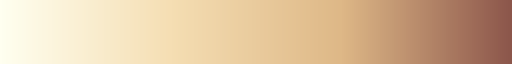

In [6]:
cmap1

In [7]:
colors = ["ivory", "wheat",'burlywood', 'tab:brown','black']
nodes = [0.0, 0.15, 0.33,0.65,1.0] #0.8
cmap3 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

In [8]:
palette = sns.color_palette("YlGnBu", 10).as_hex()
print(palette)
ccc=['#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d']
YlGnBu=LinearSegmentedColormap.from_list("mycmap", ccc)

['#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d', '#1d2e83']


In [9]:
colors = ['white','whitesmoke','lightyellow','#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d', '#1d2e83','midnightblue']
nodes = [0.0,0.05,0.15,0.2,0.25,0.32,0.38,0.42, 0.46,0.5,0.57,0.7,0.8,1.0] #0.8
cmap4 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

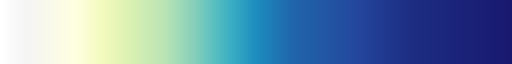

In [10]:
cmap4

In [11]:
my_cmap = cmap1

In [12]:
import matplotlib as mpl
mpl.rc('image', cmap=my_cmap)

## Project 

In [13]:
output = '/exports/csce/datastore/geos/users/s2110831/'

# Load an existing project.
project_name ='3DACOUSTIC_HET600x300_HET_abs2_4el_test2_hetZ_AMBIENTii_LARGER-8el'
event_name = "src_loc_c_isotropic_FS_src_SURF"


In [14]:
# Read data from file:
path_ev = str(output)+"out/"+str(project_name)+"/EVENTS/"+str(event_name)
fig_ = str(path_ev)+'/FIGURES'
para_ = str(path_ev)+'/PARAMETERS'
input_ = str(path_ev)+'/INPUT_MODELS'
output_ = str(path_ev)+'/OUTPUT_FIELDS'
data_ = str(output_)+'/DATA'
#os.mkdir(data_)

mod_ = str(fig_)+'/MODELS'
fields = fig_+str('/FIELDS')
vel_ = fields+ str('/vel')
disp_ = fields+ str('/disp')

_res =  str(fig_)+'/RESULTS'

In [15]:
#OUT =  xr.open_dataset(output_+"/tmp.nc_compress/output.nc")
OUT =  xr.open_dataset(output_+"/output.nc")


In [16]:
# Simulation Parameters
PARA = json.load( open( para_+"/_ALL.json" ) )

# Models
ds_without_q = xr.open_dataset(str(input_)+"/ds_without_q.nc")
el_pos = xr.open_dataset(str(input_)+"/el_pos.nc")

model_true = xr.open_dataset(str(input_)+"/model_true.nc")

In [17]:
nx  = PARA['x_domain']
ny  = PARA['y_domain']
nz  = PARA['z_domain']
rx0 = PARA['rec_grid_pos'][0]
ry0 = PARA['rec_grid_pos'][1]
rx1 = PARA['rec_grid_pos'][2]
ry1 = PARA['rec_grid_pos'][3]
sx  = PARA['src_loc'][0]
sy  = PARA['src_loc'][1]
sz  = abs(PARA['src_loc'][2]-nz)

In [18]:
# Receiver names & positions
receiver_field = xr.open_dataset(str(input_)+"/recs.nc")
#rec_list = pd.DataFrame(np.array(receiver_field.location), receiver_field.st_name)
rec_list = pd.DataFrame(np.array(receiver_field.location))

pd.set_option("display.max_rows", None, "display.max_columns", None)
#plt.scatter(rec_list[0], rec_list[1])
grid = np.array([rec_list[0], rec_list[1]])

rec_list


0      1      2
0     261.0  261.0  300.0
1     261.0  261.0  299.0
2     261.0  261.0  298.0
3     261.0  263.0  300.0
4     261.0  263.0  299.0
5     261.0  263.0  298.0
6     261.0  265.0  300.0
7     261.0  265.0  299.0
8     261.0  265.0  298.0
9     261.0  267.0  300.0
10    261.0  267.0  299.0
11    261.0  267.0  298.0
12    261.0  269.0  300.0
13    261.0  269.0  299.0
14    261.0  269.0  298.0
15    261.0  271.0  300.0
16    261.0  271.0  299.0
17    261.0  271.0  298.0
18    261.0  273.0  300.0
19    261.0  273.0  299.0
20    261.0  273.0  298.0
21    261.0  275.0  300.0
22    261.0  275.0  299.0
23    261.0  275.0  298.0
24    261.0  277.0  300.0
25    261.0  277.0  299.0
26    261.0  277.0  298.0
27    261.0  279.0  300.0
28    261.0  279.0  299.0
29    261.0  279.0  298.0
30    261.0  281.0  300.0
31    261.0  281.0  299.0
32    261.0  281.0  298.0
33    261.0  283.0  300.0
34    261.0  283.0  299.0
35    261.0  283.0  298.0
36    261.0  285.0  300.0
37    261.0  285.0  299.0
38    261.0  285.0  298.0
39    261.0  287.0  300.0
40    261.0  287.0  299.0
41    261.0  287.0  298.0
42    261.0  289.0  300.0
43    261.0  289.0  299.0
44    261.0  289.0  298.0
45    261.0  291.0  300.0
46    261.0  291.0  299.0
47    261.0  291.0  298.0
48    261.0  293.0  300.0
49    261.0  293.0  299.0
50    261.0  293.0  298.0
51    261.0  295.0  300.0
52    261.0  295.0  299.0
53    261.0  295.0  298.0
54    261.0  297.0  300.0
55    261.0  297.0  299.0
56    261.0  297.0  298.0
57    261.0  299.0  300.0
58    261.0  299.0  299.0
59    261.0  299.0  298.0
60    261.0  301.0  300.0
61    261.0  301.0  299.0
62    261.0  301.0  298.0
63    261.0  303.0  300.0
64    261.0  303.0  299.0
65    261.0  303.0  298.0
66    261.0  305.0  300.0
67    261.0  305.0  299.0
68    261.0  305.0  298.0
69    261.0  307.0  300.0
70    261.0  307.0  299.0
71    261.0  307.0  298.0
72    261.0  309.0  300.0
73    261.0  309.0  299.0
74    261.0  309.0  298.0
75    261.0  311.0  300.0
76    261.0  311.0  299.0
77    261.0  311.0  298.0
78    261.0  313.0  300.0
79    261.0  313.0  299.0
80    261.0  313.0  298.0
81    261.0  315.0  300.0
82    261.0  315.0  299.0
83    261.0  315.0  298.0
84    261.0  317.0  300.0
85    261.0  317.0  299.0
86    261.0  317.0  298.0
87    261.0  319.0  300.0
88    261.0  319.0  299.0
89    261.0  319.0  298.0
90    261.0  321.0  300.0
91    261.0  321.0  299.0
92    261.0  321.0  298.0
93    261.0  323.0  300.0
94    261.0  323.0  299.0
95    261.0  323.0  298.0
96    261.0  325.0  300.0
97    261.0  325.0  299.0
98    261.0  325.0  298.0
99    261.0  327.0  300.0
100   261.0  327.0  299.0
101   261.0  327.0  298.0
102   261.0  329.0  300.0
103   261.0  329.0  299.0
104   261.0  329.0  298.0
105   261.0  331.0  300.0
106   261.0  331.0  299.0
107   261.0  331.0  298.0
108   261.0  333.0  300.0
109   261.0  333.0  299.0
110   261.0  333.0  298.0
111   261.0  335.0  300.0
112   261.0  335.0  299.0
113   261.0  335.0  298.0
114   261.0  337.0  300.0
115   261.0  337.0  299.0
116   261.0  337.0  298.0
117   261.0  339.0  300.0
118   261.0  339.0  299.0
119   261.0  339.0  298.0
120   263.0  261.0  300.0
121   263.0  261.0  299.0
122   263.0  261.0  298.0
123   263.0  263.0  300.0
124   263.0  263.0  299.0
125   263.0  263.0  298.0
126   263.0  265.0  300.0
127   263.0  265.0  299.0
128   263.0  265.0  298.0
129   263.0  267.0  300.0
130   263.0  267.0  299.0
131   263.0  267.0  298.0
132   263.0  269.0  300.0
133   263.0  269.0  299.0
134   263.0  269.0  298.0
135   263.0  271.0  300.0
136   263.0  271.0  299.0
137   263.0  271.0  298.0
138   263.0  273.0  300.0
139   263.0  273.0  299.0
140   263.0  273.0  298.0
141   263.0  275.0  300.0
142   263.0  275.0  299.0
143   263.0  275.0  298.0
144   263.0  277.0  300.0
145   263.0  277.0  299.0
146   263.0  277.0  298.0
147   263.0  279.0  300.0
148   263.0  279.0  299.0
149   263.0  279.0  298.0
150   263.0  281.0  300.0
151   263.0  281.0  299.0
152   263.0  281.0  298.0
153   

In [19]:
PARA['dist_X']=2.0
PARA

{'vel_model': 'heterogeneous_xy_hetZ',
 'rho_model': 'sin_dist2b_hetZ',
 'Q_model': 'homogeneous+',
 'x_domain': 600,
 'y_domain': 600,
 'z_domain': 300,
 'h_max': 9.32180437578956,
 'source_type': 'ambient_noise1',
 'elements_per_wavelength': 4,
 'simulation_time': 3.0,
 'start_time': -0.2215319116594116,
 'dist_X': 2.0,
 'dist_Y': 2.0,
 'dist_Z': 1.0,
 'nt': 23544,
 'dt': 0.00013683608340735724,
 'dt_at': 0.00013683608340735724,
 'recs_surf': 1600,
 'recs_depth': 3,
 'recs_total': 1603,
 'rec_grid_pos': [261.0, 261.0, 339.0, 339.0, 300, 298],
 'src_loc': [300.0, 300.0, 290],
 'src_cent_f': 7.642857142857143}

In [20]:
nr = int(np.sqrt(PARA['recs_surf']))
nrz = PARA['recs_depth']
dist_r = PARA['dist_X']

nrx = nr
nry = nr
nrz = nrz

VEL_Z     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))
VEL_Z_COPY     = np.reshape(OUT.Pressure.data, (nrx,nry,nrz,PARA['nt']))


In [21]:
test=np.reshape(np.asarray(rec_list), (nr,nr,3,3))
test[2,2,0]

array([265., 265., 300.])

In [22]:
OUT

<xarray.Dataset>
Dimensions:    (station_n: 4800, time: 23544)
Coordinates:
  * station_n  (station_n) object 'XX.000000.' 'XX.000001.' ... 'XX.393902.'
  * time       (time) int64 0 1 2 3 4 5 ... 23538 23539 23540 23541 23542 23543
Data variables:
    Pressure   (station_n, time) float64 0.0 0.0 0.0 0.0 ... 5.85 5.82 5.792

### Normalization

In [23]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

normalise = 'yes'

#VEL_ZZ = np.zeros((VEL_Z.shape))
if normalise =='yes':
#                 for l in range(0,nr): 
#                     for k in range(0,nr):
#                         for m in range(0,3):
#                             VEL_ZZ[l,k,m,:] = normalize(VEL_Z[l,k,m,:])
                VEL_Z = normalize(VEL_Z)#VEL_ZZ

### Position

In [24]:

# Surface Receiver position
posX = 2 
posY = 2

# Depth level 
posZ = 0 

### Spectrogram

(0.0, 30.0)

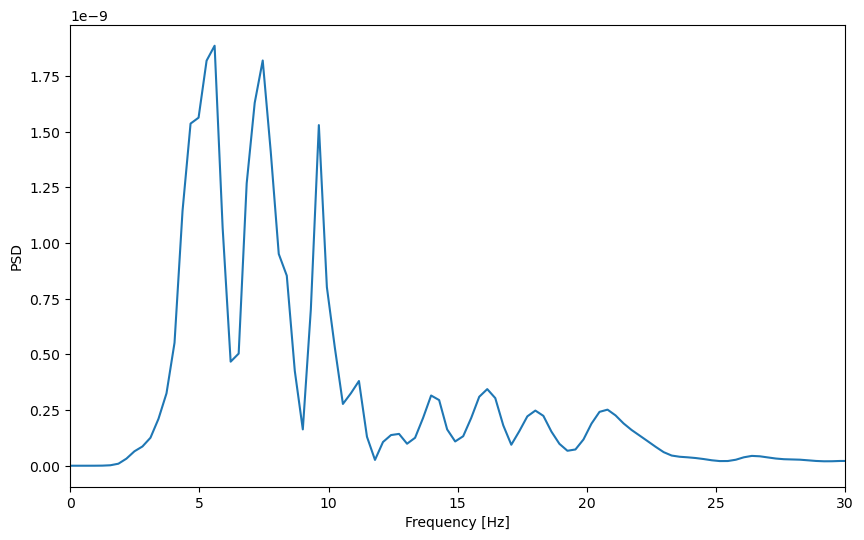

In [25]:
from scipy import signal
f, t, Sxx = signal.spectrogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'],window=('tukey', 0.1), nperseg=None, noverlap=None)
fff, Pxx = signal.periodogram(VEL_Z[posX,posY,posZ,:],fs=1/PARA['dt'])


fig, axs = plt.subplots(figsize=(10,6))

plt.plot(fff,Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.xlim(0,30)

### Filtering

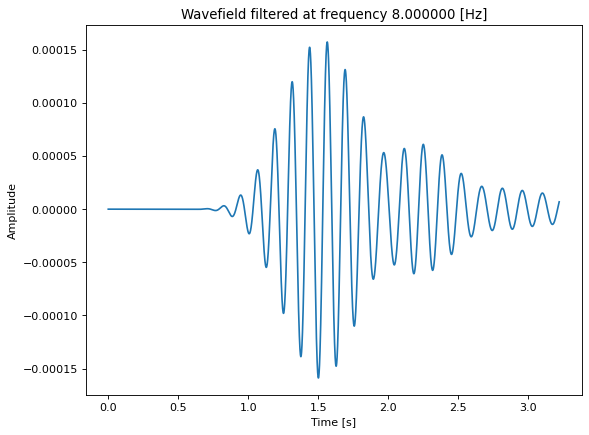

In [26]:
# Bandbass Filter
t = np.linspace(0,PARA['nt']*PARA['dt'], PARA['nt'])

nn = np.array([7])#([0.01]) 18 ###0.1     #10.5
mm = np.array([9])#([70]) 25     ###6 #11.5
f_BAND = np.array([nn,mm])


U_filt_Z = np.zeros((VEL_Z.shape[0],VEL_Z.shape[1], nrz, VEL_Z.shape[3],len(f_BAND[0,:])))

for dd in range(nrz):


        U_filterZ, f_filt_cent = BP_filter(VEL_Z[:,:,dd,:], f_BAND, PARA['dt'], posX, posY, t)
        U_filt_Z[:,:,dd,:,:] = np.reshape(U_filterZ, (U_filt_Z[:,:,dd,:,:].shape))


nf = 0
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t, U_filt_Z[posX,posY,posZ,:,nf])
plt.title('Wavefield filtered at frequency %f [Hz]' %np.round(f_filt_cent[nf],2))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show() 
    
ll = len(f_filt_cent)
    

In [27]:
AMP = np.zeros((nr,nr))

for l in range(0,nr): 
        for k in range(0,nr):

            AMP[l,k] = np.max( U_filt_Z[l,k,0,:,0])

### Subsampling

In [28]:
# Spatial Subsampling of true model
# Get velocity, density and attenuation fields at receiver points

rxx=nr
ryy=nr
rzz = nrz

grid_pos = 'full'

Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) ).tolist()
Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) ).tolist()
Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

vp_sub_INPUT     = ds_without_q.vp.values[:,:,Rz]
vp_sub_INPUT     = vp_sub_INPUT[Rx,:,:]
vp_sub_INPUT     = np.asarray(vp_sub_INPUT[:,Ry,:])

rho_grad_INPUT   = ds_without_q.rho.values[:,:,Rz]
rho_grad_INPUT   = rho_grad_INPUT[Rx,:,:]
rho_grad_INPUT   = np.asarray(rho_grad_INPUT[:,Ry,:])

vp_sub     = model_true.VP[:,:,Rz].values #ds_without_q.vp.values[:,:,Rz]
vp_sub     = vp_sub[Rx,:,:]
vp_sub     = np.asarray(vp_sub[:,Ry,:])

rho_grad   = model_true.RHO[:,:,Rz].values #ds_without_q.rho.values[:,:,Rz]
rho_grad   = rho_grad[Rx,:,:]
rho_grad   = np.asarray(rho_grad[:,Ry,:])

if grid_pos =='half':
    
    Rx = (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int) -1 ).tolist()
    Ry = (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int) -1 ).tolist()
    Rz = (np.linspace(PARA['rec_grid_pos'][4], PARA['rec_grid_pos'][5], nrz).astype(int) -1 ).tolist()

    Rxx= (np.linspace(PARA['rec_grid_pos'][0], PARA['rec_grid_pos'][2], nr).astype(int)+1  ).tolist()
    Ryy= (np.linspace(PARA['rec_grid_pos'][1], PARA['rec_grid_pos'][3], nr).astype(int)+1  ).tolist()
    
    rho_grad1   = ds_without_q.rho.values[:,:,Rz]
    rho_grad1   = rho_grad1[Rx,:,:]
    rho_grad1   = np.asarray(rho_grad1[:,Ry,:])

    rho_grad2   = ds_without_q.rho.values[:,:,Rz]#ds_without_q.rho[:,:,Rz] #model_true.RHO[:,:,Rz]
    rho_grad2   = rho_grad2[Rxx,:,:]
    rho_grad2   = rho_grad2[:,Ryy,:]
    rho_grad    = (rho_grad1.values+rho_grad2.values)/2

    vp_sub1     = ds_without_q.vp.values[:,:,Rz] #
    vp_sub1     = vp_sub1[Rx,:,:]
    vp_sub1     = np.asarray(vp_sub1[:,Ry,:])

    vp_sub2     = ds_without_q.vp.values[:,:,Rz] #
    vp_sub2     = vp_sub2[Rxx,:,:]
    vp_sub2     = np.asarray(vp_sub2[:,Ryy,:])
    vp_sub = (vp_sub1+vp_sub2)/2

c_sub      = vp_sub # 0.9*vs_sub

#qkappa_sub = ds_without_q.qkappa.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
#qkappa_sub = qkappa_sub[:,:,::-1]
#qmu_sub    = ds_with_q.qmu.values[Rx[0]:Rx[-1]+1,Ry[0]:Ry[-1]+1,Rz[-1]:Rz[0]+1]
#qmu_sub = qmu_sub[:,:,::-1]
#Qp = 1/(((1-(vs_sub**2)/(vp_sub**2))*(1/qkappa_sub)) + ((vs_sub**2)/(vp_sub**2)*(1/qmu_sub)))
#Qs = qmu_sub   


In [29]:
# Potential temporal subsampling
sub= 20         
nt_sub = np.ceil(PARA['nt']/sub).astype(int) 
dt_sub = sub* PARA['dt']
t_sub  = np.linspace(0,nt_sub*dt_sub, nt_sub)

#Potential spatial sampling
dx = PARA['dist_X']
dy = PARA['dist_Y']
dz = PARA['dist_Z']

sub_spXY = 2
dx = dx*sub_spXY
dy = dy*sub_spXY
sub_spZ  = 1
dz = dz*sub_spZ
dist_r=dist_r*sub_spXY
nr  = int(nr/sub_spXY)
rxx = int(rxx/sub_spXY)
ryy = int(ryy/sub_spXY)
nrz = int(nrz/sub_spZ)
rzz = int(rzz/sub_spZ)

  
u_field_Z =   U_filt_Z[::sub_spXY,::sub_spXY,::sub_spZ,::sub,:]
   

vp_subTRUE = vp_sub[:,:,:]   
rho_gradTRUE = rho_grad[:,:,:]
vp_sub = vp_sub[::sub_spXY,::sub_spXY,::sub_spZ]
#vs_sub = vs_sub[::sub_spXY,::sub_spXY,::sub_spZ]
rho_grad = rho_grad[::sub_spXY,::sub_spXY,::sub_spZ]

AMP = AMP[::sub_spXY,::sub_spXY]

lam_min = np.min(model_true.VP).data/(2*f_filt_cent)
print('Subsampled time interval',dt_sub)
print('Sampling min:' ,1/(2*f_filt_cent))
print('Min Wavelength', lam_min[0],'m')
print('spatial sampling', dx)
print('Vel het',113,'m')
print('rho het',88,'m')
print('ratio vel_het/lam_min[0]',113/lam_min[0])
print('ratio rho_het/lam_min[0]',88/lam_min[0])

Subsampled time interval 0.0027367216681471445
Sampling min: [0.0625]
Min Wavelength 96.93457698728727 m
spatial sampling 4.0
Vel het 113 m
rho het 88 m
ratio vel_het/lam_min[0] 1.165734699753419
ratio rho_het/lam_min[0] 0.9078287927283263


## Gradient Calculation

### Temporal

In [30]:
N =  nr**2 * nrz #PARA['recs_depth'] * PARA['recs_surf']

VEL_Z = np.reshape(u_field_Z[:,:,:,:,:], (N,nt_sub,u_field_Z[:,:,:,:,:].shape[4]))

In [31]:
# Temporal derivatives, order options: 2, 4, 8
order = 2
dttv1, dttv2, dttv3 = dttv(VEL_Z, VEL_Z, VEL_Z, dt_sub, nt_sub, order)

In [32]:
nrx = rxx
nry = ryy
nrz = rzz
dttv1 = np.reshape(dttv1, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))
dttv2 = np.reshape(dttv2, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))
dttv3 = np.reshape(dttv3, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))

### Spatial

(via Classical FD stencil)
- #### cross-shaped, regular grid

In [33]:
VEL_Z = np.reshape(VEL_Z, (nrx,nry,nrz,nt_sub, u_field_Z.shape[4]))

In [34]:
# First Order

order = 2
#check order 4
VEL_X_gradX, VEL_Y_gradX, VEL_Z_gradX, VEL_X_gradY, VEL_Y_gradY, VEL_Z_gradY, VEL_X_gradZ, VEL_Y_gradZ, VEL_Z_gradZ \
= _1st_DER(VEL_Z, VEL_Z, VEL_Z, dx, dy, dz, nrx, nry, nrz, order)

In [35]:
# Second Order

order = 2
#check order 4
VEL_X_gradXX, VEL_Y_gradXX, VEL_Z_gradXX, VEL_X_gradYY, VEL_Y_gradYY, VEL_Z_gradYY, VEL_X_gradZZ,\
VEL_Y_gradZZ, VEL_Z_gradZZ, VEL_X_gradXY, VEL_Y_gradXY, VEL_Z_gradXY, VEL_X_gradYX, VEL_Y_gradYX,\
VEL_Z_gradYX, VEL_X_gradYZ, VEL_Y_gradYZ, VEL_Z_gradYZ, VEL_X_gradXZ, VEL_Y_gradXZ, VEL_Z_gradXZ \
= _2nd_DER(VEL_Z, VEL_Z, VEL_Z, dx, dy, dz, nrx, nry, nrz, order)

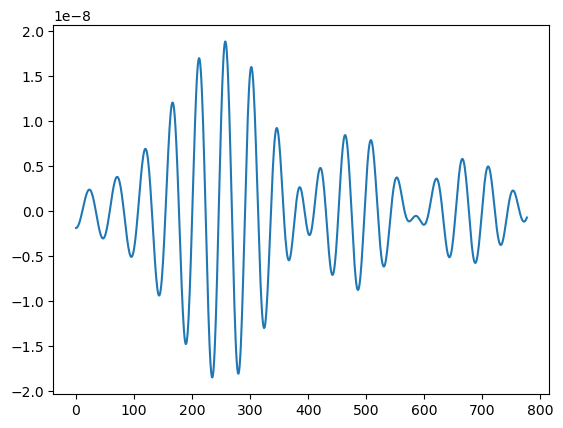

In [36]:
plt.plot(VEL_Y_gradXY[posX,posY,posZ,400:4500])

- ### 2D Helmholtz Acoustic Wave Equation


In [37]:
a=1
b=nt_sub-1

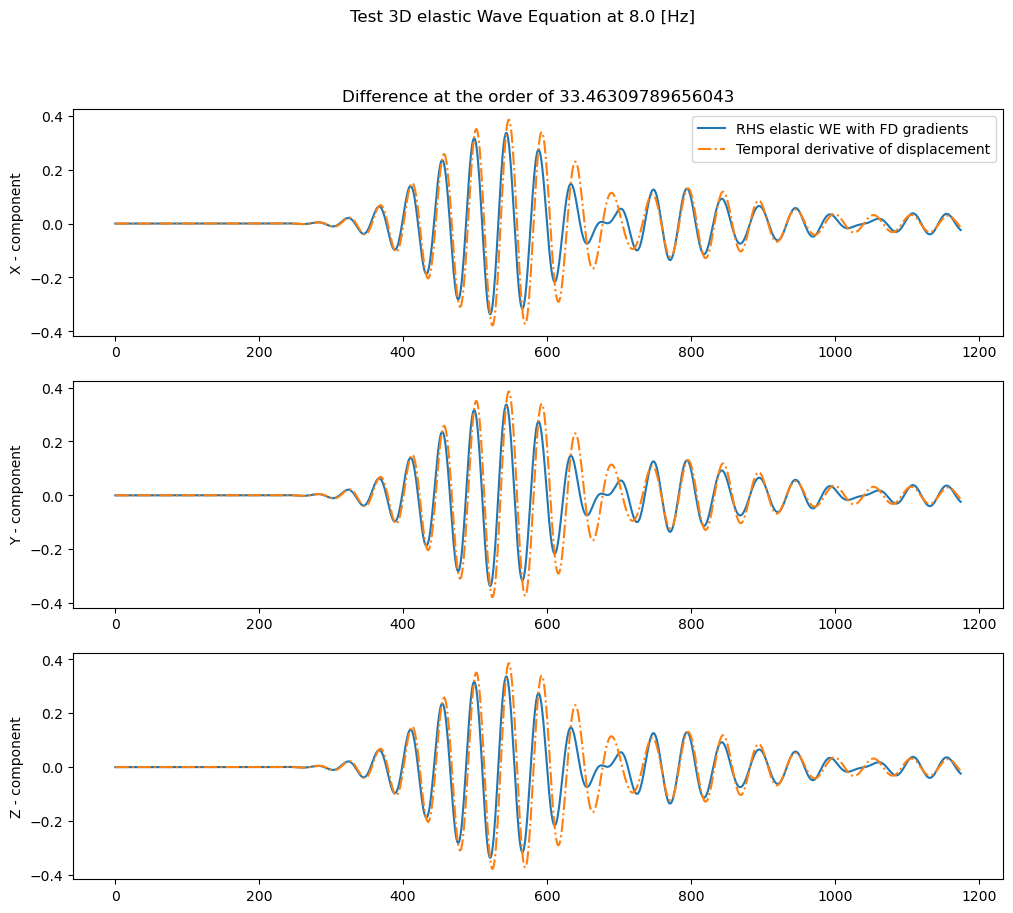

In [38]:
filtered='yes'
acc1_2D,acc2_2D,acc3_2D = WE_2D_ACOUSTIC(VEL_X_gradXX[:,:,:,a:b,:], VEL_Y_gradXX[:,:,:,a:b,:], VEL_Z_gradXX[:,:,:,a:b,:], VEL_X_gradYY[:,:,:,a:b,:], VEL_Y_gradYY[:,:,:,a:b,:], VEL_Z_gradYY[:,:,:,a:b,:], VEL_X_gradZZ[:,:,:,a:b,:],\
VEL_Y_gradZZ[:,:,:,a:b,:], VEL_Z_gradZZ[:,:,:,a:b,:], VEL_X_gradXY[:,:,:,a:b,:], VEL_Y_gradXY[:,:,:,a:b,:], VEL_Z_gradXY[:,:,:,a:b,:], VEL_X_gradYX[:,:,:,a:b,:], VEL_Y_gradYX[:,:,:,a:b,:],\
VEL_Z_gradYX[:,:,:,a:b,:], VEL_X_gradYZ[:,:,:,a:b,:], VEL_Y_gradYZ[:,:,:,a:b,:], VEL_Z_gradYZ[:,:,:,a:b,:], VEL_X_gradXZ[:,:,:,a:b,:], VEL_Y_gradXZ[:,:,:,a:b,:], VEL_Z_gradXZ[:,:,:,a:b,:], vp_sub, c_sub,\
dttv1[:,:,:,a:b,:], dttv2[:,:,:,a:b,:], dttv3[:,:,:,a:b,:], posX,posY, posZ, nf, f_filt_cent, filtered)

In [39]:
ordd=0
nt_range = b-a
comp = 'Z'
c_phase_Z_2D, mZ_2D, r_sq_Z_2D = LinReg_c(acc3_2D[:,:,:,:,:],dttv3[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz,ordd)

In [40]:
plt.rcdefaults()


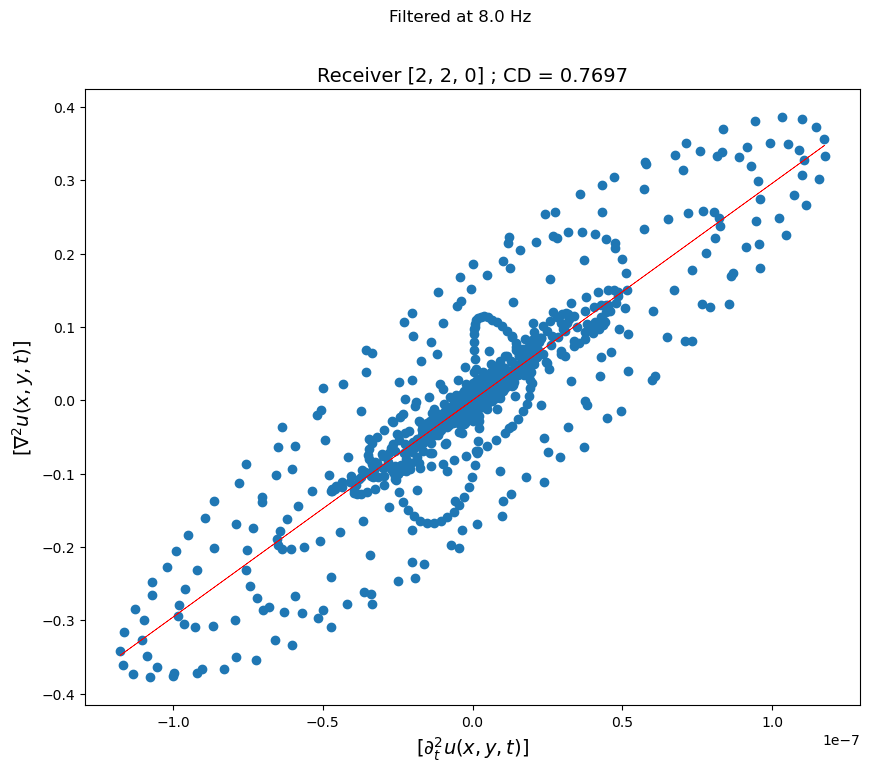

In [41]:
comp = 'Z'
if comp == 'X':
    LinReg_PLOT(acc1_2D[:,:,:,:,:], dttv1[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz, posX, posY, posZ, nf, mX_2D, r_sq_X_2D, f_filt_cent, filtered)
elif comp == 'Y':
    LinReg_PLOT(acc2_2D[:,:,:,:,:], dttv2[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz, posX, posY, posZ, nf, mY_2D, r_sq_Y_2D, f_filt_cent, filtered)
elif comp == 'Z':
    LinReg_PLOT(acc3_2D[:,:,:,:,:], dttv3[:,:,:,a:b,:], nt_range, ll, N, nrx, nry, nrz, posX, posY, posZ, nf, mZ_2D, r_sq_Z_2D, f_filt_cent, filtered)

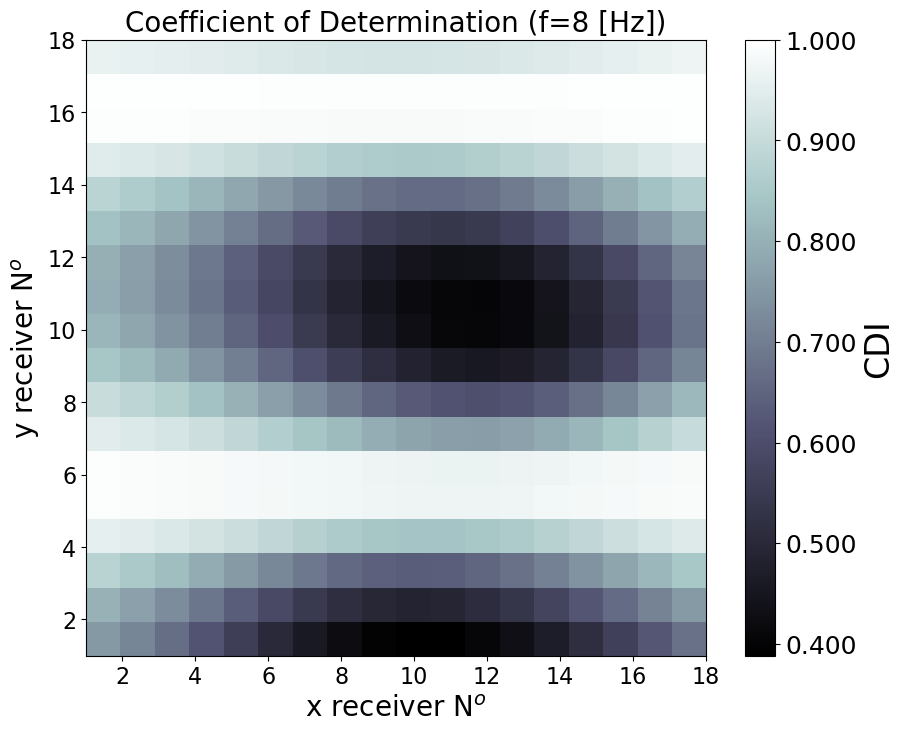

In [42]:
to_export = pd.DataFrame( r_sq_Z_2D[:,:,0,0])
to_export.to_csv(fig_+'/r_sq_HELM_'+str(round(f_filt_cent[0])), index=False)

fig,ax = plt.subplots(figsize=(10,8))
plt.title('Coefficient of Determination (f=%d [Hz])' %f_filt_cent[nf], size=20)     
im=plt.imshow( r_sq_Z_2D[1:-1,1:-1,posZ,nf] , vmax=1,vmin=np.min(r_sq_Z_2D[1:-1,1:-1,posZ,nf]) ,aspect='auto', interpolation='none', origin='lower', extent=[1,18,1,18], cmap='bone' ) #,extent=[-3, 3, -3, 3]
cbar = plt.colorbar(im, format='%.3f')
cbar.set_label(label='CDI',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

#plt.savefig(str(fig_)+'/2DHELM_'+str(round(f_filt_cent[0])))


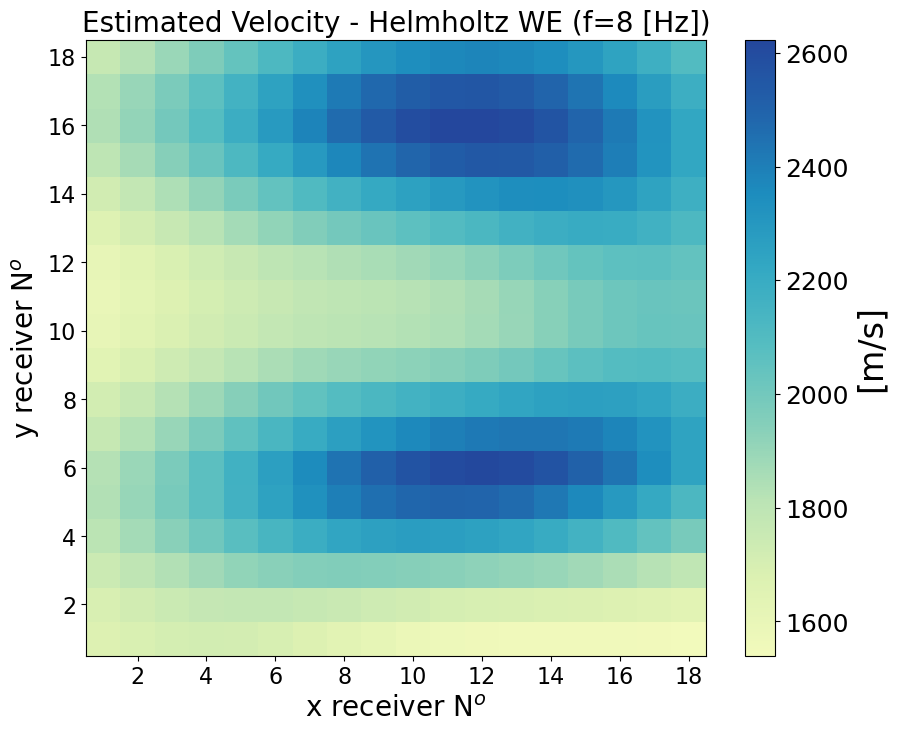

In [43]:
c_phase = c_phase_Z_2D

to_export = pd.DataFrame(c_phase_Z_2D[:,:,0,0])
to_export.to_csv(fig_+'/c_HELM_'+str(round(f_filt_cent[0])), index=False)


fig,ax = plt.subplots(figsize=(10,8))
plt.title('Estimated Velocity - Helmholtz WE (f=%d [Hz])' %f_filt_cent[nf], size=20) 
im2=plt.imshow(c_phase_Z_2D[1:-1,1:-1,0,0] ,vmin=np.min(c_phase_Z_2D[1:-1,1:-1,0,0]), vmax=np.max(c_phase_Z_2D[1:-1,1:-1,0,0]), aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label='[m/s]',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


plt.show() 


In [44]:
#rho_inv = pd.read_csv(fig_+'/rho_inv_minRMS_7')
rho_inv = pd.read_csv(fig_+'/rho_inv_minMIS'+'_'+str(round(f_filt_cent[0])))
#rho_inv = pd.read_csv(fig_+'/rho_inv_minMIS'+'_'+str(round(f_filt_cent[0])))
rho_TRUE = rho_grad[:,:,0]

In [45]:
import FCT_GRADIOMETRY_good_loop
from FCT_GRADIOMETRY_good_loop import *

In [46]:
rho_m_sub = np.asarray([rho_inv])
N=nr**2
U_LAPLACE_VAR, Utt_LAPLACE_VAR, prod , Dxx_VAR = GRAD_LAPLACE_VAR(dist_r, VEL_Z[:,:,0,:,:], nt_range, nr, nr, dt_sub, rho_m_sub, f_filt_cent)
c_phase_new, mZ_new, r_sq_new = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], nt_range-2, ll, N, nr, nr, nrz,ordd)
    
rho_m_sub = rho_TRUE
N=nr**2
U_LAPLACE_VAR_TRUE, Utt_LAPLACE_VAR_TRUE, prod_TRUE , Dxx_VAR_TRUE = GRAD_LAPLACE_VAR(dist_r, VEL_Z[:,:,0,:,:], nt_range, nr, nr, dt_sub, rho_m_sub, f_filt_cent)
c_phase_new_TRUE, mZ_new_TRUE, r_sq_new_TRUE = LinReg_c2(U_LAPLACE_VAR[:,:,1:-1,0],Utt_LAPLACE_VAR[:,:,1:-1,0], nt_range-2, ll, N, nr, nr, nrz,ordd)

to_export = pd.DataFrame(c_phase_new_TRUE[:,:,0])
to_export.to_csv(fig_+'/c_ACC_TRUE_'+str(round(f_filt_cent[0])), index=False)    

to_export = pd.DataFrame(r_sq_new_TRUE[:,:,0])
to_export.to_csv(fig_+'/r_sq_ACC_TRUE_'+str(round(f_filt_cent[0])), index=False)    

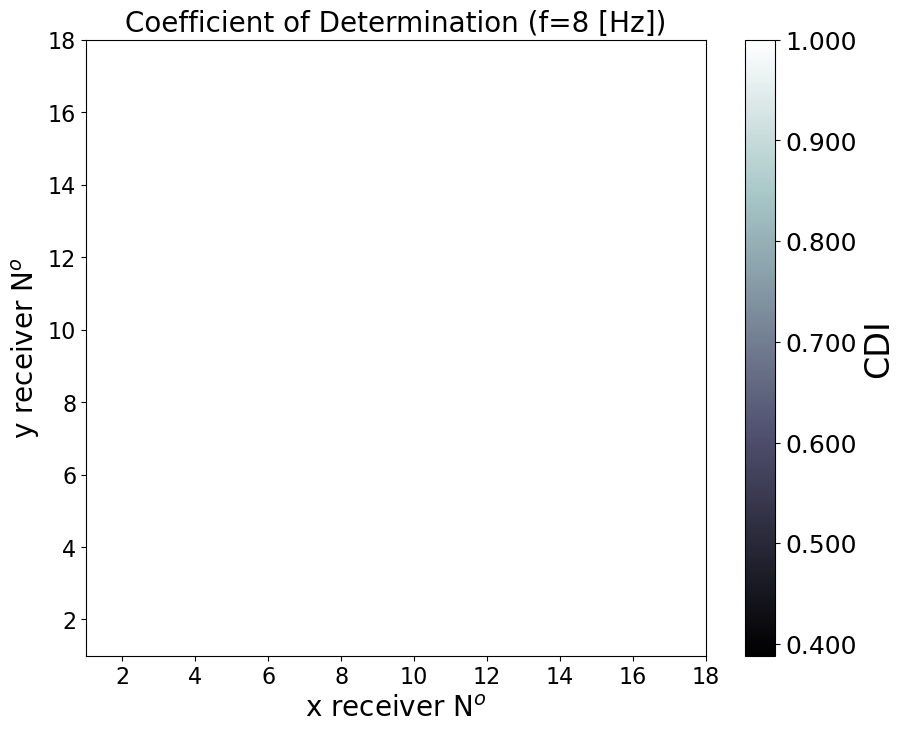

In [47]:
to_export = pd.DataFrame(r_sq_new[:,:,0])
to_export.to_csv(fig_+'/r_sq_ACC_'+str(round(f_filt_cent[0])), index=False)

fig,ax = plt.subplots(figsize=(10,8))
plt.title('Coefficient of Determination (f=%d [Hz])' %f_filt_cent[nf], size=20)     
im=plt.imshow(r_sq_new[1:-1,1:-1,nf] ,  aspect='auto',vmax=1,vmin=np.min(r_sq_Z_2D[1:-1,1:-1,posZ,nf]), interpolation='none', origin='lower', extent=[1,18,1,18], cmap='bone' ) #,extent=[-3, 3, -3, 3]
cbar = plt.colorbar(im, format='%.3f')
cbar.set_label(label='CDI',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


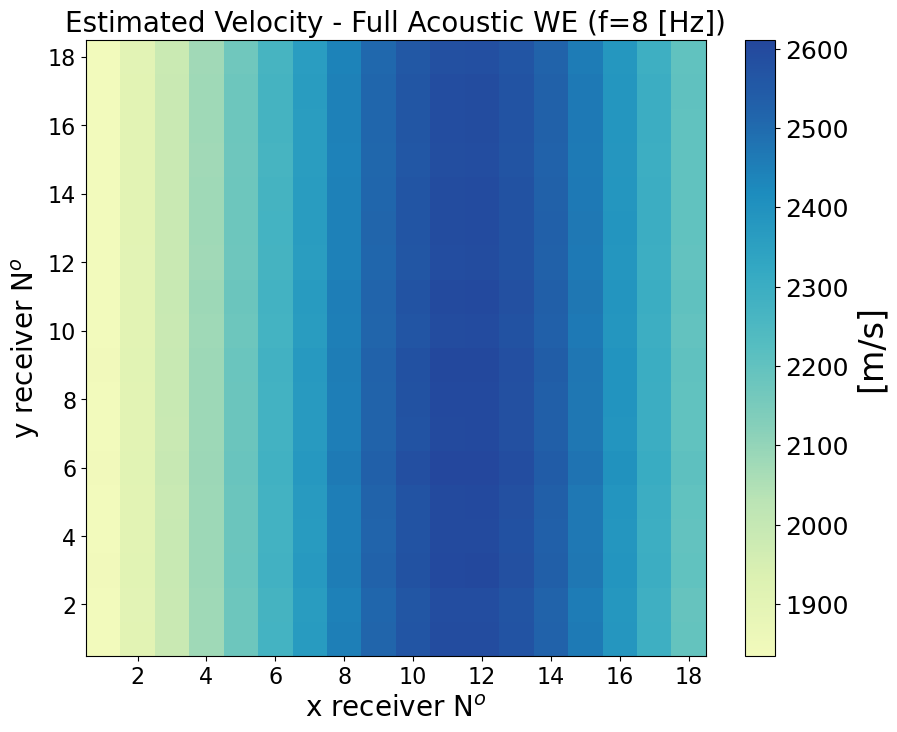

In [48]:
c_phase = c_phase_new

to_export = pd.DataFrame(c_phase[:,:,0])
to_export.to_csv(fig_+'/c_ACC_'+str(round(f_filt_cent[0])), index=False)


fig,ax = plt.subplots(figsize=(10,8))
plt.title('Estimated Velocity - Full Acoustic WE (f=%d [Hz])' %f_filt_cent[nf], size=20) 
im2=plt.imshow(c_phase_new[1:-1,1:-1,0] ,vmin=np.min(c_phase_new[1:-1,1:-1,0]), vmax=np.max(c_phase_new[1:-1,1:-1,0]), aspect='auto', interpolation='none', cmap=YlGnBu,origin='lower' ,extent=[0.5, nr-2+0.5, 0.5, nr-2+0.5]) #,extent=[-3, 3, -3, 3]
#plt.gca().invert_yaxis()
cbar = plt.colorbar(im2, format='%.0f')
cbar.set_label(label='[m/s]',size=24)
for t in cbar.ax.get_yticklabels():
         t.set_fontsize(18)
plt.xlabel(r'x receiver N$^{o}$',fontsize=20)
plt.ylabel(r'y receiver N$^{o}$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


plt.show() 


In [49]:
d_obs = dttv3[:,:,0,1:-1,0]
d_pred_HELM = (c_phase_Z_2D[:,:,0,0,np.newaxis]**2) * acc3_2D[:,:,0,:,0]

d_pred_ACC = (c_phase_new[:,:,0,np.newaxis]**2) * U_LAPLACE_VAR[:,:,1:-1,0]
d_obs_ACC = Utt_LAPLACE_VAR[:,:,1:-1,0]

d_pred_ACC_TRUE = (c_phase_new_TRUE[:,:,0,np.newaxis]**2) * U_LAPLACE_VAR_TRUE[:,:,1:-1,0]
d_obs_ACC_TRUE = Utt_LAPLACE_VAR_TRUE[:,:,1:-1,0]

residual_HELM = (d_obs-d_pred_HELM)
residual_ACC = (d_obs_ACC-d_pred_ACC)
residual_ACC_TRUE = (d_obs_ACC_TRUE-d_pred_ACC_TRUE)

J_HELM =   ((d_obs-d_pred_HELM))**2
J_ACC  =   ((d_obs_ACC-d_pred_ACC))**2
J_ACC_TRUE  =   ((d_obs_ACC_TRUE-d_pred_ACC_TRUE))**2

J_HELM = ( 1/(nt_sub-2) * J_HELM.sum(2))
J_ACC  = (1/(nt_sub-2) * J_ACC.sum(2) )
J_ACC_TRUE  = (1/(nt_sub-2) * J_ACC_TRUE.sum(2) )

to_export = pd.DataFrame(J_HELM[:,:])
to_export.to_csv(fig_+'/J_HELM*'+'_'+str(round(f_filt_cent[0])), index=False)


to_export = pd.DataFrame(J_ACC[:,:])
to_export.to_csv(fig_+'/J_ACC_min*'+'_'+str(round(f_filt_cent[0])), index=False)

to_export = pd.DataFrame(J_ACC_TRUE[:,:])
to_export.to_csv(fig_+'/J_ACC_TRUE'+'_'+str(round(f_filt_cent[0])), index=False)

In [50]:
#C_BASE[:,:] = pd.read_csv(fig_+'/c_BASELINE_'+str(round(f_filt_cent[0]))).values

In [51]:
#pstop

### Frequency Analysis

In [52]:
nr=20
fff = np.arange(4,15,1)
length = len(fff)
C_ACC = np.zeros((length,nr,nr))
C_ACC_TRUE = np.zeros((length,nr,nr))
C_BASE = np.zeros((length,nr,nr))
C_HELM = np.zeros((length,nr,nr))

RSQ_ACC = np.zeros((length,nr,nr))
RSQ_ACC_TRUE = np.zeros((length,nr,nr))
RSQ_BASE = np.zeros((length,nr,nr))
RSQ_HELM = np.zeros((length,nr,nr))

MIS_ACC = np.zeros((length,nr,nr))
MIS_ACC_TRUE = np.zeros((length,nr,nr))
MIS_BASE = np.zeros((length,nr,nr))
MIS_HELM = np.zeros((length,nr,nr))

i=0
for ff in fff: 
    C_ACC[i,:,:] = pd.read_csv(fig_+'/c_ACC_'+str(ff)).values
    C_ACC_TRUE[i,:,:] = pd.read_csv(fig_+'/c_ACC_TRUE_'+str(ff)).values
    C_BASE[i,:,:] = pd.read_csv(fig_+'/c_BASELINE_'+str(ff)).values
    C_HELM[i,:,:] = pd.read_csv(fig_+'/c_HELM_'+str(ff)).values
    RSQ_ACC[i,:,:] = pd.read_csv(fig_+'/r_sq_ACC_TRUE_'+str(ff)).values
    RSQ_ACC_TRUE[i,:,:] = pd.read_csv(fig_+'/r_sq_ACC_'+str(ff)).values
    RSQ_BASE[i,:,:] = pd.read_csv(fig_+'/r_sq_BASELINE_'+str(ff)).values
    RSQ_HELM[i,:,:] = pd.read_csv(fig_+'/r_sq_HELM_'+str(ff)).values
    MIS_ACC[i,:,:] = pd.read_csv(fig_+'/J_ACC_min*'+'_'+str(ff)).values[1:-1,1:-1].sum(1).sum(0)/(nr-2)**2
    MIS_ACC_TRUE[i,:,:] = pd.read_csv(fig_+'/J_ACC_TRUE'+'_'+str(ff)).values[1:-1,1:-1].sum(1).sum(0)/(nr-2)**2
    MIS_BASE[i,:,:] = pd.read_csv(fig_+'/J_BASE*_'+str(ff)).values[1:-1,1:-1].sum(1).sum(0)/(nr-2)**2
    MIS_HELM[i,:,:] = pd.read_csv(fig_+'/J_HELM*'+'_'+str(ff)).values[1:-1,1:-1].sum(1).sum(0)/(nr-2)**2
    
    i=i+1

In [53]:
fff

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

4 Hz
5 Hz
6 Hz
7 Hz
8 Hz
9 Hz
10 Hz
11 Hz
12 Hz
13 Hz
14 Hz


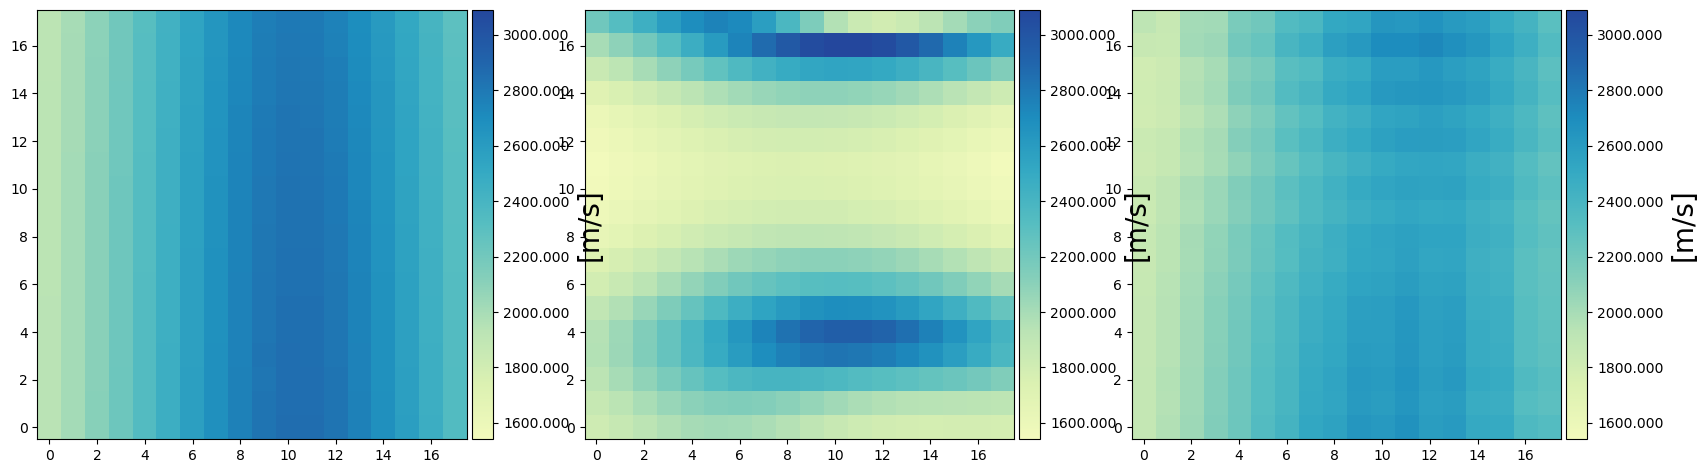

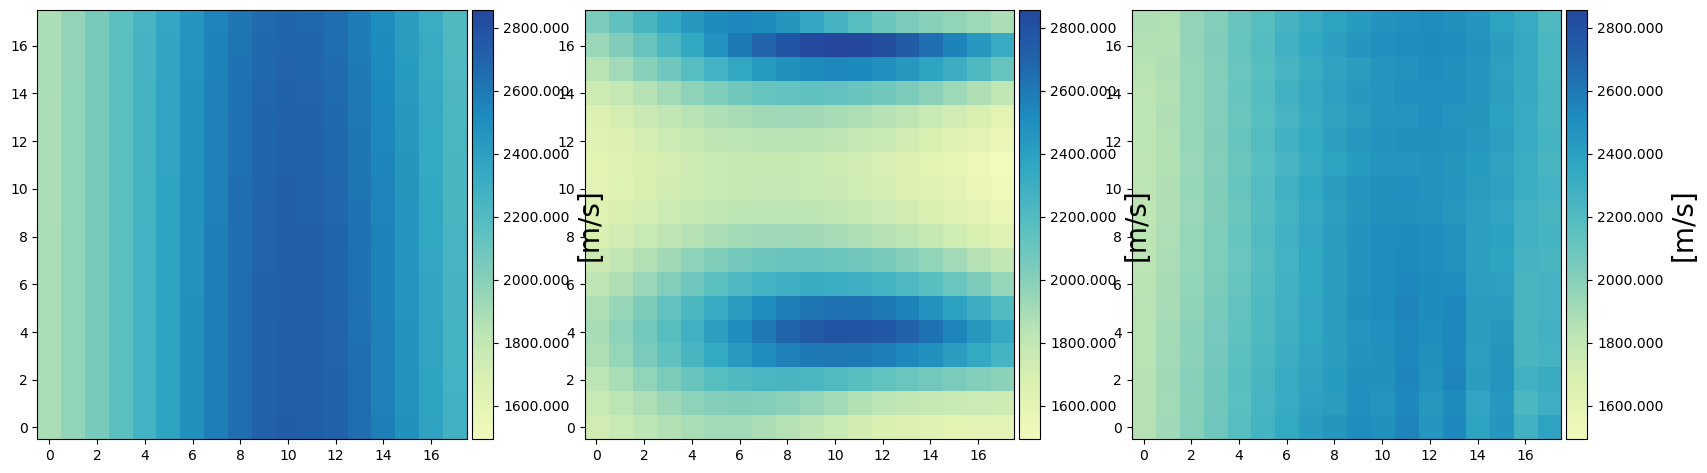

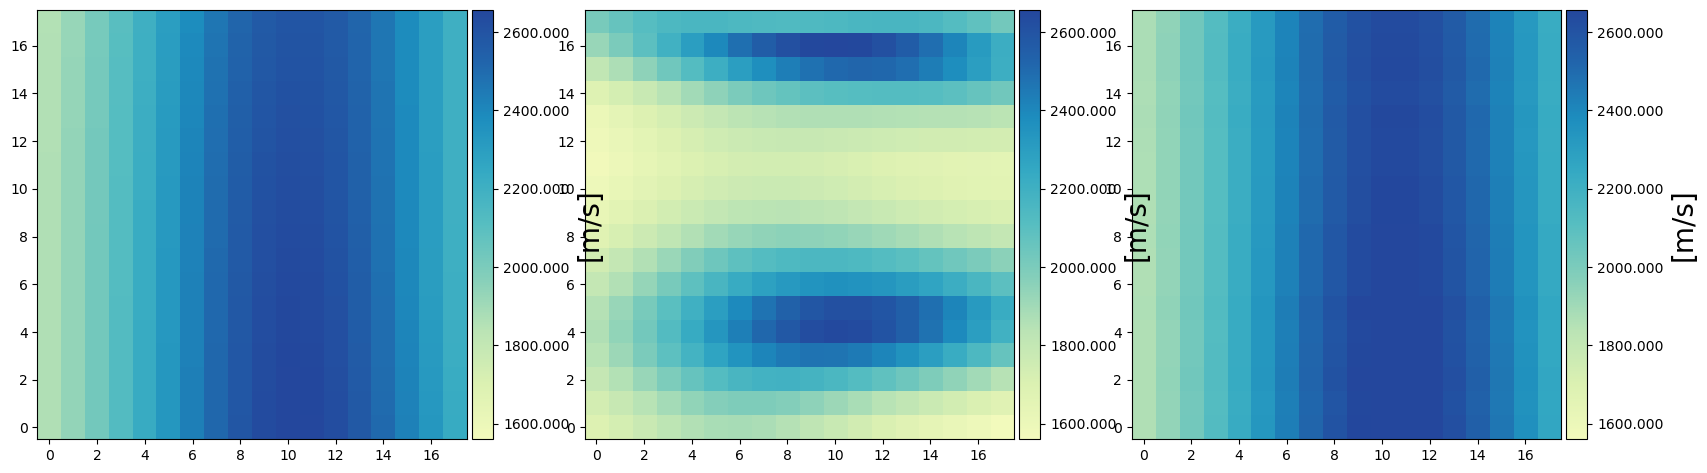

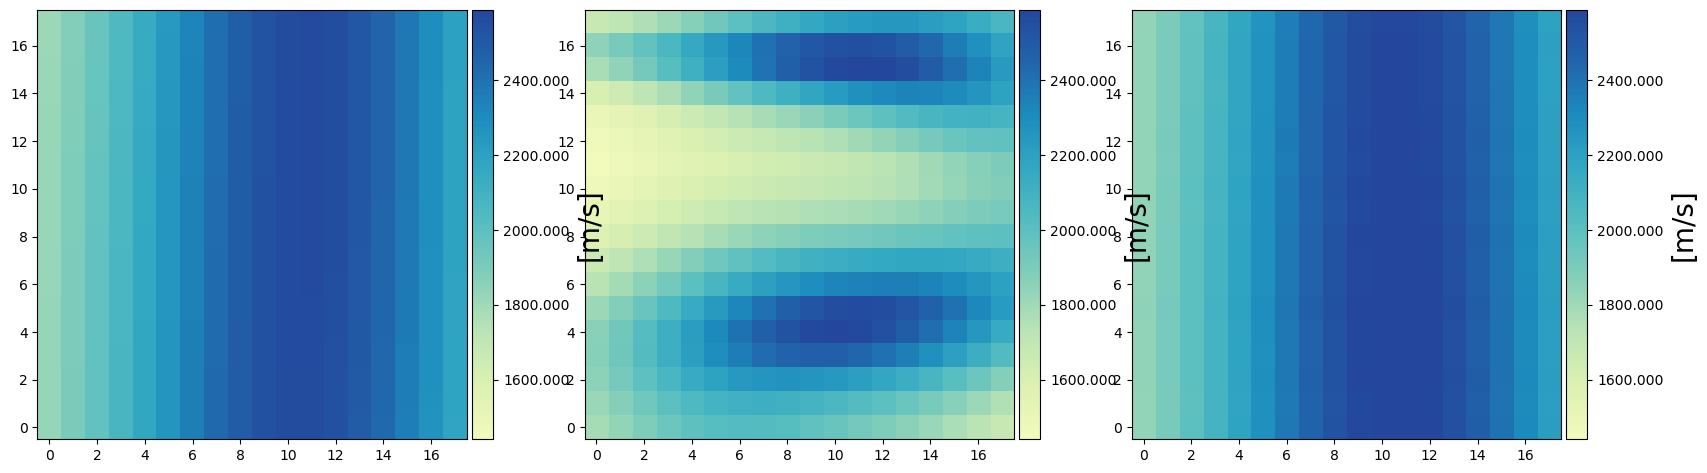

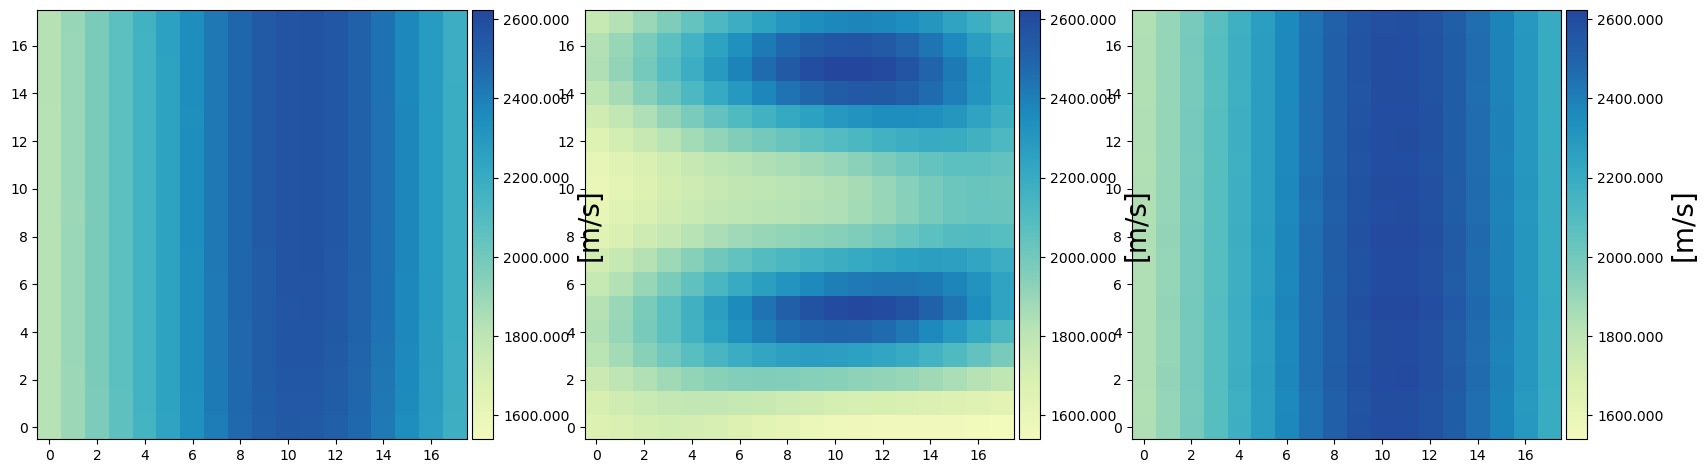

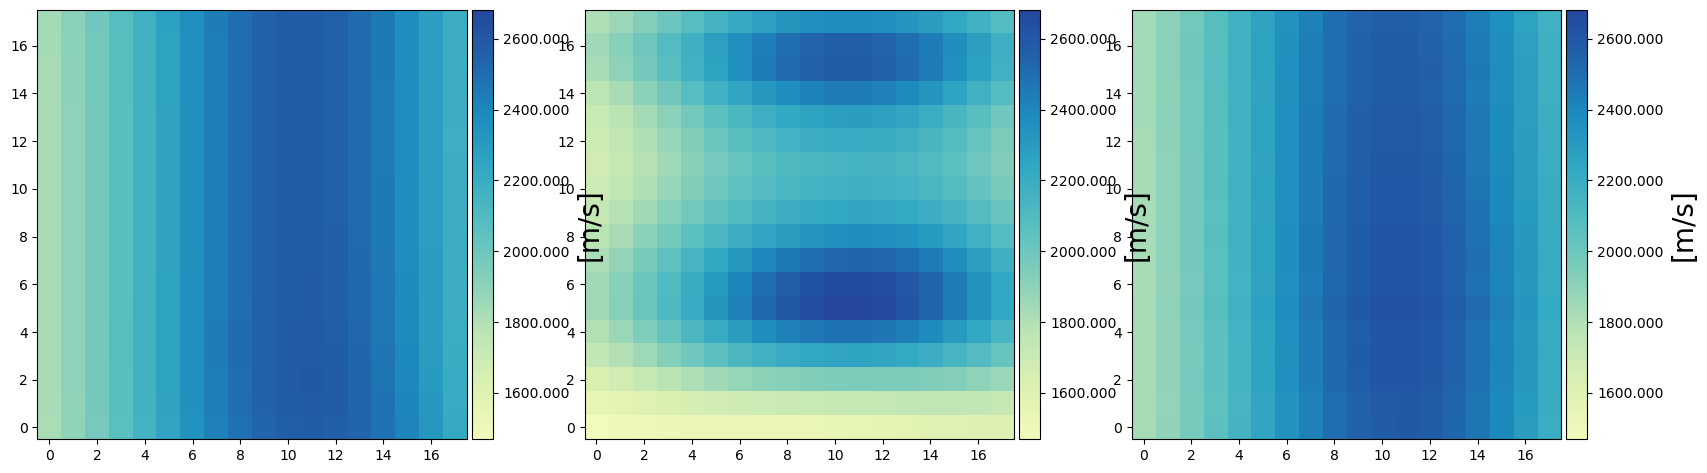

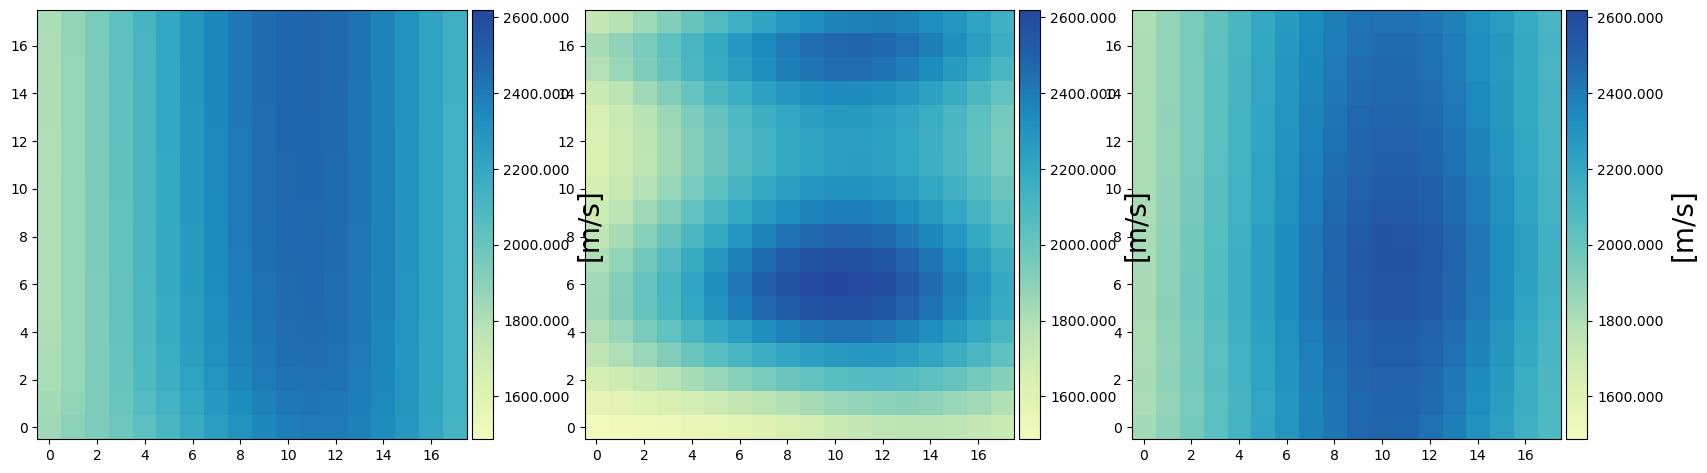

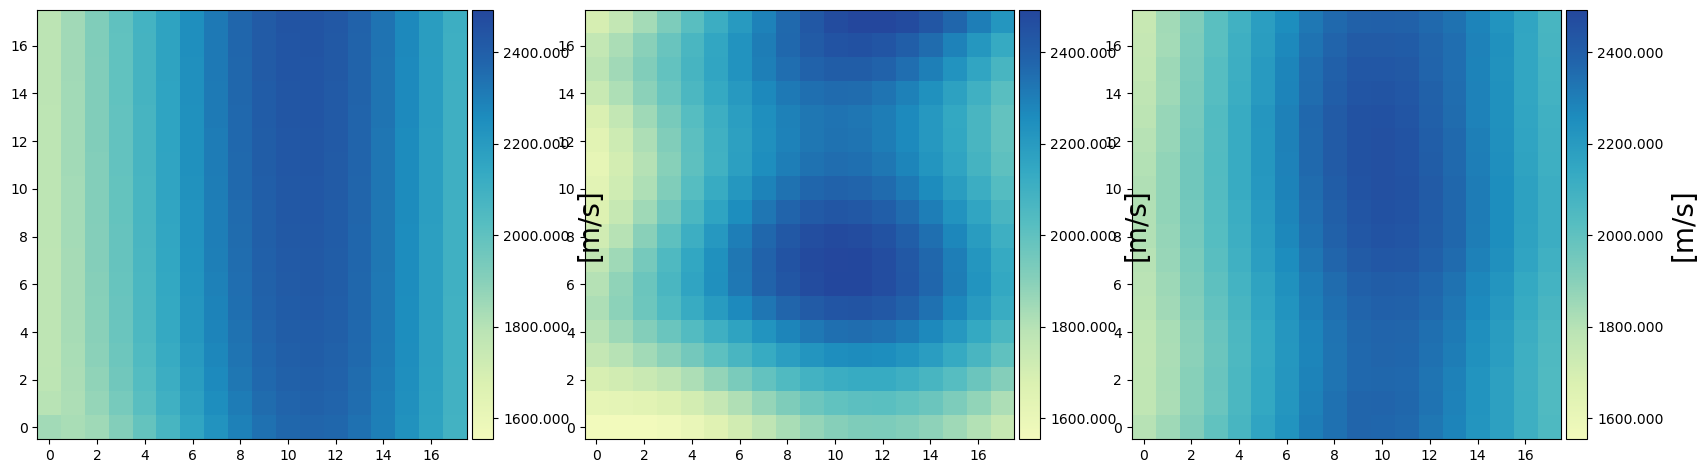

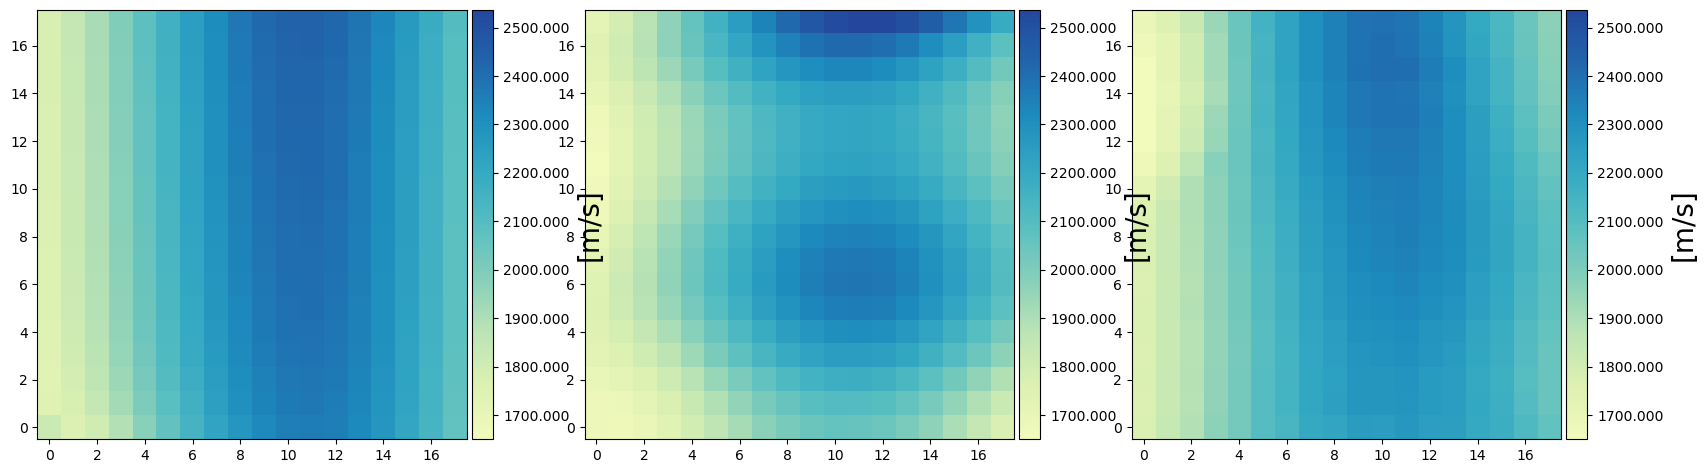

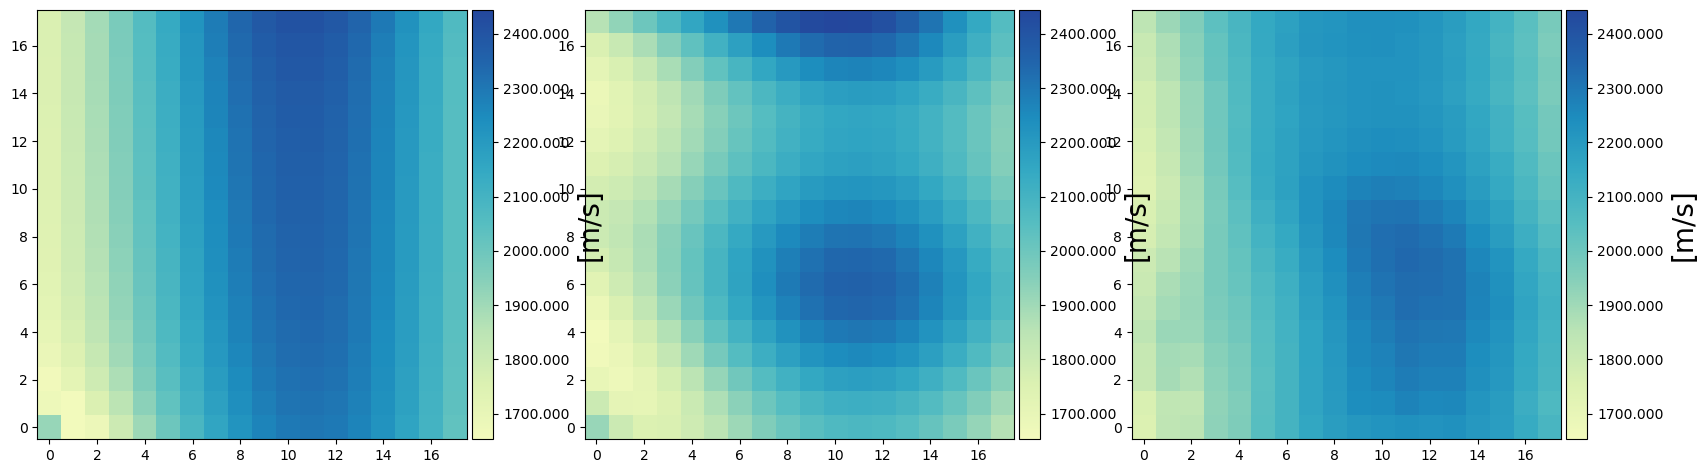

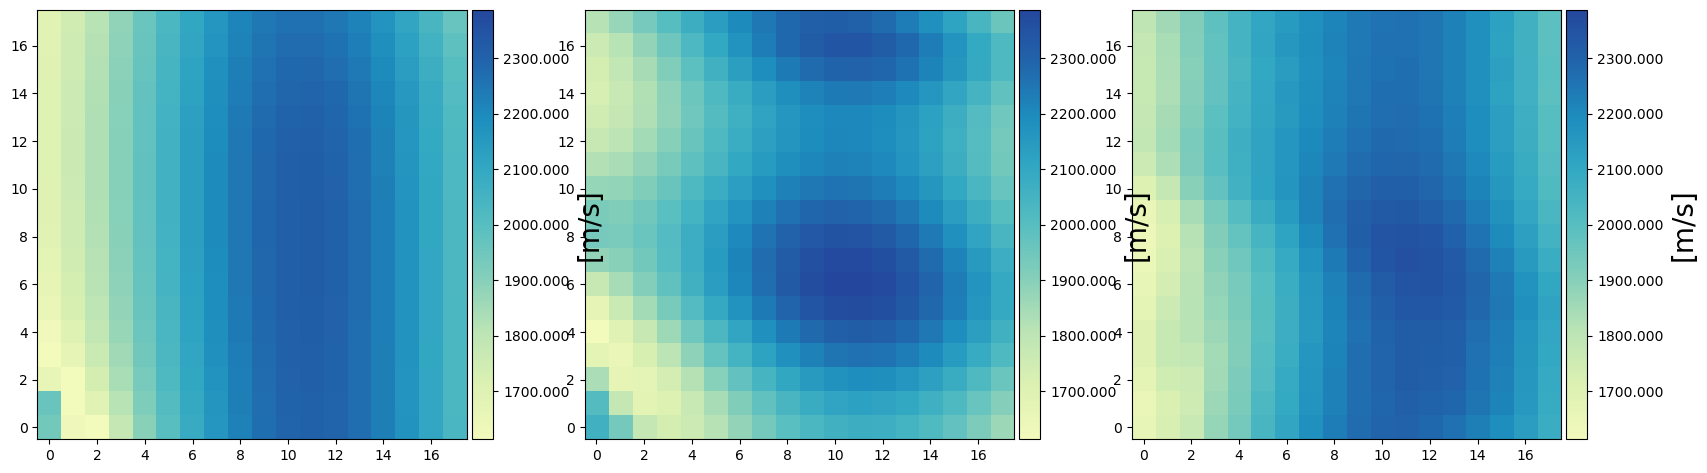

In [54]:
for i in range(0,length):
    #i=6

    print(fff[i],'Hz')
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,18),ncols=3)
    im1=ax1.imshow(C_BASE[i,1:-1,1:-1],cmap=YlGnBu,origin='lower',vmin=np.min(C_HELM[i,1:-1,1:-1]),vmax=np.max(C_HELM[i,1:-1,1:-1]))
    divider = make_axes_locatable(ax1)
    ax11 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im1, format='%.3f',cax=ax11)
    cbar.set_label(label='[m/s]',size=20)
    im2=ax2.imshow(C_HELM[i,1:-1,1:-1],cmap=YlGnBu,origin='lower',vmin=np.min(C_HELM[i,1:-1,1:-1]),vmax=np.max(C_HELM[i,1:-1,1:-1]))
    divider = make_axes_locatable(ax2)
    ax22 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im2, format='%.3f',cax=ax22)
    cbar.set_label(label='[m/s]',size=20)
    im3=ax3.imshow(C_ACC[i,1:-1,1:-1],cmap=YlGnBu,origin='lower',vmin=np.min(C_HELM[i,1:-1,1:-1]),vmax=np.max(C_HELM[i,1:-1,1:-1]))
    divider = make_axes_locatable(ax3)
    ax33 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im3, format='%.3f',cax=ax33)
    cbar.set_label(label='[m/s]',size=20)

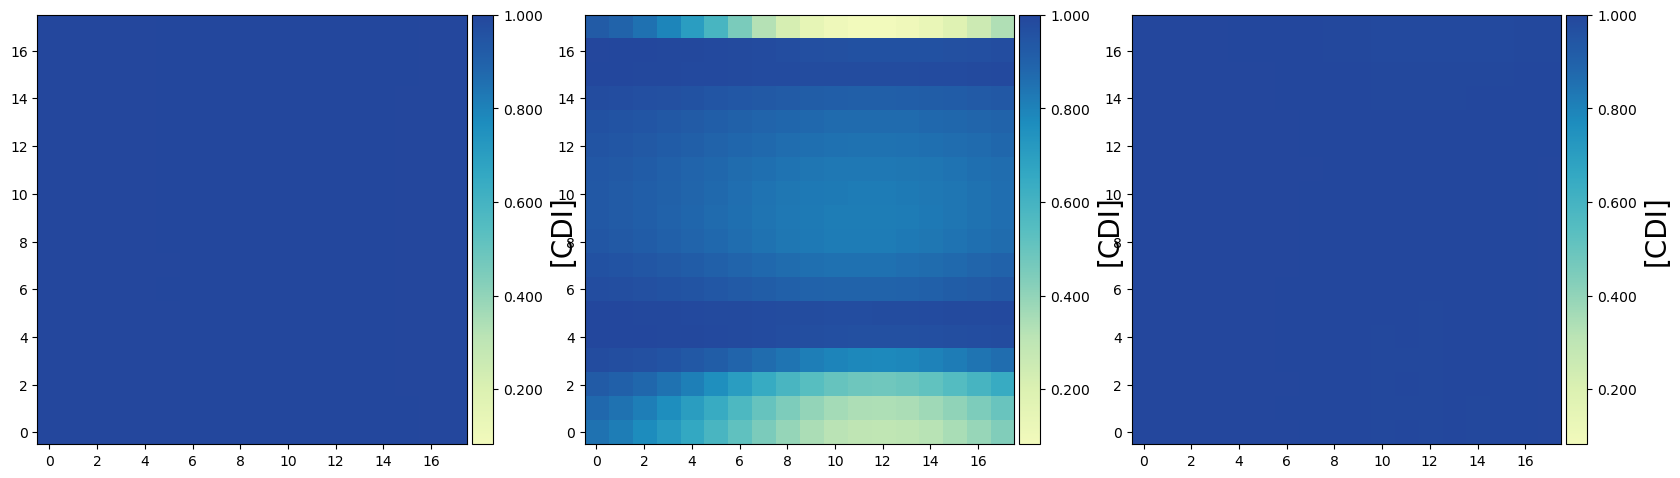

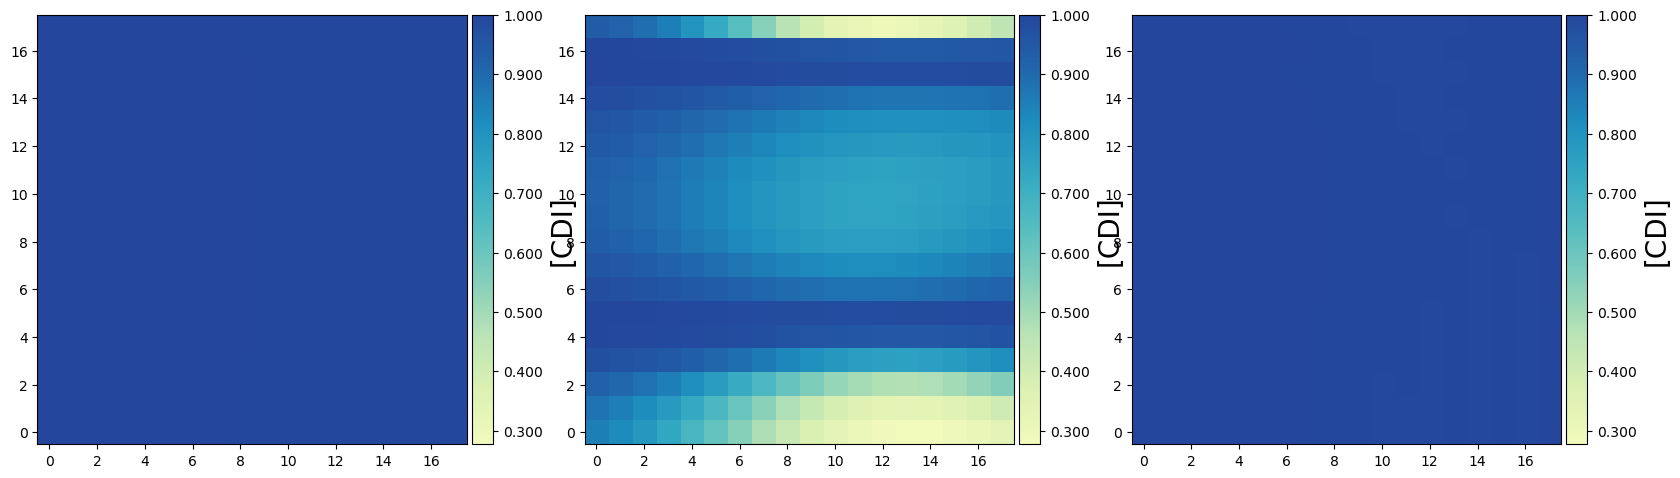

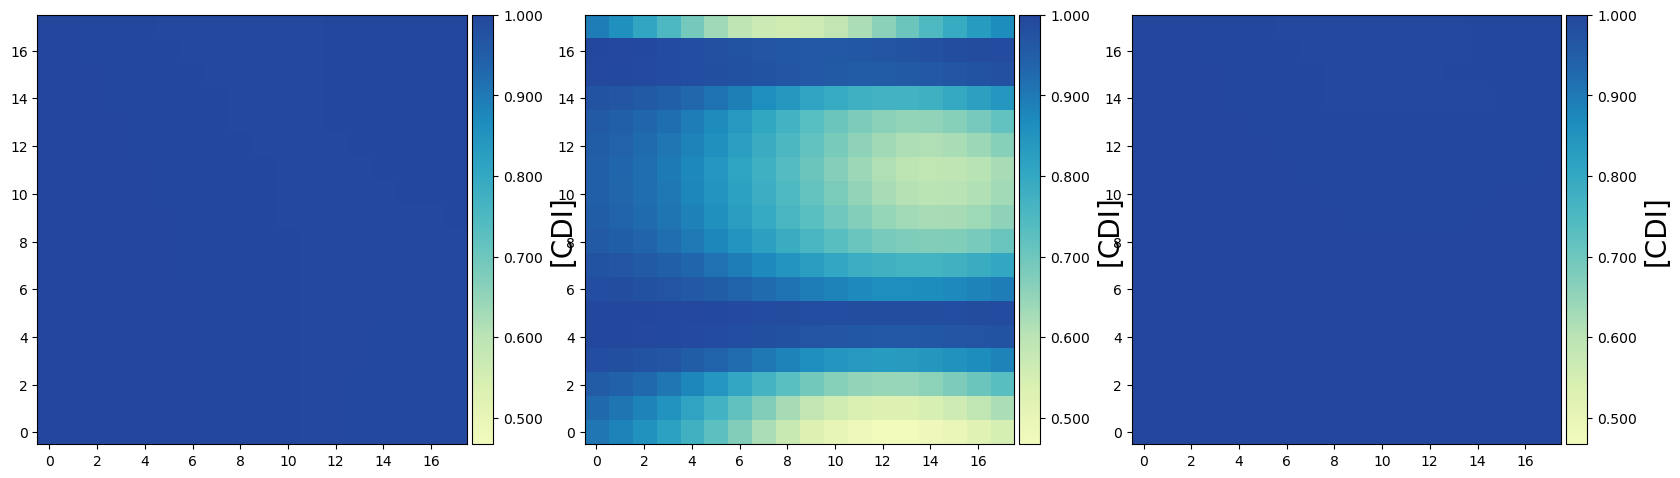

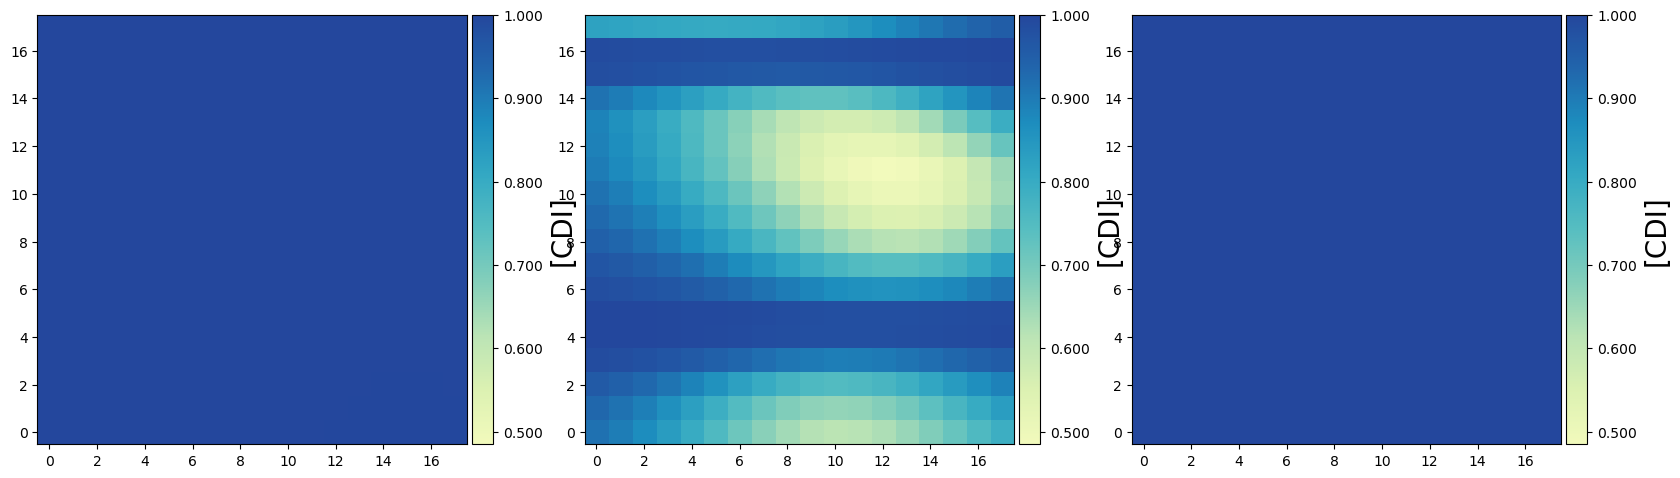

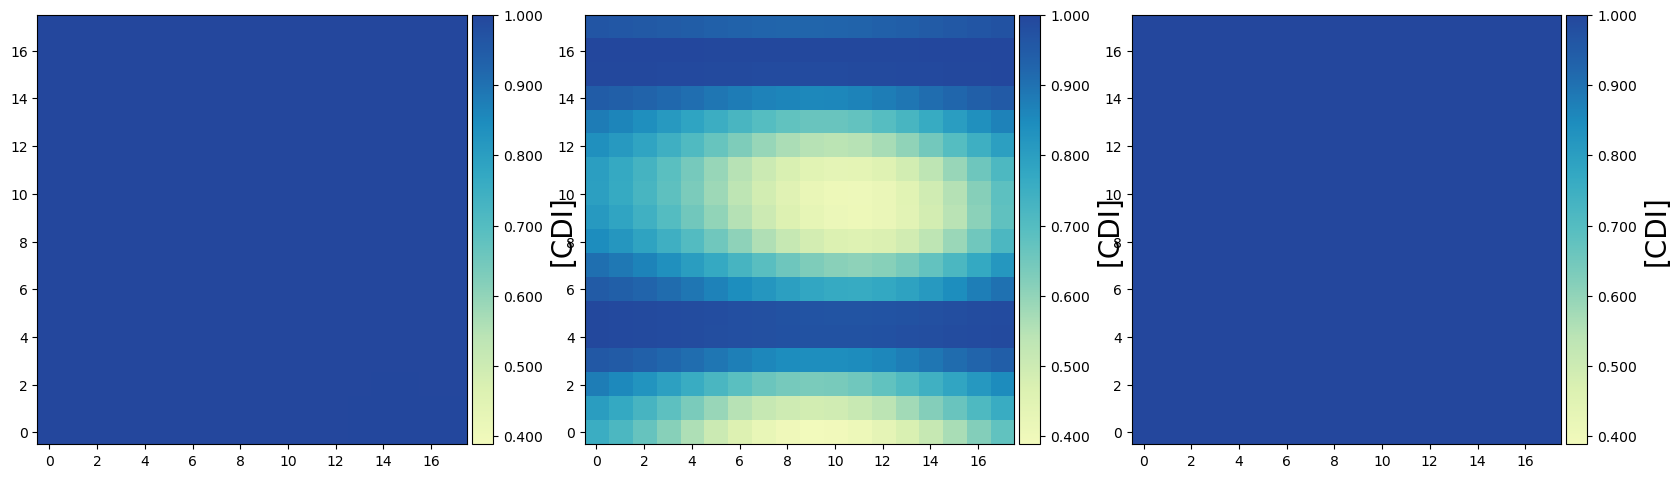

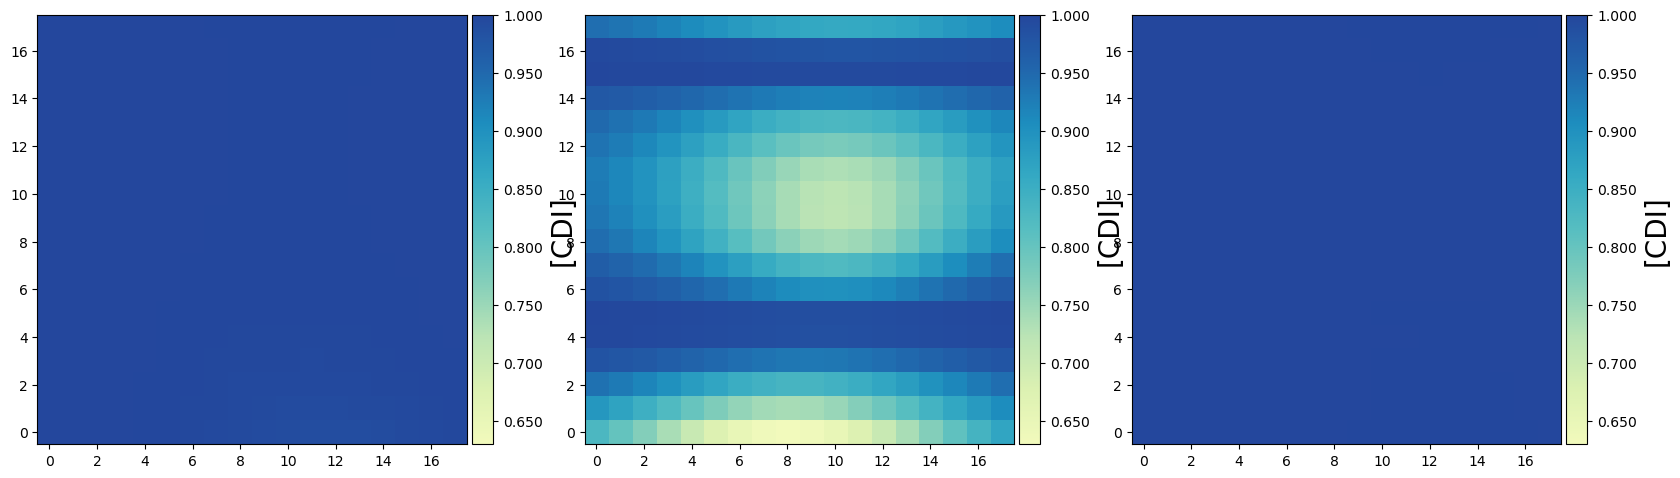

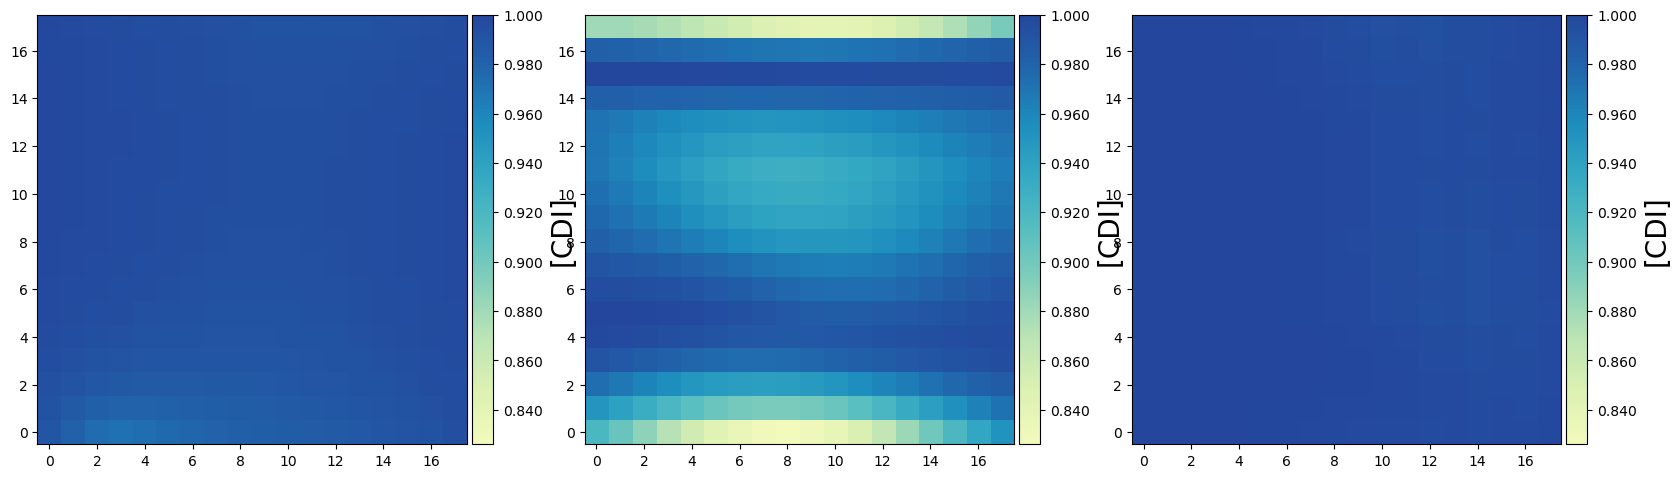

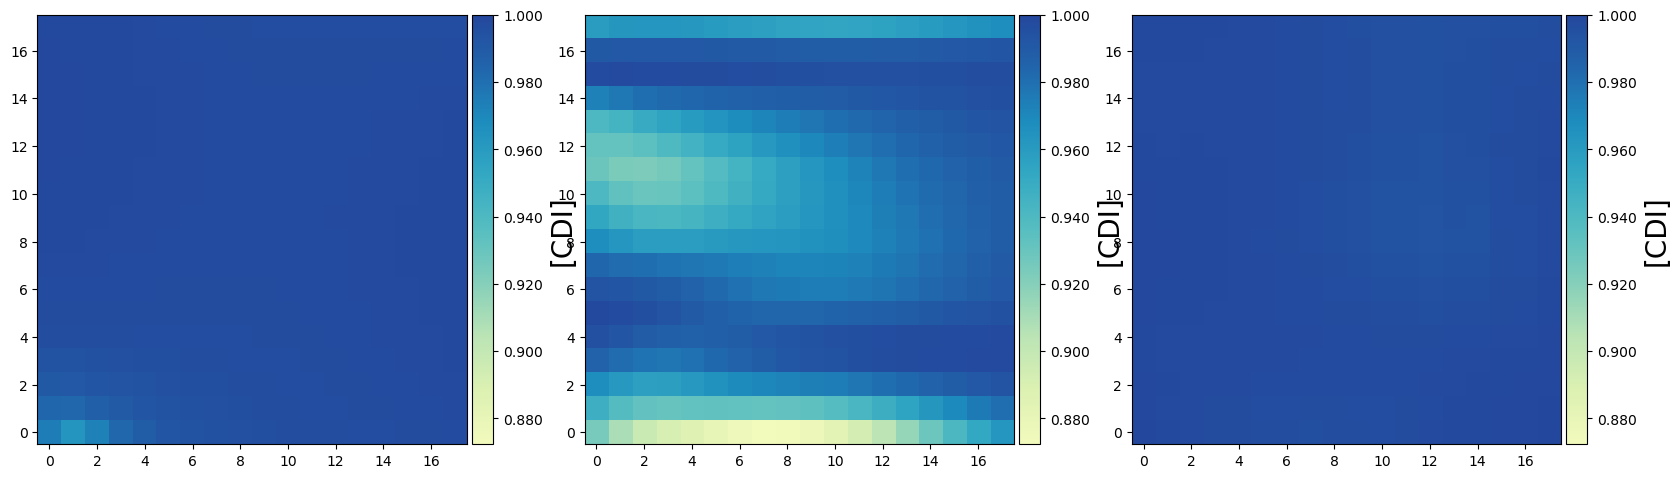

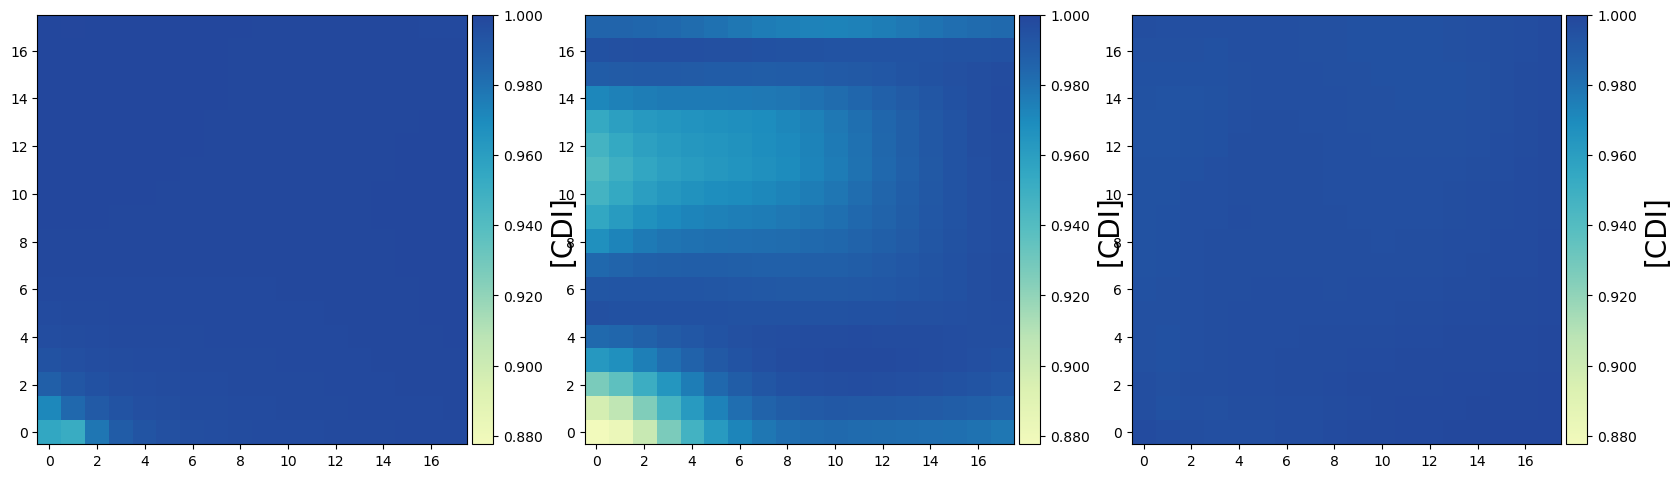

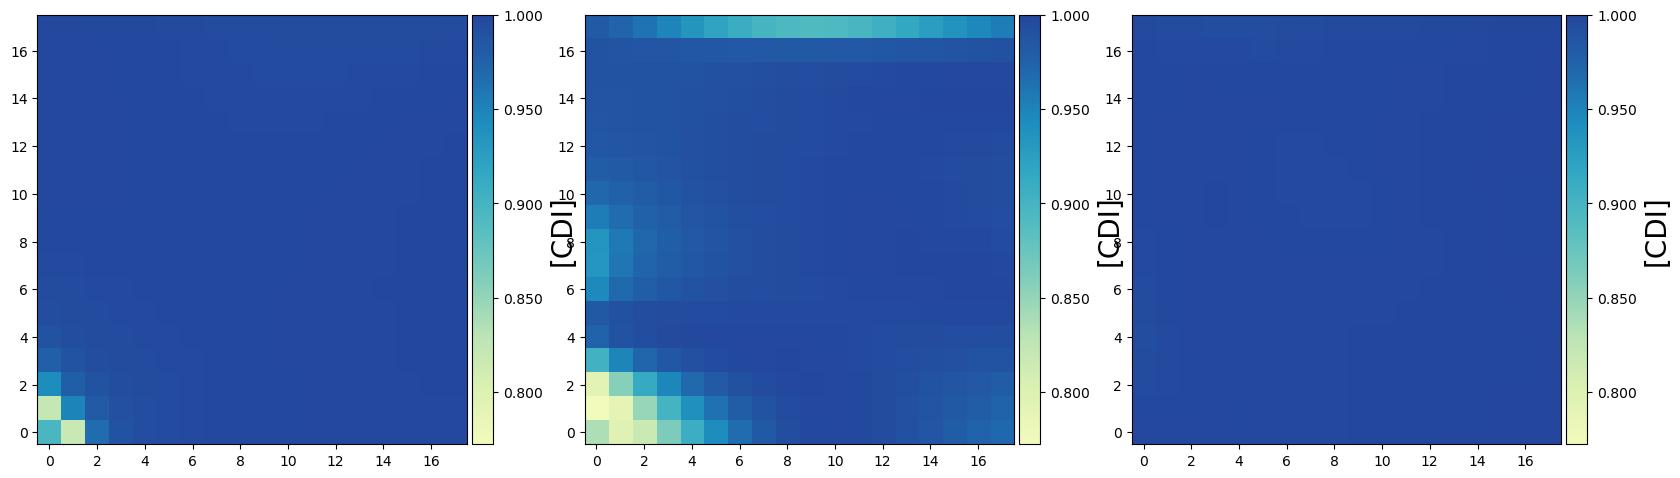

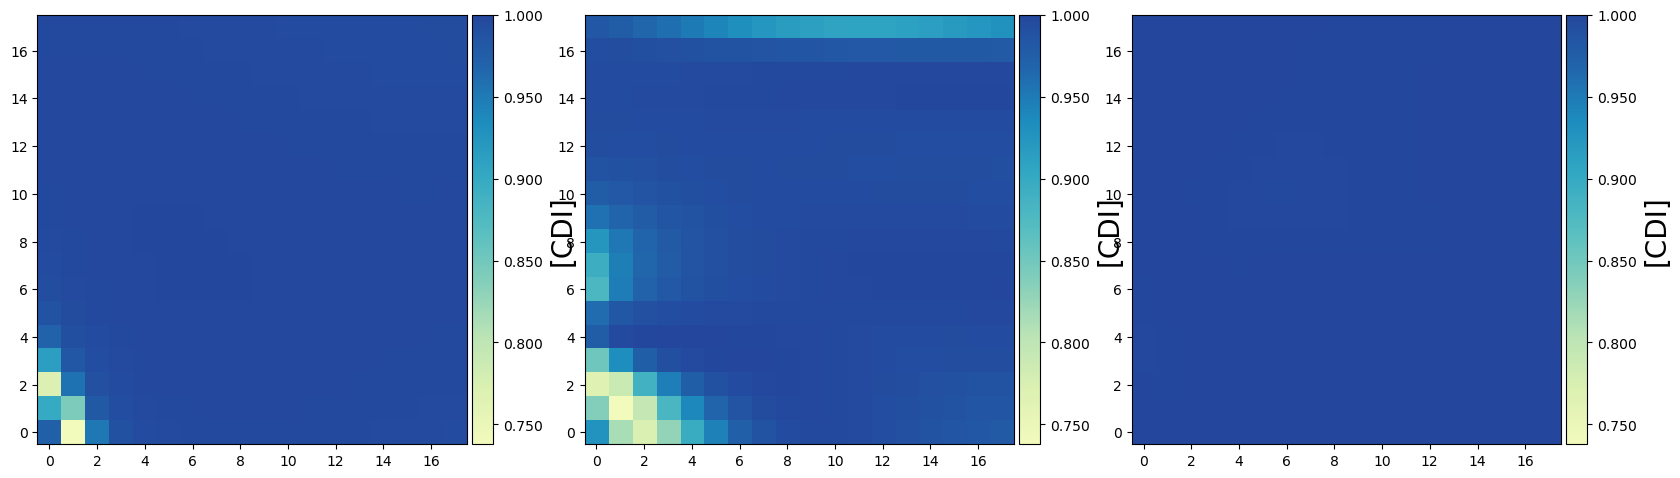

In [55]:
for i in range(0,length):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,18),ncols=3)
    im1=ax1.imshow(RSQ_BASE[i,1:-1,1:-1],cmap=YlGnBu,origin='lower',vmin=np.min(RSQ_HELM[i,1:-1,1:-1]),vmax=1)
    divider = make_axes_locatable(ax1)
    ax11 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im1, format='%.3f',cax=ax11)
    cbar.set_label(label='[CDI]',size=20)
    im2=ax2.imshow(RSQ_HELM[i,1:-1,1:-1],cmap=YlGnBu,origin='lower',vmin=np.min(RSQ_HELM[i,1:-1,1:-1]),vmax=1)
    divider = make_axes_locatable(ax2)
    ax22 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im2, format='%.3f',cax=ax22)
    cbar.set_label(label='[CDI]',size=20)
    im3=ax3.imshow(RSQ_ACC[i,1:-1,1:-1],cmap=YlGnBu,origin='lower',vmin=np.min(RSQ_HELM[i,1:-1,1:-1]),vmax=1)
    divider = make_axes_locatable(ax3)
    ax33 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im3, format='%.3f',cax=ax33)
    cbar.set_label(label='[CDI]',size=20)

(3.8, 14.2)

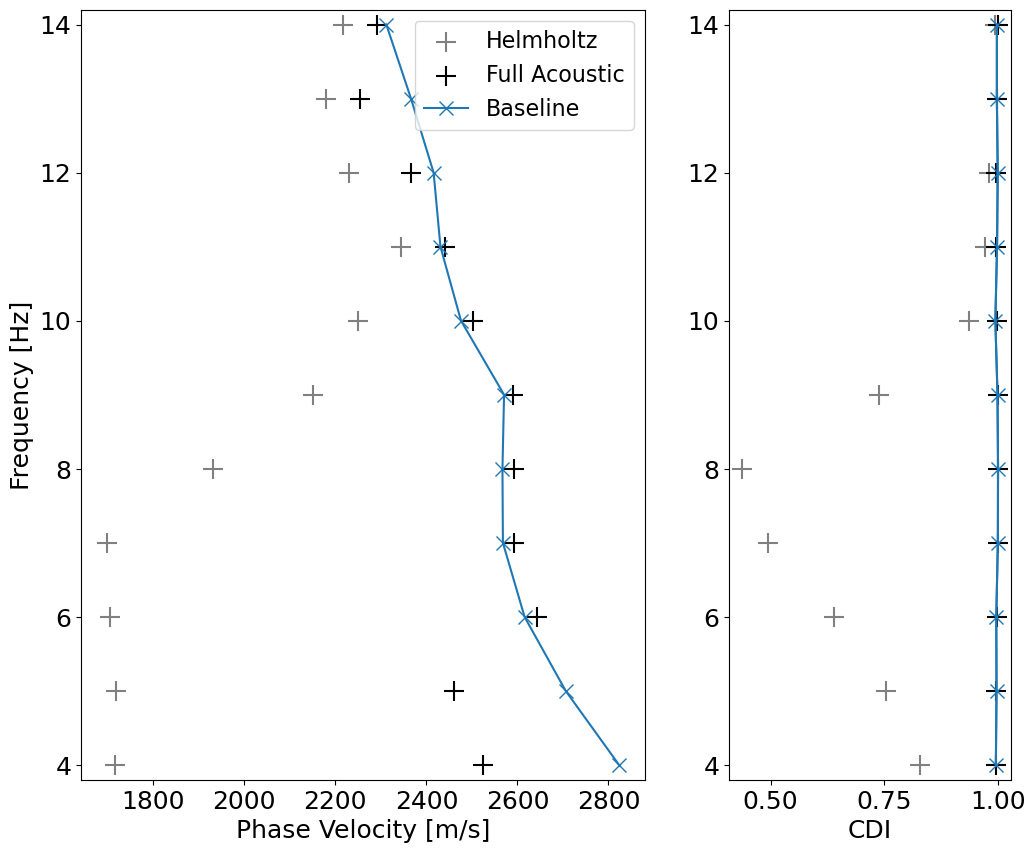

In [56]:
posX =12
posY =12
gif, (ax1,ax2) = plt.subplots(figsize=(12,10),ncols=2,gridspec_kw={'width_ratios': [2, 1]})
ax1.scatter(C_HELM[:,posX,posY],fff,marker='+', label='Helmholtz',s=220, color='grey')
ax1.scatter(C_ACC[:,posX,posY],fff,marker='+', label='Full Acoustic',s=220, color='black')
#ax1.scatter(C_BASE[:,posX,posY],fff,marker='+',s=220)
ax1.plot(C_BASE[:,posX,posY],fff, color='tab:blue',marker='x', markersize=10, label='Baseline')
ax1.legend(fontsize=16,loc='upper right')

ax2.scatter(RSQ_HELM[:,posX,posY],fff,marker='+',s=220, color='grey')
ax2.scatter(RSQ_ACC[:,posX,posY],fff,marker='+',s=220, color='black')
ax2.plot(RSQ_BASE[:,posX,posY],fff,marker='x',markersize=10)
ax2.plot(RSQ_BASE[:,posX,posY],fff, color='tab:blue')

ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('Phase Velocity [m/s]',fontsize=18)
ax2.set_xlabel('CDI',fontsize=18)
ax1.set_ylabel('Frequency [Hz]',fontsize=18)
ax1.set_ylim([3.8,14.2])
ax2.set_ylim([3.8,14.2])

In [57]:
fff


array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [58]:
##Mentioned in Paper!!
print(C_BASE[4,12,12])
print(C_ACC[4,12,12])

2567.0697677975318
2591.911766500936


(3.8, 14.2)

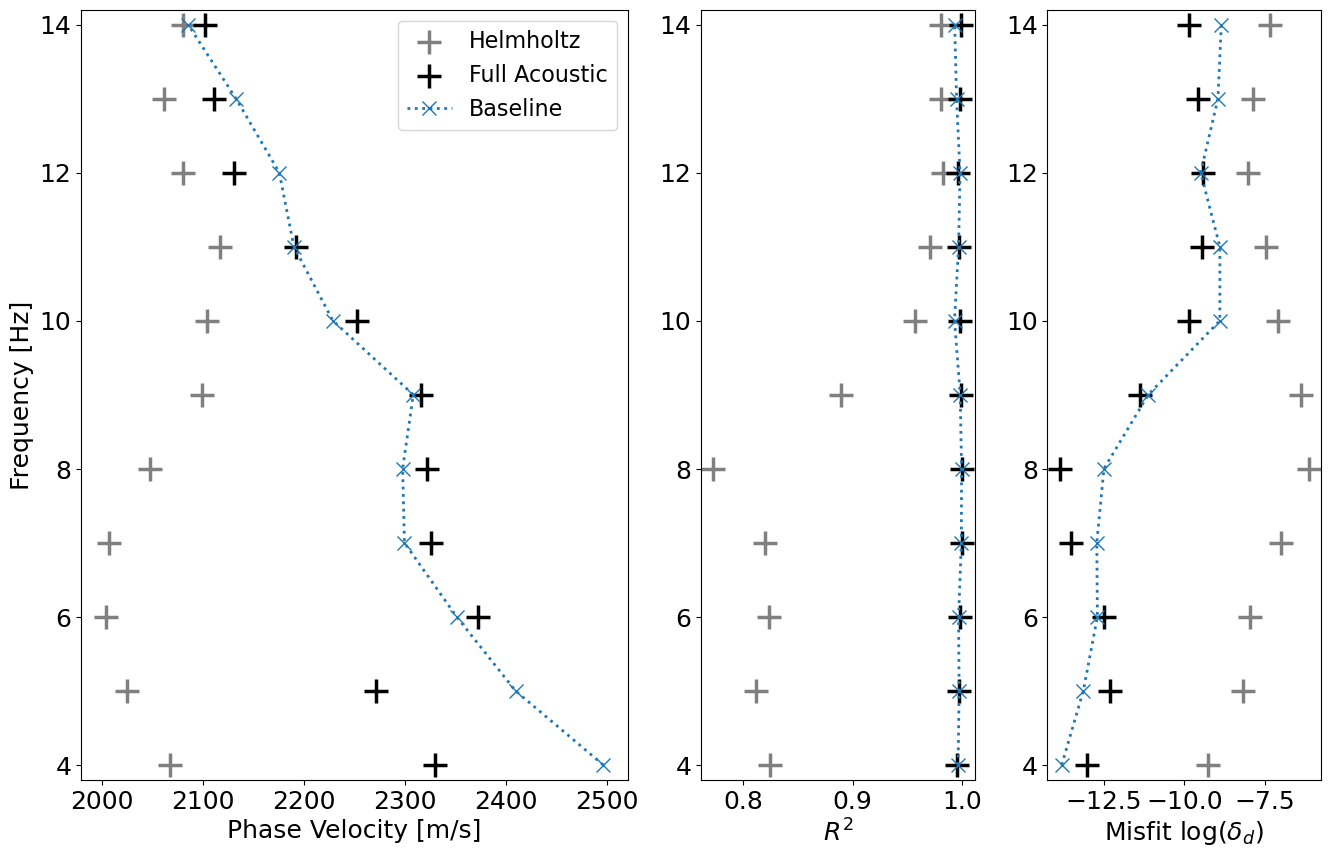

In [59]:
C_HELM_MEAN = np.zeros((length))
C_ACC_MEAN = np.zeros((length))
C_ACC_TRUE_MEAN = np.zeros((length))
C_BASE_MEAN = np.zeros((length))
RSQ_HELM_MEAN = np.zeros((length))
RSQ_ACC_MEAN = np.zeros((length))
RSQ_ACC_TRUE_MEAN = np.zeros((length))
RSQ_BASE_MEAN = np.zeros((length))
MIS_HELM_MEAN = np.zeros((length))
MIS_ACC_MEAN = np.zeros((length))
MIS_ACC_TRUE_MEAN = np.zeros((length))
MIS_BASE_MEAN = np.zeros((length))
    
gif, (ax1,ax2,ax3) = plt.subplots(figsize=(16,10),ncols=3,gridspec_kw={'width_ratios': [4,2, 2]})
for i in range(0,length):
    C_HELM_MEAN[i] = np.mean(C_HELM[i,1:-1,1:-1])
    C_ACC_MEAN[i] = np.mean(C_ACC[i,1:-1,1:-1])
    C_ACC_TRUE_MEAN[i] = np.mean(C_ACC_TRUE[i,1:-1,1:-1])
    C_BASE_MEAN[i] = np.mean(C_BASE[i,1:-1,1:-1])
    
    RSQ_HELM_MEAN[i] = np.mean(RSQ_HELM[i,1:-1,1:-1])
    RSQ_ACC_MEAN[i] = np.mean(RSQ_ACC[i,1:-1,1:-1])
    RSQ_ACC_TRUE_MEAN[i] = np.mean(RSQ_ACC_TRUE[i,1:-1,1:-1])
    RSQ_BASE_MEAN[i] = np.mean(RSQ_BASE[i,1:-1,1:-1])
    
    MIS_HELM_MEAN[i] = np.mean(MIS_HELM[i,1:-1,1:-1])
    MIS_ACC_MEAN[i] = np.mean(MIS_ACC[i,1:-1,1:-1])
    MIS_ACC_TRUE_MEAN[i] = np.mean(MIS_ACC_TRUE[i,1:-1,1:-1])
    MIS_BASE_MEAN[i] = np.mean(MIS_BASE[i,1:-1,1:-1])
    
    
ax1.scatter(C_HELM_MEAN,fff,marker='+', label='Helmholtz',s=280, color='grey', linewidth=2.5)
ax1.scatter(C_ACC_MEAN,fff,marker='+', label='Full Acoustic',s=280, color='black', linewidth=2.5)
#ax1.scatter(C_BASE_MEAN,fff,marker='+', label='Baseline',s=200, linewidth=2)
#ax1.plot(C_BASE_MEAN,fff, color='tab:blue',linestyle=':')
ax1.plot(C_BASE_MEAN,fff, color='tab:blue',marker='x', markersize=10, label='Baseline',linestyle=':', linewidth=2)

#ax1.scatter(C_ACC_TRUE_MEAN,fff,marker='+', label='True Full Acoustic',s=280, color='tab:green')
#ax1.plot(C_ACC_TRUE_MEAN,fff, color='tab:green')
ax1.legend(fontsize=16,loc='upper right')

ax2.scatter(RSQ_HELM_MEAN,fff,marker='+',s=280, color='grey', linewidth=2.5)
ax2.scatter(RSQ_ACC_MEAN,fff,marker='+',s=280, color='black', linewidth=2.5)
#ax2.scatter(RSQ_BASE_MEAN,fff,marker='+',s=200, linewidth=2)
ax2.plot(RSQ_BASE_MEAN,fff, color='tab:blue',linestyle=':',marker='x',markersize=10, linewidth=2)
#ax2.scatter(RSQ_ACC_TRUE_MEAN,fff,marker='+', label='True Full Acoustic',s=280, color='tab:green')
#ax2.plot(RSQ_ACC_TRUE_MEAN,fff, color='tab:green')

ax3.scatter(np.log(MIS_HELM_MEAN),fff,marker='+',s=280, color='grey', linewidth=2.5)
ax3.scatter(np.log(MIS_ACC_MEAN),fff,marker='+',s=280, color='black', linewidth=2.5)
#ax3.scatter(np.log(MIS_BASE_MEAN),fff,marker='+',s=200, linewidth=2)
ax3.plot(np.log(MIS_BASE_MEAN),fff, color='tab:blue',linestyle=':',marker='x',markersize=10, linewidth=2)
#ax3.scatter(np.log(MIS_ACC_TRUE_MEAN),fff,marker='o',s=20, color='tab:orange')
#ax3.plot(np.log(MIS_ACC_TRUE_MEAN),fff, color='tab:orange',linestyle=':', linewidth=1.5)

ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('Phase Velocity [m/s]',fontsize=18)
ax2.set_xlabel(r'$R^{2}$',fontsize=18)
ax3.set_xlabel(r'Misfit log($\delta_{d}$)',fontsize=18)
ax1.set_ylabel('Frequency [Hz]',fontsize=18)
ax1.set_ylim([3.8,14.2])
ax2.set_ylim([3.8,14.2])
ax3.set_ylim([3.8,14.2])

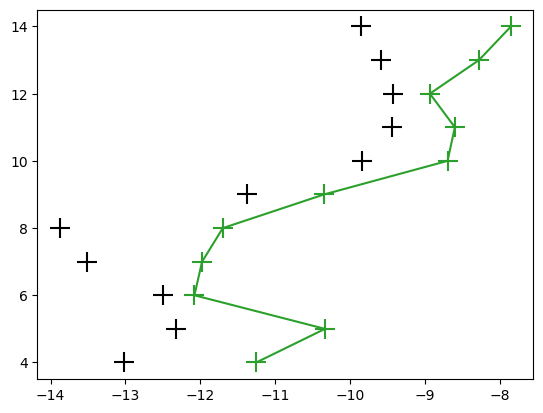

In [60]:
#ax3.scatter(np.log(MIS_HELM_MEAN),fff,marker='+',s=220, color='grey')
plt.scatter(np.log(MIS_ACC_MEAN),fff,marker='+',s=220, color='black')
#ax3.scatter(np.log(MIS_BASE_MEAN),fff,marker='+',s=220)
#ax3.plot(np.log(MIS_BASE_MEAN),fff, color='tab:blue')
plt.scatter(np.log(MIS_ACC_TRUE_MEAN),fff,marker='+',s=220, color='tab:green')
plt.plot(np.log(MIS_ACC_TRUE_MEAN),fff, color='tab:green')

In [61]:
MIS_ACC_MEAN

array([2.21564660e-06, 4.42001460e-06, 3.71654174e-06, 1.35097512e-06,
       9.44099808e-07, 1.15168880e-05, 5.28826811e-05, 7.89371212e-05,
       8.04714109e-05, 6.81304495e-05, 5.24358889e-05])

In [62]:
import seaborn as sns
palette = sns.color_palette("Greys", 10).as_hex()
print(palette)
ccc=['#0f2577', '#1f557b', '#2e7b7f', '#3a8c66', '#45994a', '#76a652', '#9db059', '#bab061', '#caa87b', '#e3c3b6']#gist_earth
#ccc=['#f7f7e7', '#efefcc', '#e7e5b2', '#decfa6', '#d5b89a', '#cb9e8c', '#c27e7e', '#a76c6c', '#8a5858', '#643e3e']#pink_r
#ccc=['#f4f4f4', '#e6e6e6', '#d4d4d4', '#bfbfbf', '#a4a4a4', '#898989', '#707070', '#575757', '#393939', '#1b1b1b']#greys
vir=LinearSegmentedColormap.from_list("mycmap", ccc)

['#f4f4f4', '#e6e6e6', '#d4d4d4', '#bfbfbf', '#a4a4a4', '#898989', '#707070', '#575757', '#393939', '#1b1b1b']


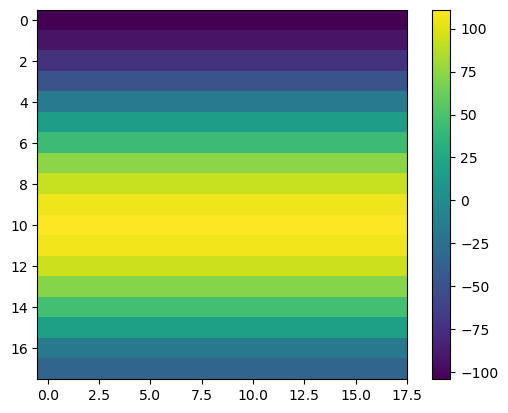

In [63]:
plt.imshow(np.gradient(rho_grad[1:-1,1:-1,0])[0])
plt.colorbar()

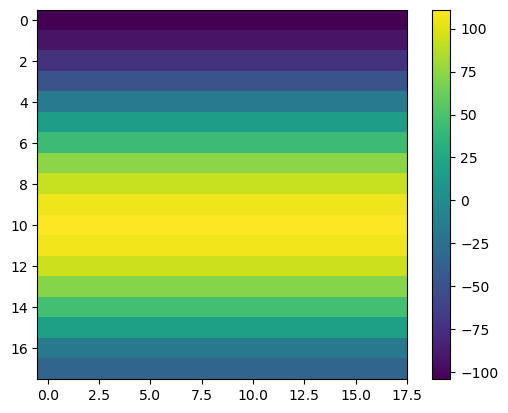

In [64]:
plt.imshow(np.gradient(rho_grad[1:-1,1:-1,0])[0])
plt.colorbar()

In [65]:
RHO_ACC = np.zeros((length,nr,nr)) 
PARA_ERROR = np.zeros((length,nr-2,nr-2)) 
PARA_ERROR_MEAN = np.zeros((length))
RHO_ACC_MEAN_Y = np.zeros((length,nr-2))
RHO_ACC_MEAN_X = np.zeros((length,nr-2))
C_ACC_MEAN_Y = np.zeros((length,nr-2))
C_ACC_MEAN_X = np.zeros((length,nr-2))
C_HELM_MEAN_Y = np.zeros((length,nr-2))
C_HELM_MEAN_X = np.zeros((length,nr-2))

i=0
for ff in fff: 
    RHO_ACC[i,:,:] = pd.read_csv(fig_+'/rho_inv_minMIS'+'_'+str(ff)).values
    PARA_ERROR[i,:,:] = 100*(abs(RHO_ACC[i,1:-1,1:-1] - rho_grad[1:-1,1:-1,0] ) /rho_grad[1:-1,1:-1,0])#.sum().sum()
    PARA_ERROR_MEAN[i] = (1/(nr-2)**2)*PARA_ERROR[i,:,:].sum().sum()
    RHO_ACC_MEAN_Y[i,:] = RHO_ACC[i,1:-1,1:-1].sum(1)/(nr-2)
    RHO_ACC_MEAN_X[i,:] = RHO_ACC[i,1:-1,1:-1].sum(0)/(nr-2)
    
    C_ACC_MEAN_Y[i,:] = C_ACC[i,1:-1,1:-1].sum(1)/(nr-2)
    C_ACC_MEAN_X[i,:] = C_ACC[i,1:-1,1:-1].sum(0)/(nr-2)
    C_HELM_MEAN_Y[i,:] = C_HELM[i,1:-1,1:-1].sum(1)/(nr-2)
    C_HELM_MEAN_X[i,:] = C_HELM[i,1:-1,1:-1].sum(0)/(nr-2)
    i=i+1
    


In [66]:
rho_GRAD_X_true  = np.empty((nr, nr))
rho_GRAD_Y_true  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD_X_true[l, :] = (rho_grad[l+1,:,0] - rho_grad[l-1,:,0])/(dist_r*2)
for k in range(1,nr-1):
                rho_GRAD_Y_true[:,k] = (rho_grad[:,k+1,0] -  rho_grad[:,k-1,0])/(dist_r*2)
rho_GRAD_true = rho_GRAD_X_true + rho_GRAD_Y_true

rho_GRAD_X_true_scaled  = np.empty((nr, nr))
rho_GRAD_Y_true_scaled  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD_X_true_scaled[l, :] = 100*(rho_grad[l+1,:,0] - rho_grad[l-1,:,0])/(dist_r*2*rho_grad[l,:,0])
for k in range(1,nr-1):
                rho_GRAD_Y_true_scaled[:,k] = 100*(rho_grad[:,k+1,0] -  rho_grad[:,k-1,0])/(dist_r*2*rho_grad[:,k,0])
rho_GRAD_true_scaled = rho_GRAD_X_true_scaled + rho_GRAD_Y_true_scaled


store_grad_X  = np.zeros((len(fff), nr,nr))
store_grad_Y  = np.zeros((len(fff),nr,nr))
store_grad_X_scaled  = np.empty((len(fff),nr, nr))
store_grad_Y_scaled  = np.empty((len(fff),nr, nr))


for jj in np.arange(0,len(fff),1): 
    for l in range(1,nr-1):
                    store_grad_X[jj,l,:] = (RHO_ACC[jj,l+1,:] - RHO_ACC[jj,l-1,:])/(dist_r*2)
    for k in range(1,nr-1):
                    store_grad_Y[jj,:,k] = (RHO_ACC[jj,:,k+1] - RHO_ACC[jj,:,k-1])/(dist_r*2)


    for l in range(1,nr-1):
                    store_grad_X_scaled[jj,l, :] = 100*(RHO_ACC[jj,l+1,:] - RHO_ACC[jj,l-1,:])/(dist_r*2*RHO_ACC[jj,l,:])
    for k in range(1,nr-1):
                    store_grad_Y_scaled[jj,:,k] = 100*(RHO_ACC[jj,:,k+1] -  RHO_ACC[jj,:,k-1])/(dist_r*2*RHO_ACC[jj,:,k])
            
store_grad = store_grad_X + store_grad_Y
store_grad_scaled = store_grad_X_scaled + store_grad_Y_scaled

In [67]:
rho_GRAD2_X_true  = np.empty((nr, nr))
rho_GRAD2_Y_true  = np.empty((nr, nr))

for l in range(1,nr-1):
                rho_GRAD2_X_true[l, :] = (rho_grad[l+1,:,0] - (2*rho_grad[l,:,0]) + rho_grad[l-1,:,0])/(dist_r**2)
for k in range(1,nr-1):
                rho_GRAD2_Y_true[:,k] = (rho_grad[:,k+1,0] - (2*rho_grad[:,k,0]) +  rho_grad[:,k-1,0])/(dist_r**2)
rho_GRAD2_true = rho_GRAD2_X_true + rho_GRAD2_Y_true


store_grad2_X  = np.zeros((len(fff), nr,nr))
store_grad2_Y  = np.zeros((len(fff),nr,nr))
for jj in np.arange(0,len(fff),1): 
    for l in range(1,nr-1):
                    store_grad2_X[jj,l,:] = (RHO_ACC[jj,l+1,:] - (2*RHO_ACC[jj,l,:]) + RHO_ACC[jj,l-1,:])/(dist_r**2)
    for k in range(1,nr-1):
                    store_grad2_Y[jj,:,k] = (RHO_ACC[jj,:,k+1] - (2*RHO_ACC[jj,:,k]) + RHO_ACC[jj,:,k-1])/(dist_r**2)
store_grad2 = store_grad2_X + store_grad2_Y

In [68]:
np.gradient(np.gradient(rho_grad[1:-1,1:-1,0].sum(1)))

array([ 200.65284003,  280.87893514,  397.66527668,  521.60746329,
        575.94419445,  526.13959058,  523.22060866,  443.3025774 ,
        289.91008128,  162.12313424,    7.50724101, -147.63493945,
       -315.16830534, -428.89507278, -482.50017023, -578.54046556,
       -469.84637064, -303.84449394])

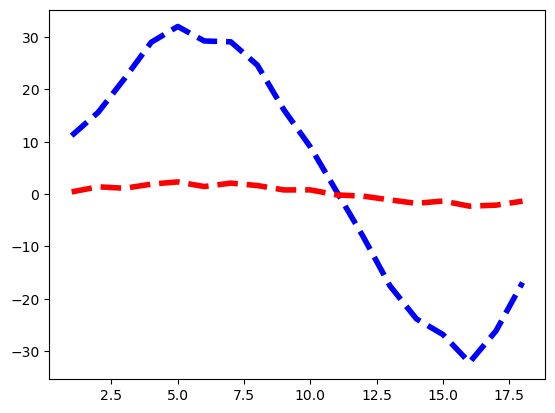

In [69]:
plt.plot(np.arange(1,nr-1),np.gradient((np.gradient(rho_grad[1:-1,1:-1,0].sum(1)).T.flatten()/18)), linewidth=4, color='blue', label = 'True model', linestyle='--')
plt.plot(np.arange(1,nr-1),rho_GRAD2_X_true[1:-1,1:-1].sum(1).T.flatten()/18, linewidth=4, color='red', label = 'True model', linestyle='--')


In [70]:
PARA_ERROR_GRAD = np.zeros((length,nr,nr)) 
PARA_ERROR_MEAN_GRAD = np.zeros((length))
PARA_ERROR_GRADX = np.zeros((length,nr,nr)) 
PARA_ERROR_MEAN_GRADX = np.zeros((length))
PARA_ERROR_GRADY = np.zeros((length,nr,nr)) 
PARA_ERROR_MEAN_GRADY = np.zeros((length))

PARA_ERROR_GRAD2 = np.zeros((length,nr,nr)) 
PARA_ERROR_MEAN_GRAD2 = np.zeros((length))
PARA_ERROR_GRAD2X = np.zeros((length,nr,nr)) 
PARA_ERROR_MEAN_GRAD2X = np.zeros((length))
PARA_ERROR_GRAD2Y = np.zeros((length,nr,nr)) 
PARA_ERROR_MEAN_GRAD2Y = np.zeros((length))

i=0
for ff in fff: 
#     PARA_ERROR_GRADX[i,:,:] = ((abs(store_grad_X[i,:,:]+1 ) - abs(np.gradient(rho_grad[:,:,0])[0]+1 )) / abs(np.gradient(rho_grad[:,:,0])[0]+1) )#.sum().sum()
#     PARA_ERROR_MEAN_GRADX[i] = 100*abs(PARA_ERROR_GRADX[i,1:-1,1:-1]).sum().sum() /(nr-2)**2   
#     PARA_ERROR_GRADY[i,:,:] = ((abs(store_grad_Y[i,:,:]+1)- abs(np.gradient(rho_grad[:,:,0])[1]+1 ) ) / abs(np.gradient(rho_grad[:,:,0])[1]+1) )#.sum().sum()
#     PARA_ERROR_MEAN_GRADY[i] = 100*abs(PARA_ERROR_GRADY[i,1:-1,1:-1]).sum().sum()/(nr-2)**2   
#     PARA_ERROR_GRAD[i,:,:] = ((abs(store_grad[i,:,:])- abs(np.asarray(np.gradient(rho_grad[:,:,0])).sum(0)) )/ abs(np.asarray(np.gradient(rho_grad[:,:,0])).sum(0)) )#.sum().sum()
#     PARA_ERROR_MEAN_GRAD[i] = 100*abs(PARA_ERROR_GRAD[i,1:-1,1:-1]).sum().sum()/(nr-2)**2   
    #error_sumX = 100*(abs(abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1) - abs(store_grad_X[:,1:-1,1:-1]+1))/abs(rho_GRAD_X_true[np.newaxis,1:-1,1:-1]+1)).sum(2).sum(1)/(nr-2)**2

    PARA_ERROR_GRADX[i,:,:] = (abs(store_grad_X_scaled[i,:,:] ) - abs(rho_GRAD_X_true_scaled[:,:])) / abs(rho_GRAD_X_true_scaled[:,:])#.sum().sum()
    PARA_ERROR_MEAN_GRADX[i] = 100*abs(PARA_ERROR_GRADX[i,1:-1,1:-1]).sum().sum() /(nr-2)**2   
    PARA_ERROR_GRADY[i,:,:] = (abs(store_grad_Y_scaled[i,:,:]+1)- abs(rho_GRAD_Y_true_scaled[:,:]+1 )) / abs(rho_GRAD_Y_true_scaled[:,:]+1)#.sum().sum()
    PARA_ERROR_MEAN_GRADY[i] = 100*abs(PARA_ERROR_GRADY[i,1:-1,1:-1]).sum().sum()/(nr-2)**2   
    PARA_ERROR_GRAD[i,:,:] = (abs(store_grad_scaled[i,:,:]+1)- abs(rho_GRAD_true_scaled[:,:]+1 ))/ abs(rho_GRAD_true_scaled[:,:]+1 )#.sum().sum()
    PARA_ERROR_MEAN_GRAD[i] = 100*abs(PARA_ERROR_GRAD[i,1:-1,1:-1]).mean(axis=0).mean(axis=0)   
    
    PARA_ERROR_GRAD2X[i,:,:] = (abs(store_grad2_X[i,:,:]+1 ) - abs(rho_GRAD2_X_true[:,:]+1)) / abs(rho_GRAD2_X_true[:,:]+1)#.sum().sum()
    PARA_ERROR_MEAN_GRAD2X[i] = 100*abs(PARA_ERROR_GRAD2X[i,1:-1,1:-1]).sum().sum() /(nr-2)**2   
    PARA_ERROR_GRAD2Y[i,:,:] = (abs(store_grad2_Y[i,:,:]+1)- abs(rho_GRAD2_Y_true[:,:]+1 )) / abs(rho_GRAD2_Y_true[:,:]+1)#.sum().sum()
    PARA_ERROR_MEAN_GRAD2Y[i] = 100*abs(PARA_ERROR_GRAD2Y[i,1:-1,1:-1]).sum().sum()/(nr-2)**2   
    PARA_ERROR_GRAD2[i,:,:] = (abs(store_grad2[i,:,:]+1)- abs(rho_GRAD2_true[:,:]+1 ))/ abs(rho_GRAD2_true[:,:]+1 )#.sum().sum()
    PARA_ERROR_MEAN_GRAD2[i] = 100*abs(PARA_ERROR_GRAD2[i,1:-1,1:-1]).sum().sum()/(nr-2)**2   
    
    i=i+1

/tmp/ipykernel_980105/2161940156.py:25: RuntimeWarning: divide by zero encountered in divide
  PARA_ERROR_GRADX[i,:,:] = (abs(store_grad_X_scaled[i,:,:] ) - abs(rho_GRAD_X_true_scaled[:,:])) / abs(rho_GRAD_X_true_scaled[:,:])#.sum().sum()
/tmp/ipykernel_980105/2161940156.py:25: RuntimeWarning: overflow encountered in divide
  PARA_ERROR_GRADX[i,:,:] = (abs(store_grad_X_scaled[i,:,:] ) - abs(rho_GRAD_X_true_scaled[:,:])) / abs(rho_GRAD_X_true_scaled[:,:])#.sum().sum()
/tmp/ipykernel_980105/2161940156.py:25: RuntimeWarning: invalid value encountered in divide
  PARA_ERROR_GRADX[i,:,:] = (abs(store_grad_X_scaled[i,:,:] ) - abs(rho_GRAD_X_true_scaled[:,:])) / abs(rho_GRAD_X_true_scaled[:,:])#.sum().sum()


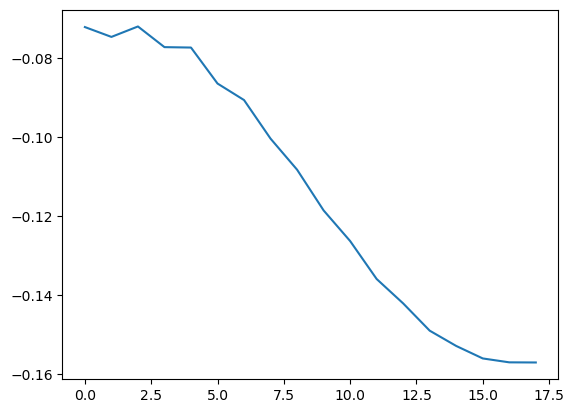

In [71]:
plt.plot(PARA_ERROR_GRADY[5,1:-1,1:-1].sum(1)/(nr-2))

In [72]:
PARA_ERROR_GRADX[5,1:-1,1:-1].sum(1).sum(0)/(nr-2)**2

-0.023697291639280627

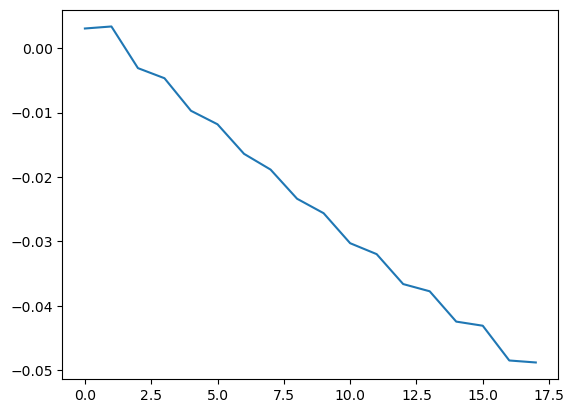

In [73]:
plt.plot(PARA_ERROR_GRADX[5,1:-1,1:-1].sum(0)/(nr-2))

In [104]:
print(np.mean(RHO_ACC))
print((RHO_ACC_MEAN_Y[1,:]))

print(np.mean(RHO_ACC_MEAN_Y[1,:]))
print(np.mean(RHO_ACC_MEAN_Y[:,:],axis=1))

1631.170529203881
[1652.40747576 1529.14546527 1418.98790842 1343.06024035 1298.32550241
 1278.69994214 1306.84323125 1356.31228873 1429.01975887 1528.94391574
 1623.27282807 1733.23680232 1817.91776268 1899.27847022 1949.82526554
 1978.57373947 1966.20942054 1946.78689364]
1614.2692728564668
[1628.91119852 1614.26927286 1614.88503729 1604.62668361 1598.1625116
 1582.45820283 1577.48770917 1636.9774142  1641.68335847 1621.11875448
 1622.47177627]


In [102]:
mean_true=np.mean(rho_grad[1:-1,1:-1,0], axis=1)
print(mean_true)
print(np.mean(mean_true))

[1491.9446048  1387.99630467 1306.34276453 1242.51724553 1209.11098575
 1212.95095602 1239.86680573 1300.30457553 1386.89387208 1486.1698789
 1598.34540094 1708.06254543 1811.46520557 1897.14744765 1954.54760902
 1990.92233369 1990.40775242 1956.13267183]
1565.0627200046702


In [200]:
np.mean(np.mean(RHO_ACC[:,:],axis=1), axis=1)

array([1648.87556884, 1636.4470849 , 1632.71281954, 1622.72212893,
       1615.43576407, 1598.69184412, 1593.75994198, 1653.85555819,
       1655.25883067, 1641.89248664, 1643.22379336])

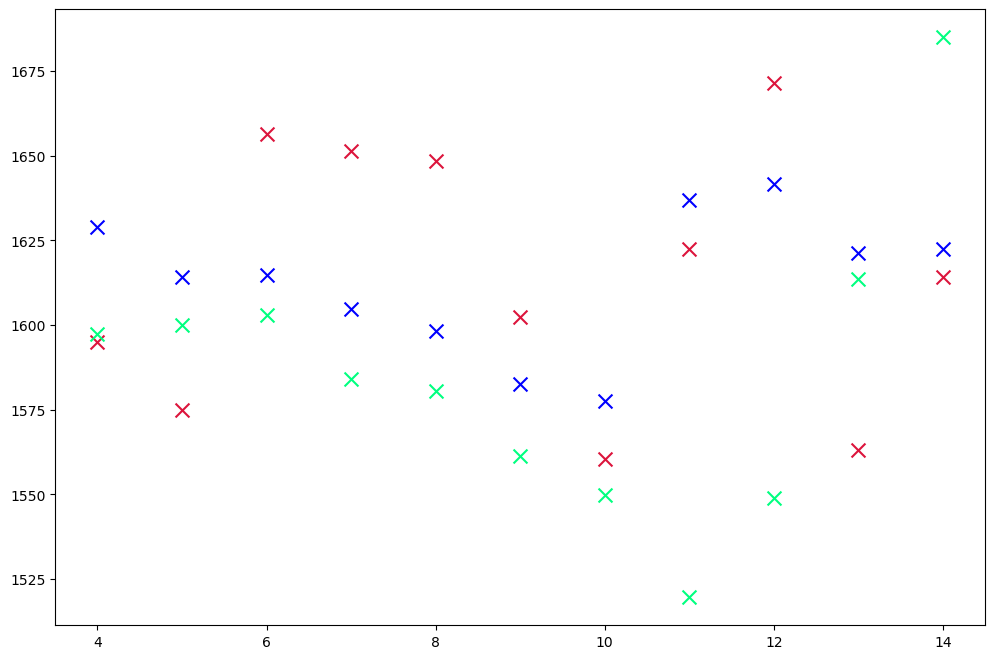

In [310]:
fig, ax = plt.subplots(figsize=(12,8))
#plt.scatter(fff,np.mean(np.mean(RHO_ACC[:,:],axis=1),axis=1), color='k', marker='x', s=100, label = r'Estimated Mean $\rho$')#, facecolor='none')

plt.scatter(fff,np.mean(RHO_ACC_MEAN_Y[:,:],axis=1), color='b', marker='x', s=100, label = r'Estimated Mean $\rho$')#, facecolor='none')
plt.scatter(fff,RHO_ACC[:,12,12] -100, label = r'Estimated Local $\rho$ at [13,13]', s=100, marker='x', color='crimson')
plt.scatter(fff,RHO_ACC[:,stx,sty] +350, label = r'Estimated Local $\rho$ at [13,6]', s=100, marker='x', color='springgreen')#, facecolor='none'


In [319]:
RHO_ACC[:,:].shape

(11, 20, 20)

In [330]:
np.mean(np.mean(np.mean(RHO_ACC[1:-1,1:-1],axis=1),axis=1))

1613.6598610417034

In [341]:
#print(np.mean(np.mean(RHO_ACC_MEAN_Y[:,:],axis=1)))
print(np.mean(np.mean(np.mean(RHO_ACC[1:-1,1:-1],axis=1),axis=1)))
print(np.mean(np.mean(rho_grad[1:-1,1:-1,0], axis=0)))
print(np.mean(RHO_ACC[:,12,12]))
print(rho_grad[12,12,0])
print(np.mean(RHO_ACC[:,stx,sty]))
print(rho_grad[stx,sty,0])


1613.6598610417034
1565.0627200046702
1714.5533348392696
1708.0625454323083
1235.7338594075493
1209.1109857465863


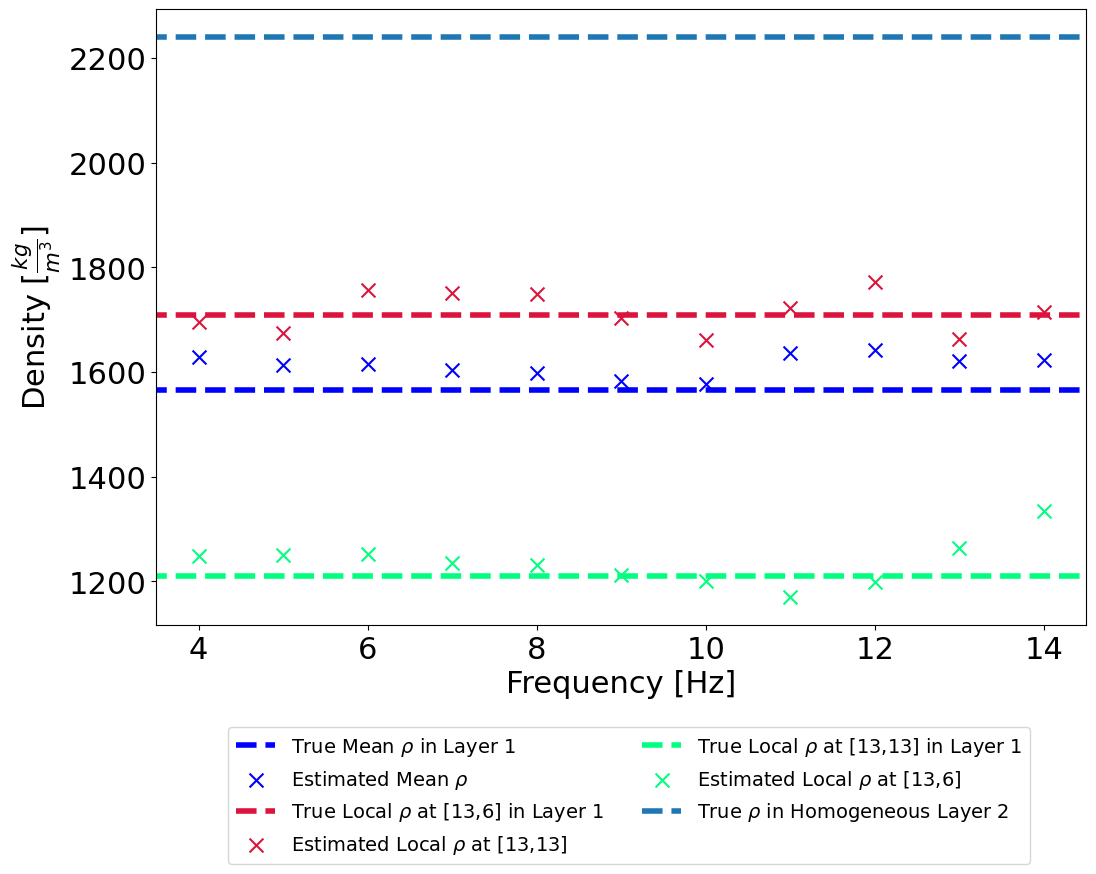

In [342]:
stx = 5
sty = 12

fig, ax = plt.subplots(figsize=(12,8))
#plt.plot(np.arange(1,nr-1),np.mean(np.mean(rho_grad[:,:,0], axis=0))*np.ones((nr-2)), linewidth=4, color='blue', label = r'True Mean $\rho$ in Layer 1', linestyle='--')

plt.plot(np.arange(1,nr-1),np.mean(np.mean(rho_grad[1:-1,1:-1,0], axis=0))*np.ones((nr-2)), linewidth=4, color='b', label = r'True Mean $\rho$ in Layer 1', linestyle='--')
#plt.scatter(fff,np.mean(RHO_ACC_MEAN_Y[:,:],axis=1), color='b', marker='x', s=100, label = r'Estimated Mean $\rho$')#, facecolor='none')
plt.scatter(fff,np.mean(np.mean(RHO_ACC[:,1:-1,1:-1],axis=1),axis=1), color='b', marker='x', s=100, label = r'Estimated Mean $\rho$')#, facecolor='none')


plt.plot(np.arange(1,nr-1),rho_grad[12,12,0]*np.ones((nr-2)), linewidth=4, color='crimson', label = r'True Local $\rho$ at [13,6] in Layer 1', linestyle='--')
plt.scatter(fff,RHO_ACC[:,12,12] , label = r'Estimated Local $\rho$ at [13,13]', s=100, marker='x', color='crimson')

plt.plot(np.arange(1,nr-1),rho_grad[stx,sty,0]*np.ones((nr-2)), linewidth=4, color='springgreen', label = r'True Local $\rho$ at [13,13] in Layer 1', linestyle='--')
plt.scatter(fff,RHO_ACC[:,stx,sty] , label = r'Estimated Local $\rho$ at [13,6]', s=100, marker='x', color='springgreen')#, facecolor='none'

plt.plot(np.arange(1,nr-1),2240*np.ones((nr-2)), label=r'True $\rho$ in Homogeneous Layer 2', linewidth=4, linestyle='--')


plt.xlim([fff[0]-0.5, fff[-1]+0.5])
#plt.ylim([1500,2300])
plt.xlabel('Frequency [Hz]',fontsize=22)
plt.ylabel(r'Density [$\frac{kg}{m^3}$]',fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.95, -0.15), ncols=2)

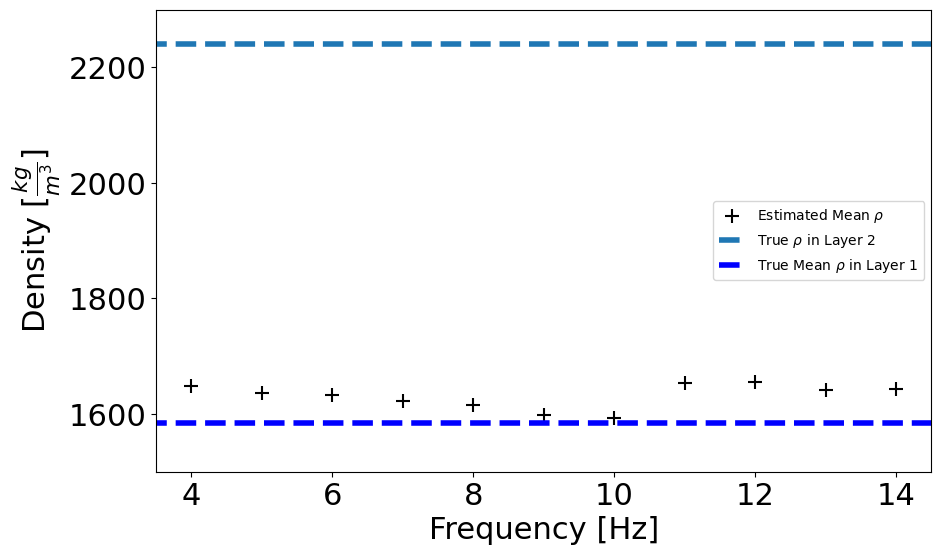

In [215]:
fig, ax = plt.subplots(figsize=(10,6))
# plt.scatter(fff,np.mean(RHO_ACC_MEAN_Y[:,:],axis=1))
difference = np.mean(rho_grad[:,:,0]) -np.mean(np.mean(RHO_ACC[:,:],axis=1), axis=1)
difference2 = 2240 -np.mean(np.mean(RHO_ACC[:,:],axis=1), axis=1)

plt.scatter(fff,np.mean(np.mean(RHO_ACC[:,:],axis=1), axis=1) , label = r'Estimated Mean $\rho$', s=100, marker='+', color='k')

plt.plot(np.arange(1,nr-1),2240*np.ones((nr-2)), label=r'True $\rho$ in Layer 2', linewidth=4, linestyle='--')
#plt.plot(np.arange(1,nr-1),np.mean(np.mean(rho_grad[1:-1,1:-1,0], axis=0))*np.ones((nr-2)), linewidth=4, color='blue', label = 'True model', linestyle='--')
plt.plot(np.arange(1,nr-1),np.mean(rho_grad[:,:,0])*np.ones((nr-2)), linewidth=4, color='blue', label = r'True Mean $\rho$ in Layer 1', linestyle='--')
#plt.plot(fff,difference, linewidth=4, color='blue', label = 'Mean True model Top Layer', linestyle='--') 
#plt.plot(fff,difference2, linewidth=4, color='blue', label = 'Mean True model Top Layer', linestyle='--')

plt.xlim([fff[0]-0.5, fff[-1]+0.5])
plt.ylim([1500,2300])
plt.xlabel('Frequency [Hz]',fontsize=22)
plt.ylabel(r'Density [$\frac{kg}{m^3}$]',fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

plt.legend()

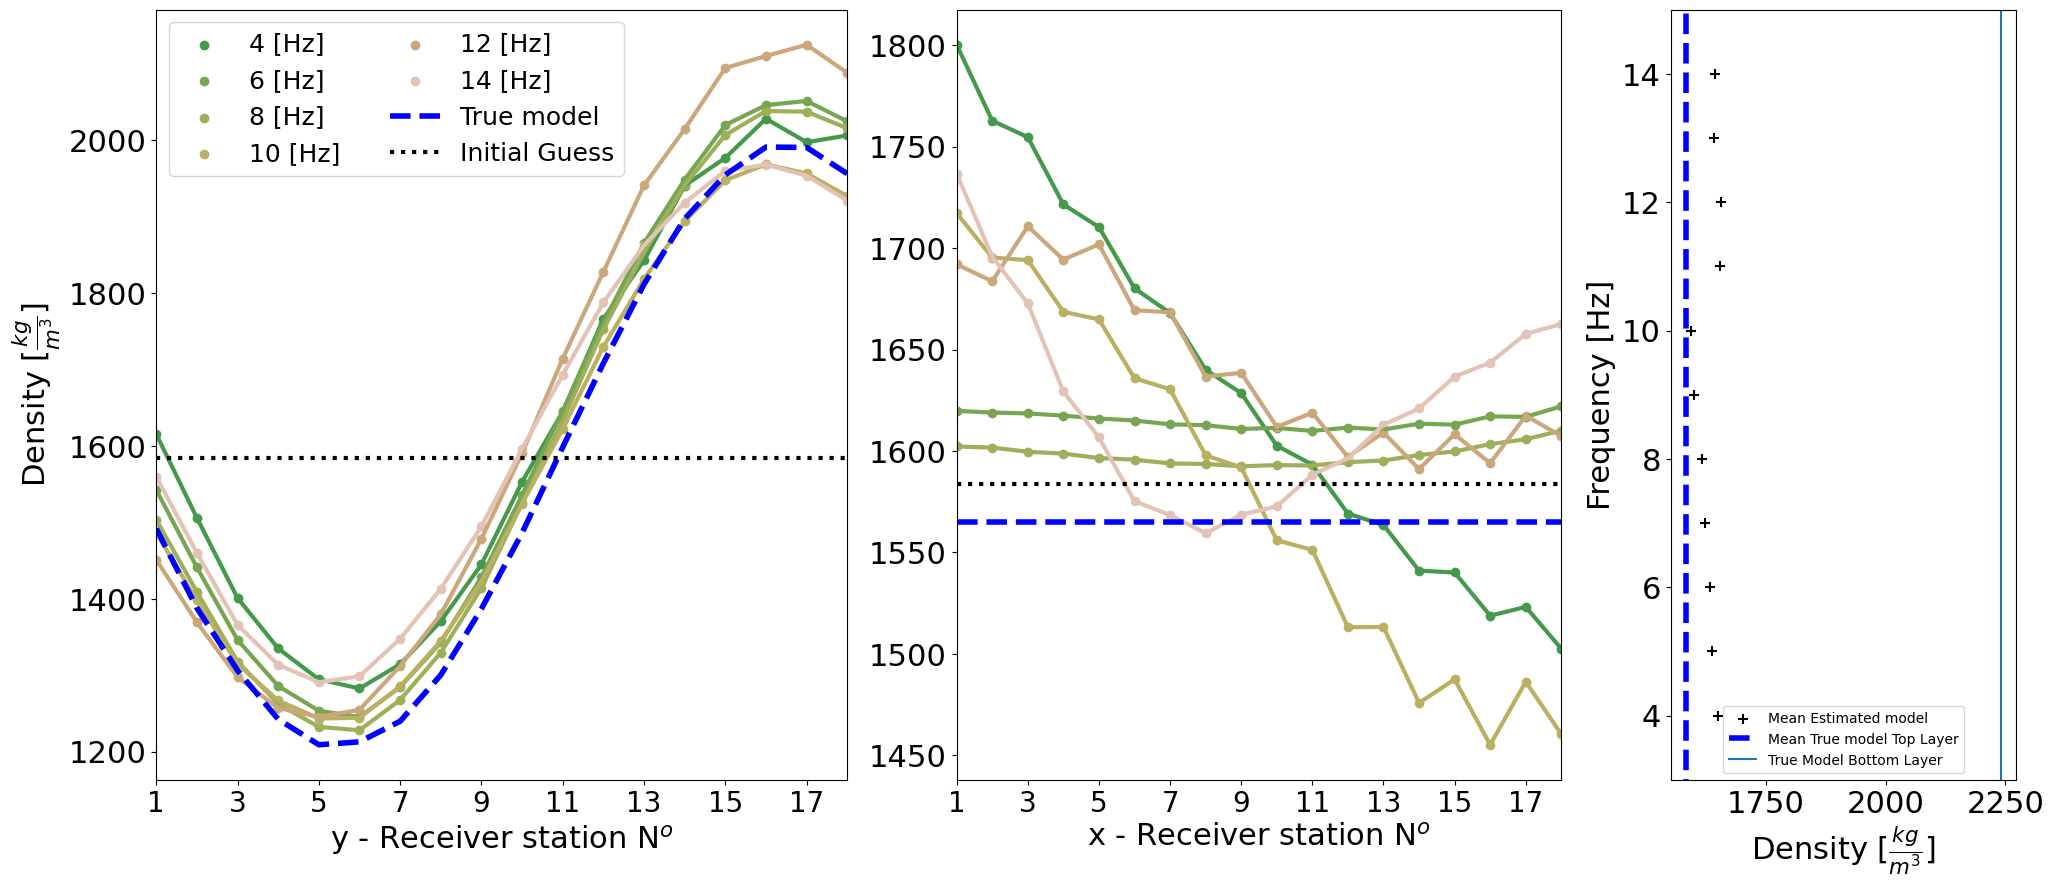

In [180]:
fig,(ax1,ax2, ax3) = plt.subplots(figsize=(24,10),ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m=0
for jj in np.arange(0,len(fff),2): 
    ax1.plot(np.arange(1,nr-1),RHO_ACC_MEAN_Y[jj,:],color=ccc[m+4],linewidth=3)
    ax1.scatter(np.arange(1,nr-1),RHO_ACC_MEAN_Y[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax2.plot(np.arange(1,nr-1),RHO_ACC_MEAN_X[jj,:],color=ccc[m+4],linewidth=3)
    ax2.scatter(np.arange(1,nr-1),RHO_ACC_MEAN_X[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=22)
    ax2.set_xticks(np.arange(1, 19, 2.0))
    ax1.set_xticks(np.arange(1, 19, 2.0))
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=22)
    m=m+1
ax1.set_xlim([1,18])    
ax2.set_xlim([1,18])    


m_init0 = np.ones((nr,nr))*np.mean(rho_grad[:,:,0])
ax1.plot(np.arange(1,nr-1),rho_grad[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(1,nr-1),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax2.plot(np.arange(1,nr-1),rho_grad[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(1,nr-1),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)

ax1.set_ylabel(r'Density [$\frac{kg}{m^3}$]',fontsize=22)
ax1.legend(fontsize=18,loc='upper left', ncol=2)

ax3.plot((PARA_ERROR_MEAN[::1]),np.arange(4,15,1),linewidth=2, linestyle=':', color='black')
ax3.scatter((PARA_ERROR_MEAN[::1]),np.arange(4,15,1),marker='+',s=200, color='black')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=22)
ax3.set_xlabel(r'Density' + ' Parameter Error [%]',fontsize=22)

# ax3.scatter(np.mean(np.mean(RHO_ACC[:,:],axis=1), axis=1),fff , label = 'Mean Estimated model', s=50, marker='+', color='k')
# ax3.plot(np.mean(rho_grad[:,:,0])*np.ones((nr-2)),np.arange(1,nr-1), linewidth=4, color='blue', label = 'Mean True model Top Layer', linestyle='--')
# ax3.plot(2240*np.ones((nr-2)), np.arange(1,nr-1),label='True Model Bottom Layer')

# ax3.set_ylim([fff[0]-1, fff[-1]+1])
# ax3.set_ylabel('Frequency [Hz]',fontsize=22)
# ax3.set_xlabel(r'Density [$\frac{kg}{m^3}$]',fontsize=22)
# ax3.xaxis.set_tick_params(labelsize=22)
# ax3.yaxis.set_tick_params(labelsize=22)
# ax3.legend()

In [76]:
np.arange(4,15,2)

array([ 4,  6,  8, 10, 12, 14])

In [77]:
# rho_signal = (U_LAPLACE_VAR_TRUE[1:-1,1:-1,1:-1]-acc3_2D[1:-1,1:-1,0,1:-1]).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2

# to_export = pd.DataFrame(rho_signal)
# to_export.to_csv(fig_+'/rho_signal'+'_'+str(round(f_filt_cent[0])), index=False)

# rho_signal_ABS = abs(U_LAPLACE_VAR_TRUE[1:-1,1:-1,1:-1]-acc3_2D[1:-1,1:-1,0,1:-1]).mean(axis=0).mean(axis=0)#.sum(0).sum(0)/(nr-2)**2

# to_export = pd.DataFrame(rho_signal)
# to_export.to_csv(fig_+'/rho_signal_ABS'+'_'+str(round(f_filt_cent[0])), index=False)

# to_export = pd.DataFrame(U_LAPLACE_VAR_TRUE[1:-1,1:-1,1:-1].mean(axis=0).mean(axis=0))
# to_export.to_csv(fig_+'/UspVAR'+'_'+str(round(f_filt_cent[0])), index=False)

In [78]:
RHO_SIGNAL_RATIO = np.zeros((11,1))
FINGERPRINT = np.zeros((11,1))
FINGERPRINT_tot = np.zeros((11,1))
USP_NORM = np.zeros((11,1))
test =  np.zeros((11,1)) 

fff_new = np.array([4,5,6,7,8,9,10,11,12,13,14])
#fff_new = np.array([4,6,8,10,12,14])

i=0
for ff in fff_new: 
    RHO_SIGNAL_RATIO[i,:] = (abs(pd.read_csv(fig_+'/rho_signal'+'_'+str(ff))).values.sum(0)/nt_sub) / (abs(pd.read_csv(fig_+'/UspVAR'+'_'+str(ff))).values.sum(0)/nt_sub)
    FINGERPRINT[i,:] = np.mean(pd.read_csv(fig_+'/fingerprint'+'_'+str(ff)).values[1:-1,1:-1])
    FINGERPRINT_tot[i,:] = np.mean(pd.read_csv(fig_+'/fingerprint'+'_'+str(ff)).values)
    USP_NORM[i,:] = np.mean(pd.read_csv(fig_+'/USP_norm_grid'+'_'+str(ff)).values[1:-1,1:-1])
    test[i,:] = np.mean(pd.read_csv(fig_+'/fingerprint'+'_'+str(ff)).values[1:-1,1:-1]/pd.read_csv(fig_+'/USP_norm_grid'+'_'+str(ff)).values[1:-1,1:-1])
    i=i+1

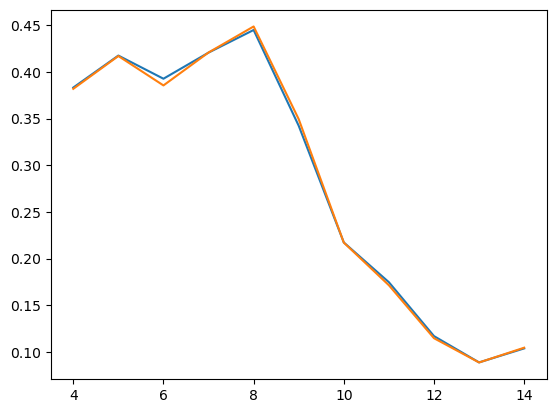

In [79]:
plt.plot(fff_new,FINGERPRINT/USP_NORM)
plt.plot(fff_new,test)

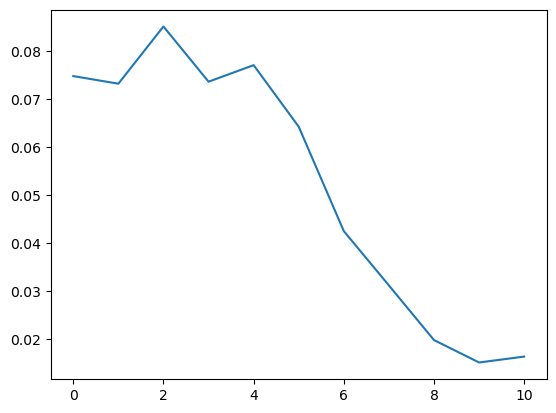

In [80]:
plt.plot(FINGERPRINT)

#plt.plot(FINGERPRINT_tot)

In [81]:
RHO_SIGNAL_RATIO_loaded = pd.read_csv(fig_+'/RHO_SIGNAL_HET_FA-HELM')
RHO_SIGNAL_RATIO2_loaded = pd.read_csv(fig_+'/RHO_SIGNAL_HOM-HET')
dc_c = pd.read_csv(fig_+'/dc_ABS_gridmean_freqs')


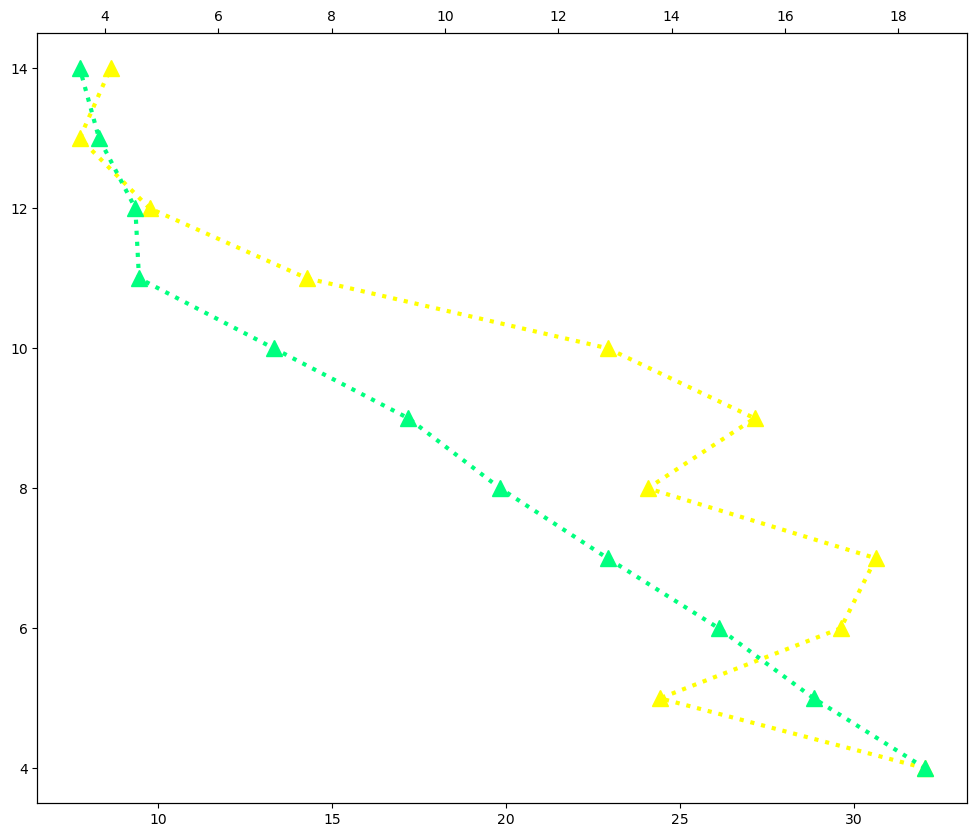

In [82]:
#plt.plot(100*RHO_SIGNAL_RATIO[:,0], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
fig,ax=plt.subplots(figsize=(12,10))
ax.plot(100*RHO_SIGNAL_RATIO_loaded[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='yellow', label=r'$\rho$ fingerprint')
axx = ax.twiny()
axx.plot(dc_c[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='springgreen', label=r'$\rho$ fingerprint')


In [173]:
#C_BASE[i,1:-1,1:-1]

(3.8, 14.2)

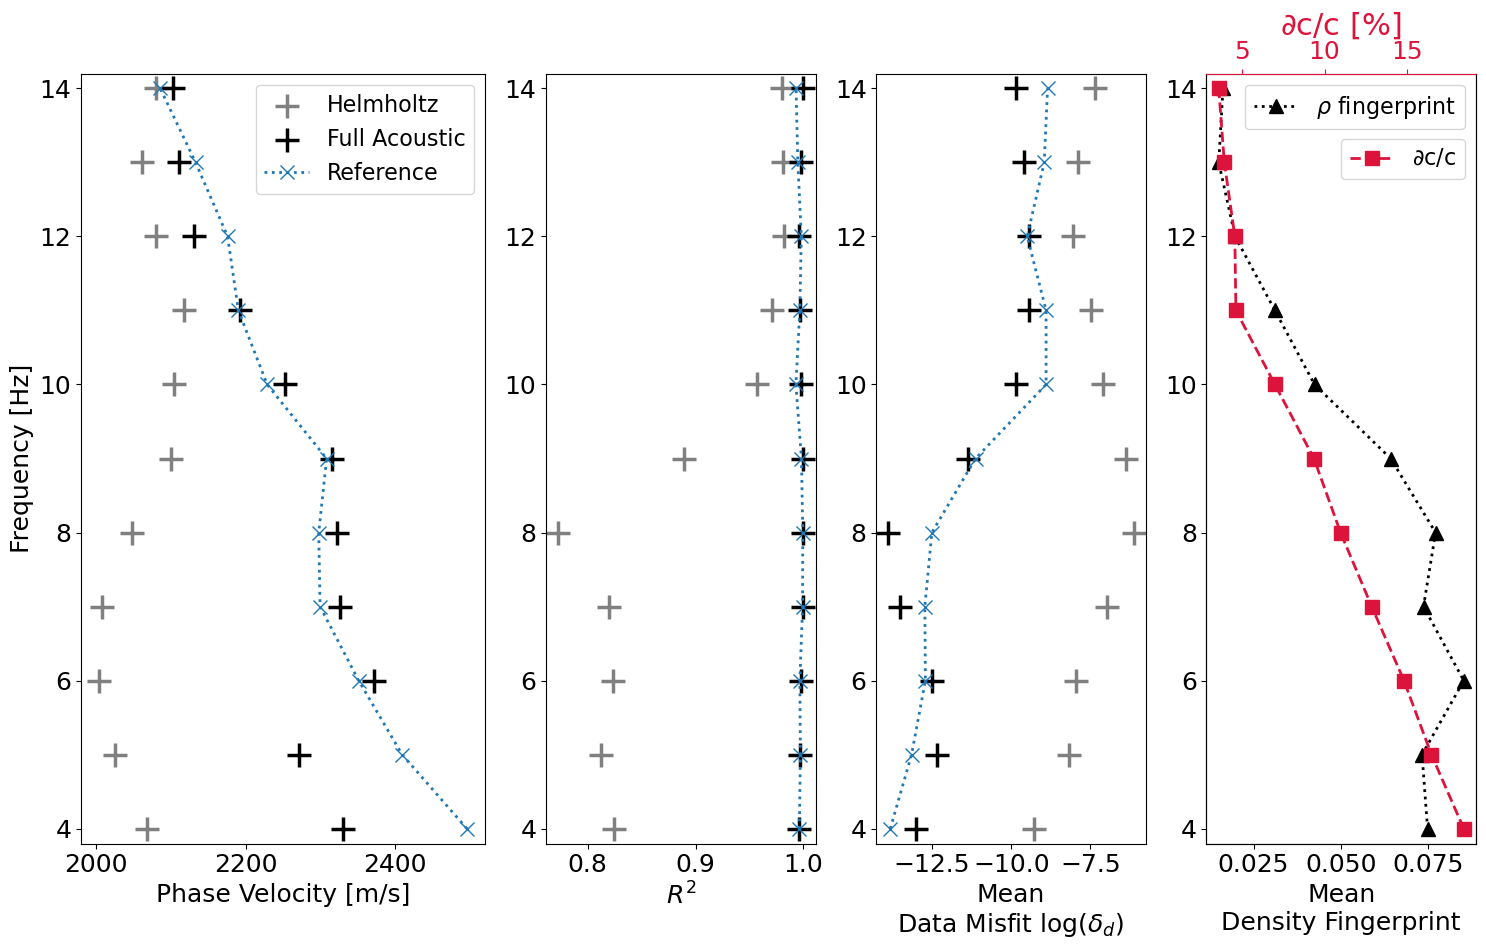

In [142]:
C_HELM_MEAN = np.zeros((length))
C_ACC_MEAN = np.zeros((length))
C_ACC_TRUE_MEAN = np.zeros((length))
C_BASE_MEAN = np.zeros((length))
RSQ_HELM_MEAN = np.zeros((length))
RSQ_ACC_MEAN = np.zeros((length))
RSQ_ACC_TRUE_MEAN = np.zeros((length))
RSQ_BASE_MEAN = np.zeros((length))
MIS_HELM_MEAN = np.zeros((length))
MIS_ACC_MEAN = np.zeros((length))
MIS_ACC_TRUE_MEAN = np.zeros((length))
MIS_BASE_MEAN = np.zeros((length))
    
gif, (ax1,ax2,ax3,ax4) = plt.subplots(figsize=(18,10),ncols=4,gridspec_kw={'width_ratios': [3,2,2,2]})
for i in range(0,length):
    C_HELM_MEAN[i] = np.mean(C_HELM[i,1:-1,1:-1])
    C_ACC_MEAN[i] = np.mean(C_ACC[i,1:-1,1:-1])
    C_ACC_TRUE_MEAN[i] = np.mean(C_ACC_TRUE[i,1:-1,1:-1])
    C_BASE_MEAN[i] = np.mean(C_BASE[i,1:-1,1:-1])
    
    RSQ_HELM_MEAN[i] = np.mean(RSQ_HELM[i,1:-1,1:-1])
    RSQ_ACC_MEAN[i] = np.mean(RSQ_ACC[i,1:-1,1:-1])
    RSQ_ACC_TRUE_MEAN[i] = np.mean(RSQ_ACC_TRUE[i,1:-1,1:-1])
    RSQ_BASE_MEAN[i] = np.mean(RSQ_BASE[i,1:-1,1:-1])
    
    MIS_HELM_MEAN[i] = np.mean(MIS_HELM[i,1:-1,1:-1])
    MIS_ACC_MEAN[i] = np.mean(MIS_ACC[i,1:-1,1:-1])
    MIS_ACC_TRUE_MEAN[i] = np.mean(MIS_ACC_TRUE[i,1:-1,1:-1])
    MIS_BASE_MEAN[i] = np.mean(MIS_BASE[i,1:-1,1:-1])
    
    
ax1.scatter(C_HELM_MEAN,fff,marker='+', label='Helmholtz',s=280, color='grey', linewidth=2.5)
ax1.scatter(C_ACC_MEAN,fff,marker='+', label='Full Acoustic',s=280, color='black', linewidth=2.5)
#ax1.scatter(C_BASE_MEAN,fff,marker='+', label='Baseline',s=200, linewidth=2)
#ax1.plot(C_BASE_MEAN,fff, color='tab:blue',linestyle=':')
ax1.plot(C_BASE_MEAN,fff, color='tab:blue',marker='x', markersize=10, label='Reference',linestyle=':', linewidth=2)

# ax1.scatter(C_ACC_TRUE_MEAN,fff,marker='+', label='True Full Acoustic',s=280, color='tab:green')
# ax1.plot(C_ACC_TRUE_MEAN,fff, color='tab:green')
ax1.legend(fontsize=16,loc='upper right')

ax2.scatter(RSQ_HELM_MEAN,fff,marker='+',s=280, color='grey', linewidth=2.5)
ax2.scatter(RSQ_ACC_MEAN,fff,marker='+',s=280, color='black', linewidth=2.5)
#ax2.scatter(RSQ_BASE_MEAN,fff,marker='+',s=200, linewidth=2)
ax2.plot(RSQ_BASE_MEAN,fff, color='tab:blue',linestyle=':',marker='x',markersize=10, linewidth=2)
# ax2.scatter(RSQ_ACC_TRUE_MEAN,fff,marker='+', label='True Full Acoustic',s=280, color='tab:green')
# ax2.plot(RSQ_ACC_TRUE_MEAN,fff, color='tab:green')

ax3.scatter(np.log(MIS_HELM_MEAN),fff,marker='+',s=280, color='grey', linewidth=2.5)
ax3.scatter(np.log(MIS_ACC_MEAN),fff,marker='+',s=280, color='black', linewidth=2.5)
#ax3.plot(np.log(MIS_HELM_MEAN),fff,marker='+', markersize=12, color='grey', linestyle='none')
#ax3.plot(np.log(MIS_ACC_MEAN),fff,marker='+', markersize=12, color='black', linestyle='none')


#ax3.scatter(np.log(MIS_BASE_MEAN),fff,marker='+',s=200, linewidth=2)
ax3.plot(np.log(MIS_BASE_MEAN),fff, color='tab:blue',linestyle=':',marker='x',markersize=10, linewidth=2)
# ax3.scatter(np.log(MIS_ACC_TRUE_MEAN),fff,marker='o',s=20, color='tab:green')
# ax3.plot(np.log(MIS_ACC_TRUE_MEAN),fff, color='tab:green',linestyle=':', linewidth=1.5)


#ax4.plot(100*RHO_SIGNAL_RATIO_loaded[:], fff_new,linewidth=2, linestyle=':', marker='^', markersize=10, color='black', label=r'$\rho$ fingerprint')
ax4.plot(FINGERPRINT[:], fff_new,linewidth=2, linestyle=':', marker='^', markersize=10, color='black', label=r'$\rho$ fingerprint')

axx4 = ax4.twiny()
axx4.plot(dc_c[:], fff_new,linewidth=2, linestyle='--', marker='s', markersize=10, color='crimson', label=r'$\partial$c/c')
ax4.legend(fontsize=16,loc='upper right')
axx4.legend(fontsize=16,loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.93))

ax4.xaxis.set_tick_params(labelsize=18)
axx4.xaxis.set_tick_params(labelsize=18)
ax4.yaxis.set_tick_params(labelsize=18)
axx4.set_xlabel(r'$\partial$c/c [%]',fontsize=22)
axx4.spines['top'].set_color('crimson')
axx4.tick_params(axis='x', colors='crimson')
axx4.xaxis.label.set_color('crimson')
ax4.set_xlabel(r'Mean' +'\n'+'Density Fingerprint',fontsize=18)
ax4.set_ylim([3.8,14.2])

ax3.xaxis.set_tick_params(labelsize=18)
ax3.yaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
# axx4.set_xlabel(r'$\partial$c/c [%]',fontsize=22)
# ax4.set_xlabel('Density Fingerprint [%]',fontsize=18)
ax1.set_xlabel('Phase Velocity [m/s]',fontsize=18)
ax2.set_xlabel(r'$R^{2}$',fontsize=18)
ax3.set_xlabel(r'Mean' +'\n'+ 'Data Misfit log($\delta_{d}$)',fontsize=18)
ax1.set_ylabel('Frequency [Hz]',fontsize=18)
ax1.set_ylim([3.8,14.2])
ax2.set_ylim([3.8,14.2])
ax3.set_ylim([3.8,14.2])
# ax4.set_ylim([3.8,14.2])

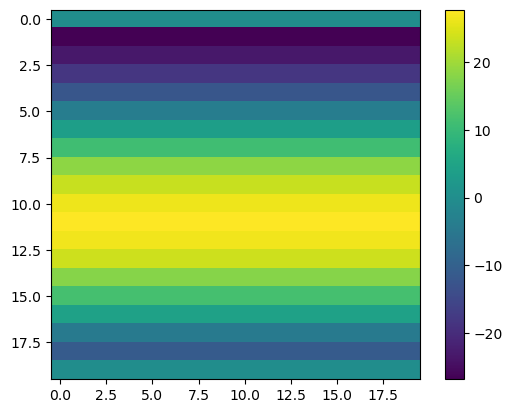

In [151]:
plt.imshow(rho_GRAD_true)
plt.colorbar()

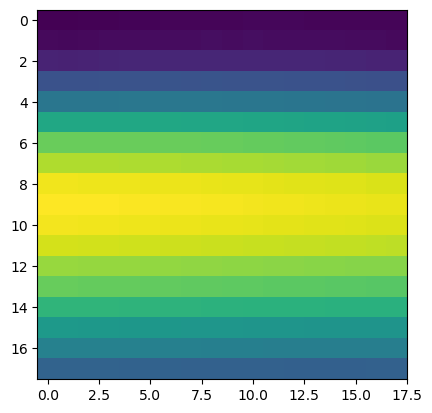

In [167]:
plt.imshow(store_grad_X_scaled[5,1:-1,1:-1])

In [156]:
np.mean(np.mean(store_grad_Y_scaled[:,1:-1,1:-1],axis=1), axis=1)

array([-0.24916634, -0.20901506,  0.00379249,  0.01295738,  0.00743642,
       -0.11405615, -0.20070834, -0.16585328, -0.04301737, -0.18238298,
       -0.00816124])

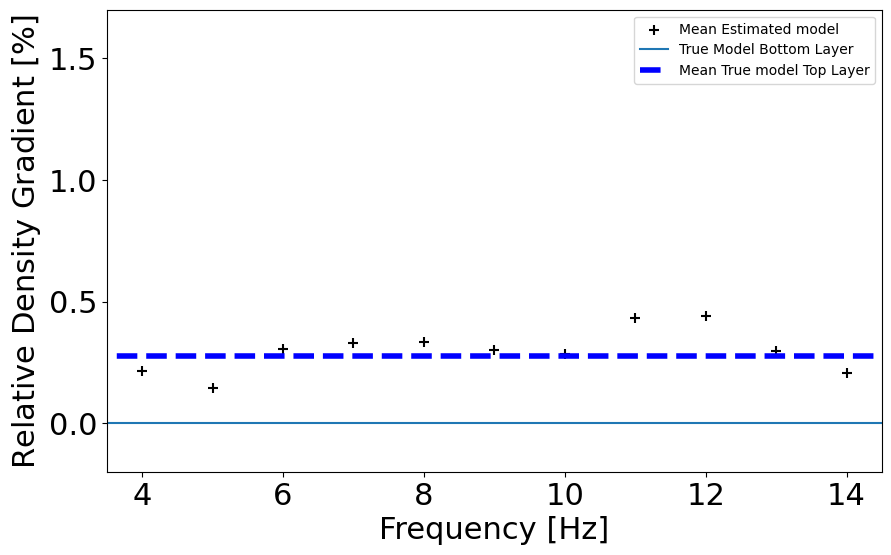

In [217]:
fig, ax = plt.subplots(figsize=(10,6))
# plt.scatter(fff,np.mean(RHO_ACC_MEAN_Y[:,:],axis=1))
plt.scatter(fff,np.mean(np.mean(store_grad_X_scaled[:,1:-1,1:-1],axis=1), axis=1) , label = 'Mean Estimated model', s=50, marker='+', color='k')

plt.plot(np.arange(1,nr-1),0*np.ones((nr-2)), label='True Model Bottom Layer')
# plt.plot(np.arange(1,nr-1),np.mean(np.mean(rho_grad[1:-1,1:-1,0], axis=0))*np.ones((nr-2)), linewidth=4, color='blue', label = 'True model', linestyle='--')
plt.plot(np.arange(1,nr-1),np.mean(rho_GRAD_true_scaled[:,:])*np.ones((nr-2)), linewidth=4, color='blue', label = 'Mean True model Top Layer', linestyle='--')

plt.xlim([fff[0]-0.5, fff[-1]+0.5])
plt.ylim([-0.2, 1.7])
plt.xlabel('Frequency [Hz]',fontsize=22)
plt.ylabel(r'Relative Density Gradient [$\%$]',fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

plt.legend()

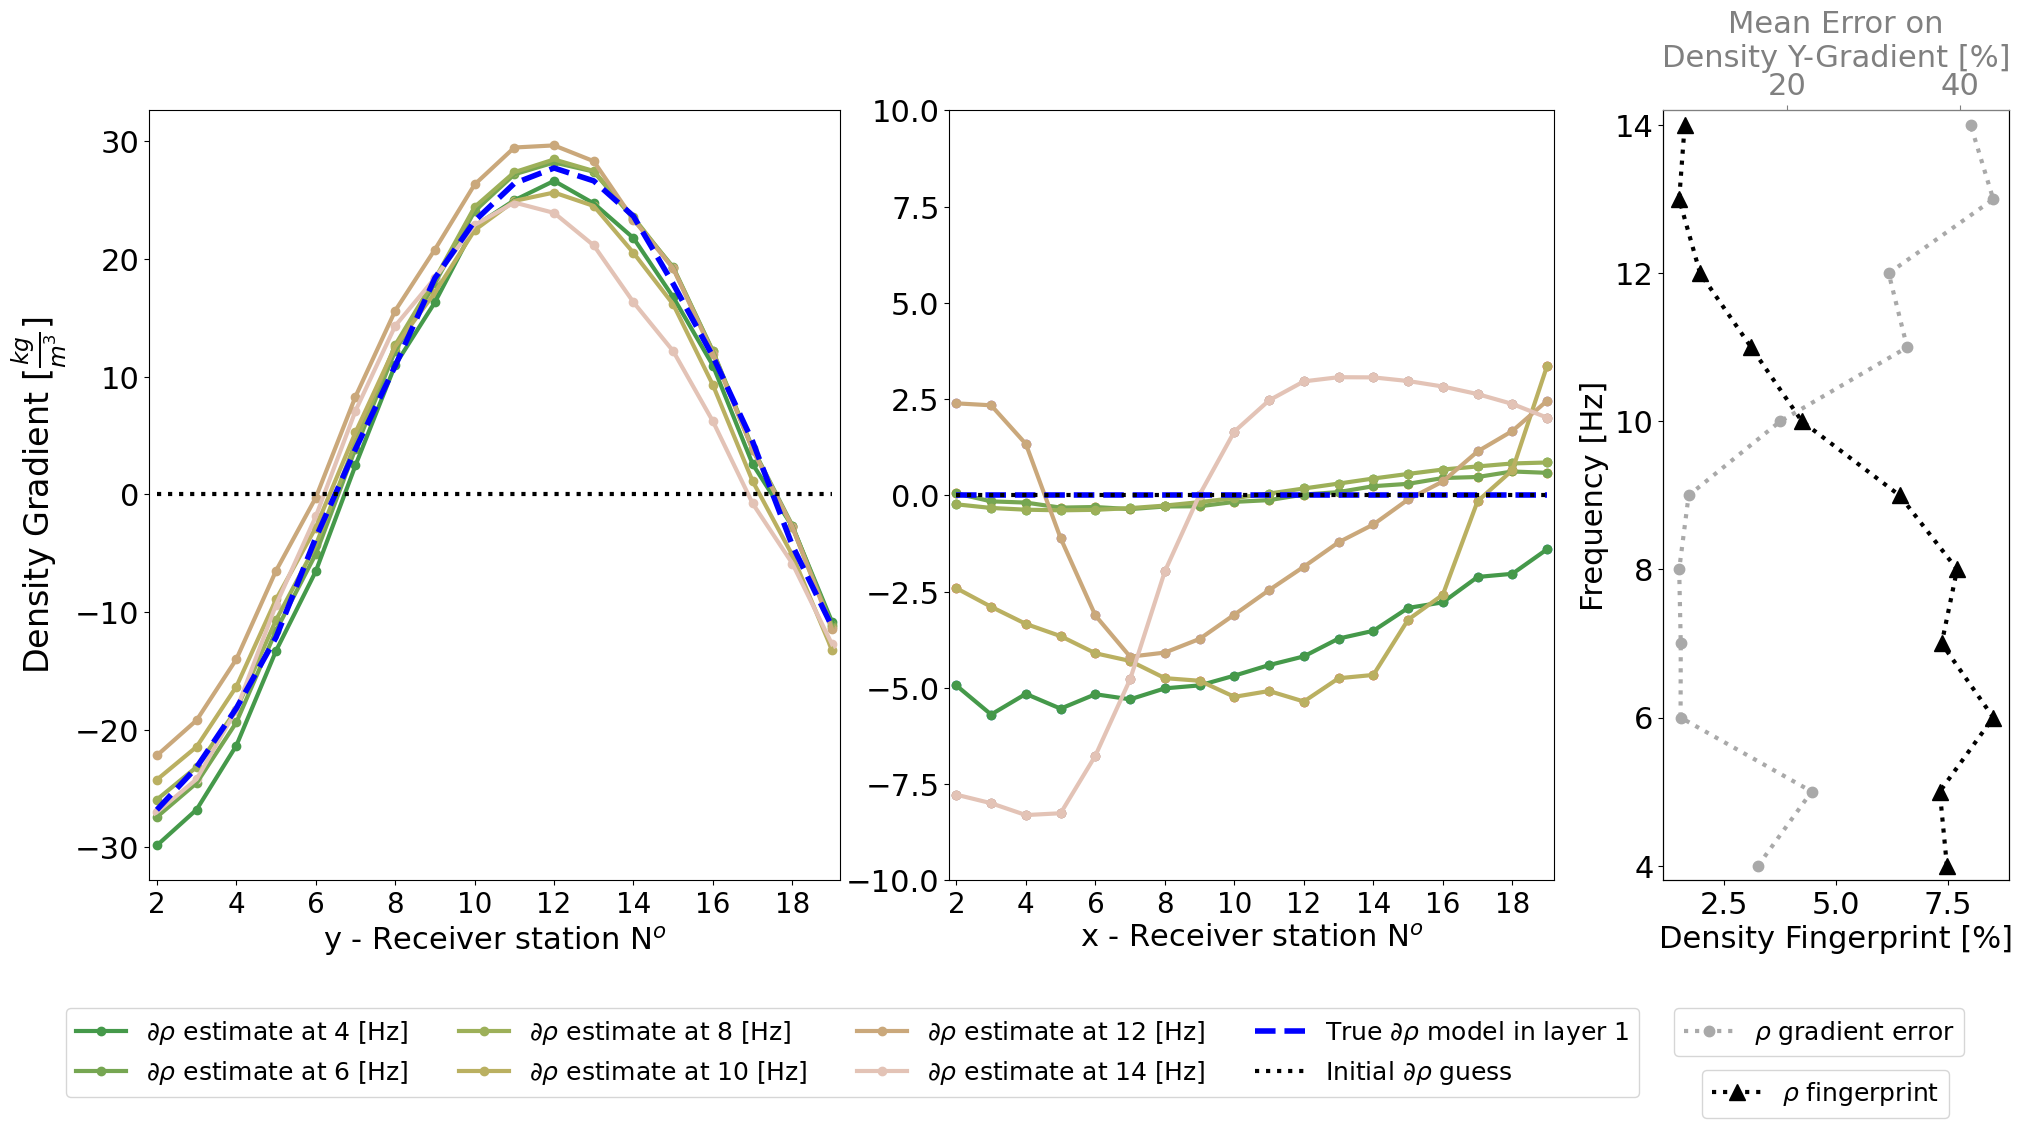

In [143]:
fig,(ax1,ax2, ax3) = plt.subplots(figsize=(24,10),ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m=0
for jj in np.arange(0,len(fff),2): 
    ax2.plot(np.arange(2,nr),(store_grad_Y[jj,1:-1,1:-1].sum(0)/(nr-2)),color=ccc[m+4],linewidth=3,marker='o',label= r'$\partial$$\rho$ estimate at ' +str(fff[jj])+str(' [Hz]'))
    ax2.scatter(np.arange(2,nr),(store_grad_Y[jj,1:-1,1:-1].sum(0)/(nr-2)))
    ax1.plot(np.arange(2,nr),(store_grad_X[jj,1:-1,1:-1].sum(1)/(nr-2) ),color=ccc[m+4],linewidth=3)
    ax1.scatter(np.arange(2,nr),(store_grad_X[jj,1:-1,1:-1].sum(1)/(nr-2)),marker='o',label= r'$\partial$$\rho$ estimate at ' +str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=22)
    ax2.set_xticks(np.arange(2, 20, 2.0))
    ax1.set_xticks(np.arange(2, 20, 2.0))
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=22)
    m=m+1
ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])  
ax2.set_ylim([-10,10])  


m_init0 = np.ones((nr,nr))*np.mean(rho_grad[:,:,0])
#ax1.plot(np.arange(1,nr-1),(np.asarray(np.gradient(rho_grad[1:-1,1:-1,0])[0]).sum(1).T.flatten()/18), linewidth=10, color='yellow', label = 'True model', linestyle='-')
ax1.plot(np.arange(2,nr),(rho_GRAD_true[1:-1,1:-1].sum(1).T.flatten()/18), linewidth=4, color='blue', label = 'True model in layer 1', linestyle='--')
ax1.plot(np.arange(2,nr),(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18), linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax2.plot(np.arange(2,nr),(np.gradient(rho_grad[1:-1,1:-1,0].sum(0)).T.flatten()/18), linewidth=4, color='blue', label = r'True $\partial$$\rho$ model in layer 1', linestyle='--')
ax2.plot(np.arange(2,nr),(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18), linewidth=3, color='black', label = r'Initial $\partial$$\rho$ guess', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)

ax1.set_ylabel(r'Density Gradient [$\frac{kg}{m^3}$]',fontsize=24)
#ax2.legend(fontsize=18,loc='upper right', ncol=2)
#ax2.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(1.02, 1.2))
ax2.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(-0.16, -0.15))


#ax3.plot(100*RHO_SIGNAL_RATIO[:,0], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
#ax3.plot(100*RHO_SIGNAL_RATIO_loaded[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
ax3.plot(100*FINGERPRINT[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')

#ax3.plot(dc_c[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='springgreen', label=r'$\rho$ fingerprint')

#ax3.scatter(100*RHO_SIGNAL_RATIO[1:-1,0], fff_new,marker='+',s=200, color='black')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=22)
ax3.set_xlabel(r'Density Fingerprint [%]',fontsize=22)
#ax3.set_xlim([5,17])
ax4 = ax3.twiny()
#ax4.scatter(((PARA_ERROR_MEAN_GRAD)),fff,linewidth=2, linestyle=':', color='crimson')
ax4.plot((PARA_ERROR_MEAN_GRADX),fff,linewidth=3, linestyle=':', marker='.', markersize=15, color='darkgrey', label=r'$\rho$ gradient error')

ax4.set_xlabel(r'Mean Error on' +'\n'+ 'Density' + ' Y-Gradient [%]',fontsize=22)
ax4.xaxis.set_tick_params(labelsize=22)
#ax4.set_xlim([0-1,50])
ax4.spines['top'].set_color('grey')
ax4.tick_params(axis='x', colors='grey')
ax4.xaxis.label.set_color('grey')
ax4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.45, -0.15))
ax3.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.47, -0.23))

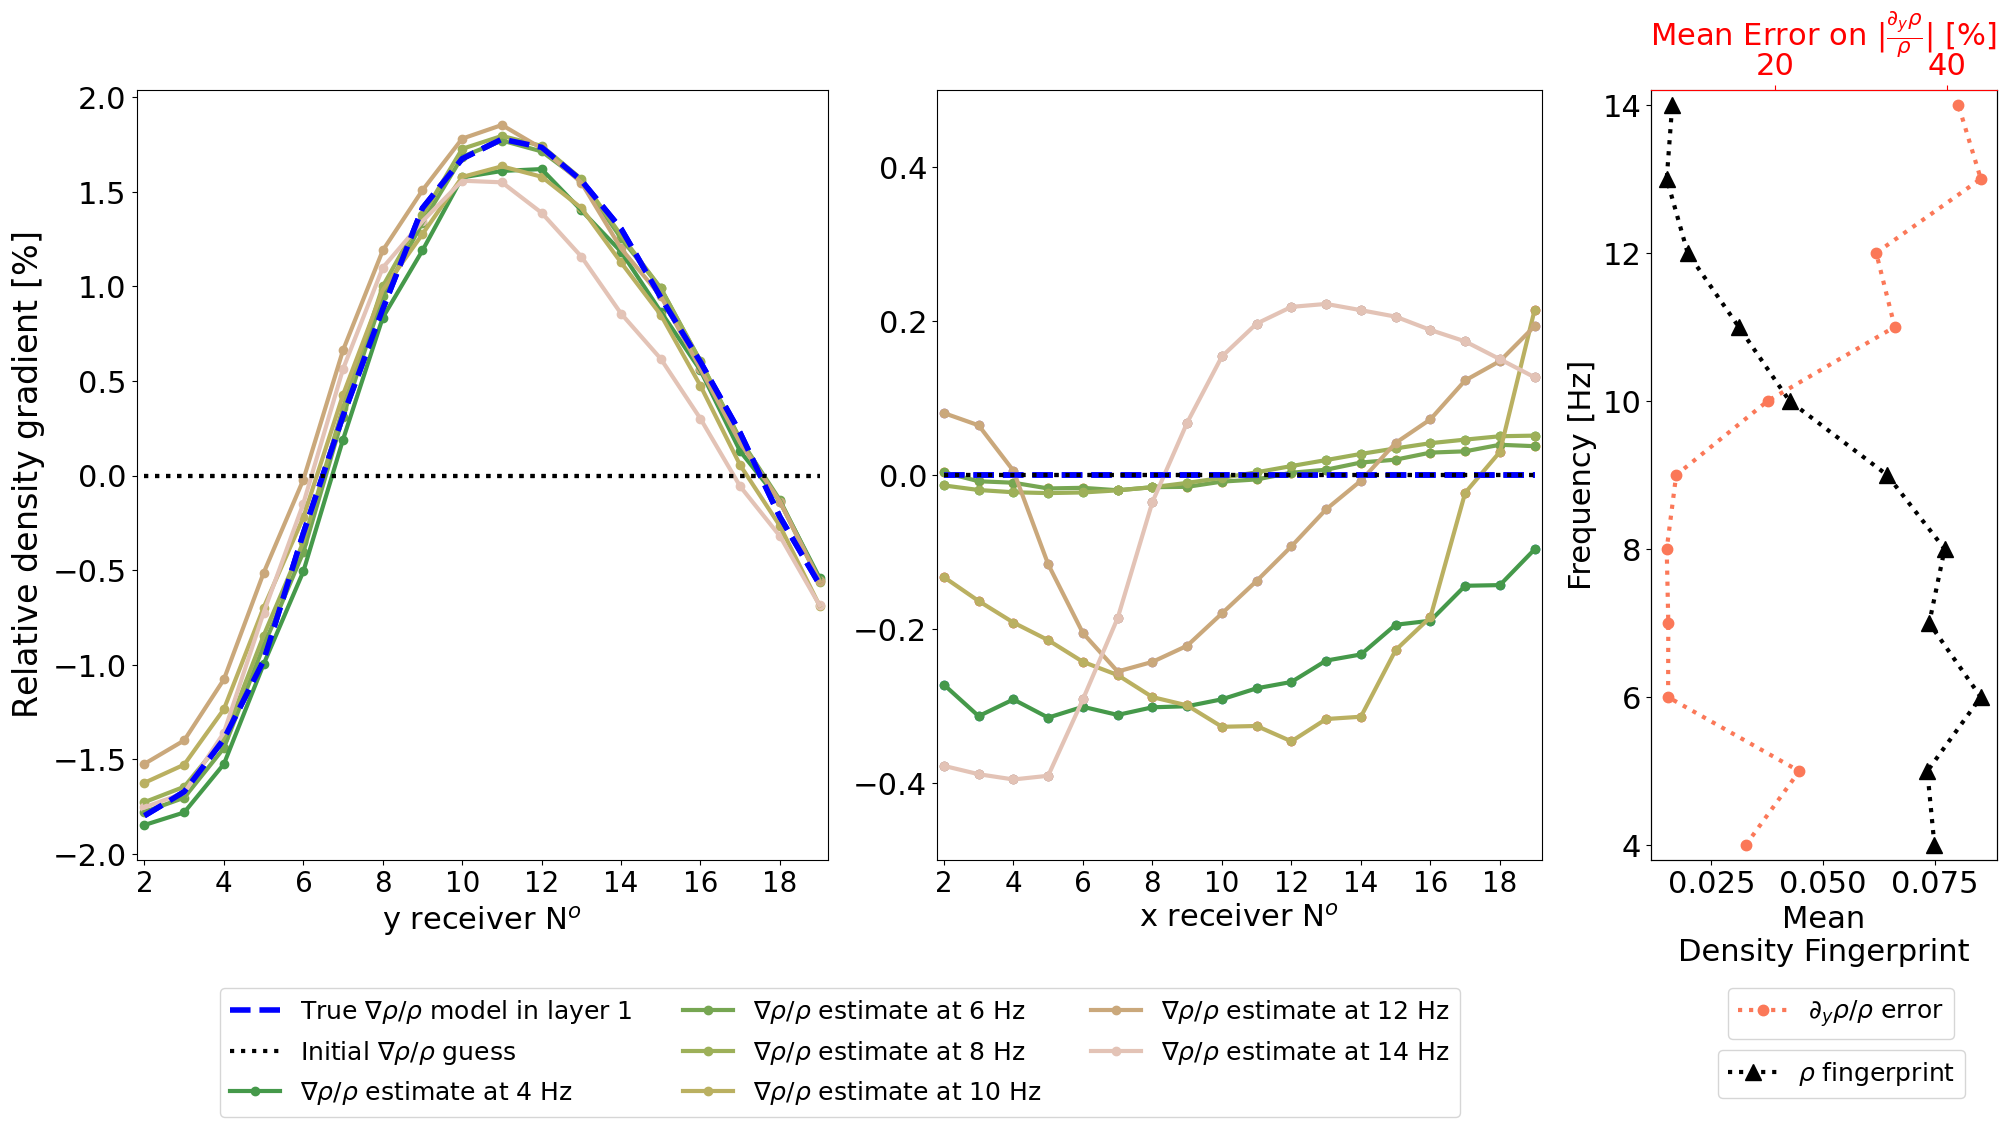

In [144]:
fig,(ax1,ax2, ax3) = plt.subplots(figsize=(24,10),ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m_init0 = np.ones((nr,nr))*np.mean(rho_grad[:,:,0])
#ax1.plot(np.arange(1,nr-1),(np.asarray(np.gradient(rho_grad[1:-1,1:-1,0])[0]).sum(1).T.flatten()/18), linewidth=10, color='yellow', label = 'True model', linestyle='-')
ax1.plot(np.arange(2,nr),(rho_GRAD_true_scaled[1:-1,1:-1].sum(1).T.flatten()/18), linewidth=4, color='blue', label = 'True model in layer 1', linestyle='--')
ax1.plot(np.arange(2,nr),(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18), linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax2.plot(np.arange(2,nr),(np.gradient(rho_grad[1:-1,1:-1,0].sum(0)).T.flatten()/18), linewidth=4, color='blue', label = r'True $\nabla$$\rho$/$\rho$ model in layer 1', linestyle='--')
ax2.plot(np.arange(2,nr),(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18), linewidth=3, color='black', label = r'Initial $\nabla$$\rho$/$\rho$ guess', linestyle=':')


m=0
for jj in np.arange(0,len(fff),2): 
    ax2.plot(np.arange(2,nr),(store_grad_Y_scaled[jj,1:-1,1:-1].sum(0)/(nr-2)),color=ccc[m+4],linewidth=3,marker='o',label= r'$\nabla$$\rho$/$\rho$ estimate at ' +str(fff[jj])+str(' Hz'))
    ax2.scatter(np.arange(2,nr),(store_grad_Y_scaled[jj,1:-1,1:-1].sum(0)/(nr-2)))
    ax1.plot(np.arange(2,nr),(store_grad_X_scaled[jj,1:-1,1:-1].sum(1)/(nr-2) ),color=ccc[m+4],linewidth=3)
    ax1.scatter(np.arange(2,nr),(store_grad_X_scaled[jj,1:-1,1:-1].sum(1)/(nr-2)),marker='o',label= r'$\nabla$$\rho$/$\rho$ estimate at ' +str(fff[jj])+str(' Hz'),color=ccc[m+4])
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=22)
    ax2.set_xticks(np.arange(2, 20, 2.0))
    ax1.set_xticks(np.arange(2, 20, 2.0))
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=22)
    m=m+1
ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])  
ax2.set_ylim([-0.5,0.5])  

m_init0 = np.ones((nr,nr))*np.mean(rho_grad[:,:,0])
#ax1.plot(np.arange(1,nr-1),(np.asarray(np.gradient(rho_grad[1:-1,1:-1,0])[0]).sum(1).T.flatten()/18), linewidth=10, color='yellow', label = 'True model', linestyle='-')
ax1.plot(np.arange(2,nr),(rho_GRAD_true_scaled[1:-1,1:-1].sum(1).T.flatten()/18), linewidth=4, color='blue', linestyle='--')
ax1.plot(np.arange(2,nr),(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18), linewidth=3, color='black', linestyle=':')
ax2.plot(np.arange(2,nr),(np.gradient(rho_grad[1:-1,1:-1,0].sum(0)).T.flatten()/18), linewidth=4, color='blue', linestyle='--')
ax2.plot(np.arange(2,nr),(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18), linewidth=3, color='black',  linestyle=':')

ax1.set_xlabel(r'y receiver N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x receiver N$^{o}$',fontsize=22)

ax1.set_ylabel(r'Relative density gradient [$\%$]',fontsize=24)
#ax2.legend(fontsize=18,loc='upper right', ncol=2)
#ax2.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(1.02, 1.2))
ax2.legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(-0.16, -0.15))
#ax2.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(-0.16, -0.15))

#ax3.plot(100*RHO_SIGNAL_RATIO[:,0], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
# ax3.plot(100*RHO_SIGNAL_RATIO_loaded[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
ax3.plot(FINGERPRINT[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')

#ax3.plot(dc_c[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='springgreen', label=r'$\rho$ fingerprint')

#ax3.scatter(100*RHO_SIGNAL_RATIO[1:-1,0], fff_new,marker='+',s=200, color='black')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=22)
ax3.set_xlabel(r'Mean' +'\n'+ 'Density Fingerprint',fontsize=22)
#ax3.set_xlim([5,17])
ax4 = ax3.twiny()
#ax4.scatter(((PARA_ERROR_MEAN_GRAD)),fff,linewidth=2, linestyle=':', color='crimson')
ax4.plot((PARA_ERROR_MEAN_GRADX),fff,linewidth=3, linestyle=':', marker='.', markersize=15, color='#fb7858', label=r'$\partial_{y} \rho/\rho$ error')
### --> #fb7858
# ax4.set_xlabel(r'Mean Error on' +'\n'+ 'Density' + ' Y-Gradient [%]',fontsize=22)
ax4.set_xlabel(r'Mean Error on $|\frac{\partial_{y} \rho}{\rho}|$' + ' [%]',fontsize=22)
ax4.xaxis.set_tick_params(labelsize=22)
#ax4.set_xlim([0-1,50])
ax4.spines['top'].set_color('red')
ax4.tick_params(axis='x', colors='red')
ax4.xaxis.label.set_color('red')
ax4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.55, -0.15))
ax3.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.55, -0.23))

# props = dict(boxstyle='round', facecolor='none', edgecolor='k',alpha=1)
# ax1.text(1.03, 2.04, r'$\frac{\partial_{y} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)
# ax2.text(2.18, 2.04, r'$\frac{\partial_{x} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)

# props = dict(boxstyle='round', facecolor='none', edgecolor='k',alpha=1)
# ax1.text(-3.1, 1.4, r'$\frac{\partial_{y} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)
# ax2.text(-1.035, 1.4, r'$\frac{\partial_{x} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)

# props = dict(boxstyle='round', facecolor='none', edgecolor='k',alpha=1)
# ax1.text(-3.1, 1.45, r'$\frac{\partial_{y} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)
# ax2.text(-1.035, 1.45, r'$\frac{\partial_{x} \rho}{\rho}$', transform=ax.transAxes, fontsize=36, color='k',
#         verticalalignment='top', bbox=props)

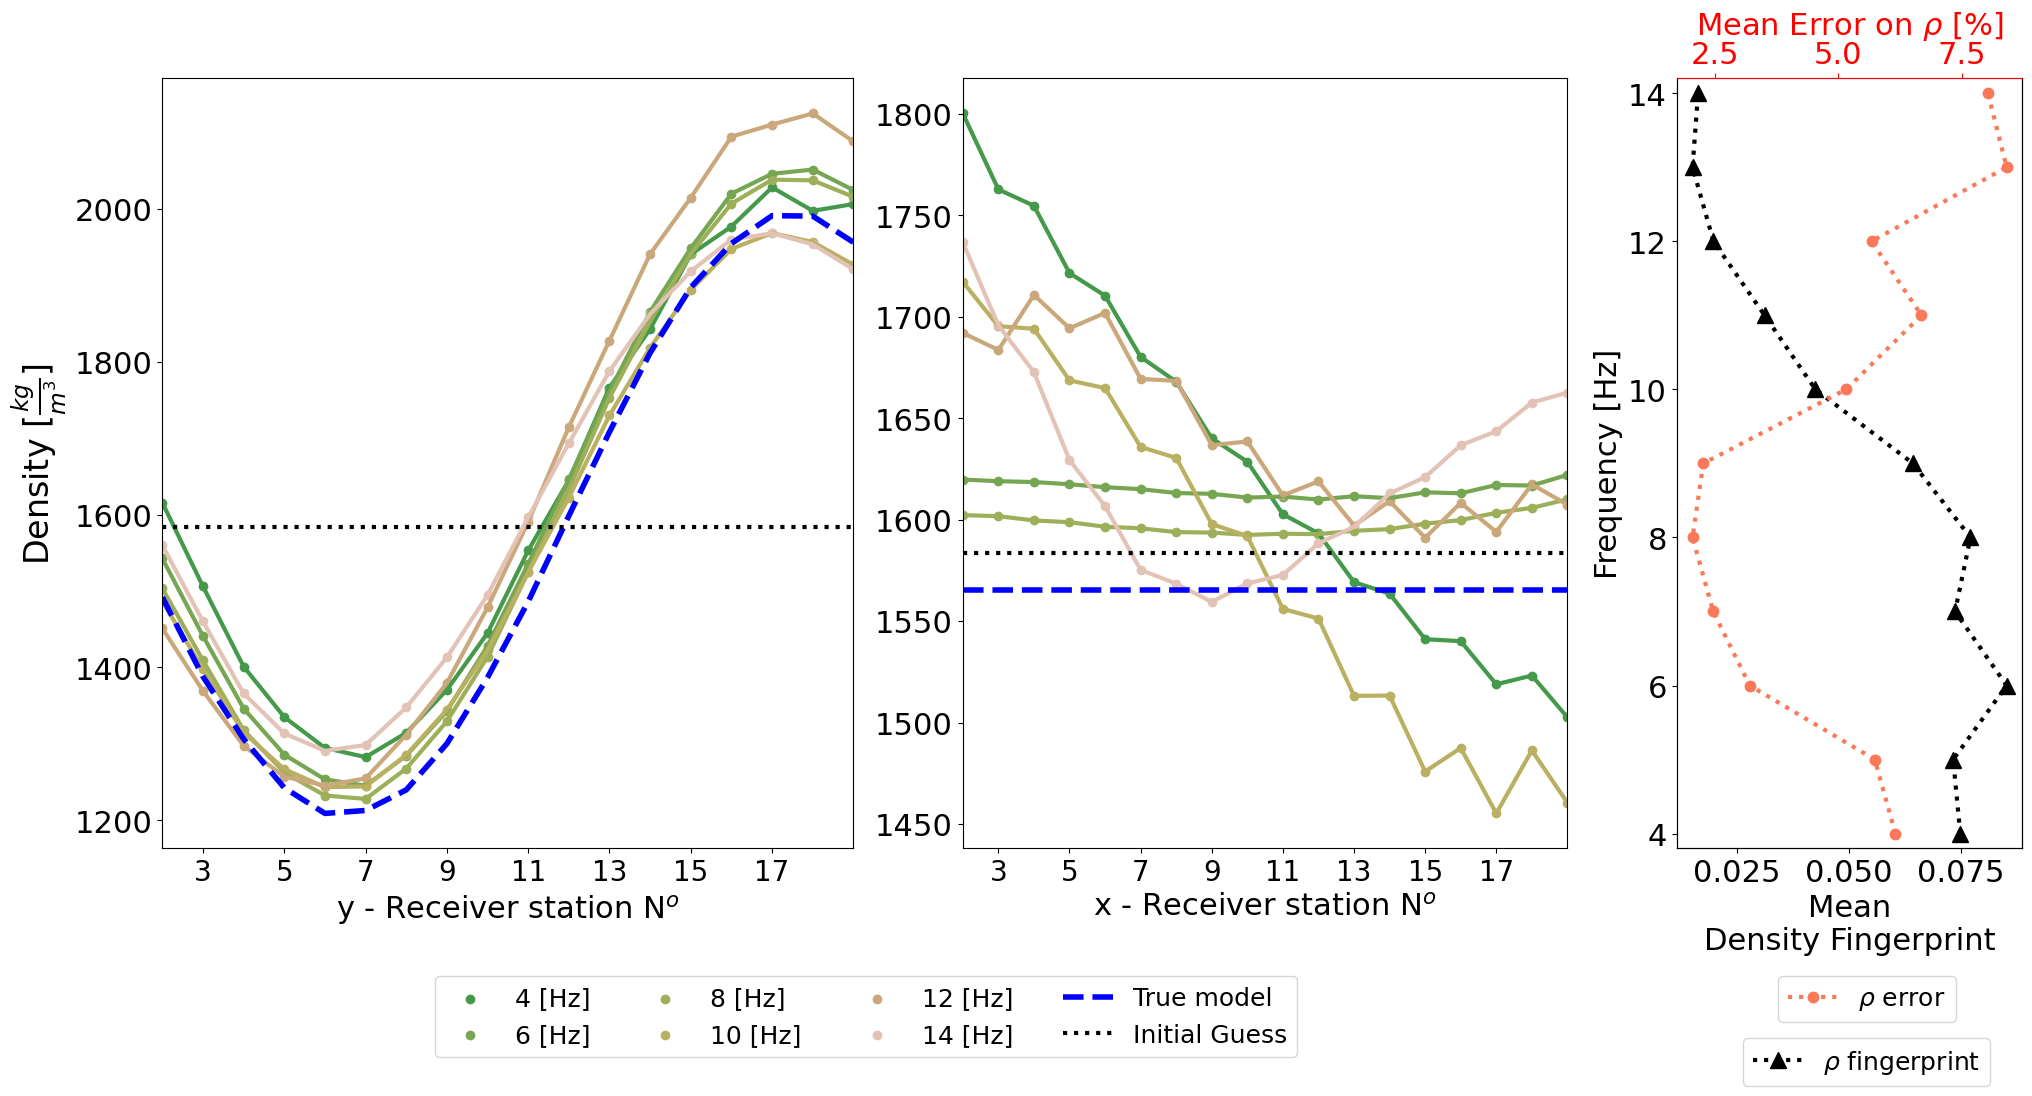

In [193]:
fig,(ax1,ax2, ax3) = plt.subplots(figsize=(24,10),ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m=0
for jj in np.arange(0,len(fff),2): 
    ax1.plot(np.arange(2,nr),RHO_ACC_MEAN_Y[jj,:],color=ccc[m+4],linewidth=3)
    ax1.scatter(np.arange(2,nr),RHO_ACC_MEAN_Y[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax2.plot(np.arange(2,nr),RHO_ACC_MEAN_X[jj,:],color=ccc[m+4],linewidth=3)
    ax2.scatter(np.arange(2,nr),RHO_ACC_MEAN_X[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=22)
    ax2.set_xticks(np.arange(1, 19, 2.0))
    ax1.set_xticks(np.arange(1, 19, 2.0))
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=22)
    m=m+1
ax1.set_xlim([2,19])    
ax2.set_xlim([2,19])    


m_init0 = np.ones((nr,nr))*np.mean(rho_grad[:,:,0])
ax1.plot(np.arange(2,nr),rho_grad[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(2,nr),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax2.plot(np.arange(2,nr),rho_grad[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(2,nr),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)

ax1.set_ylabel(r'Density [$\frac{kg}{m^3}$]',fontsize=24)
#ax1.legend(fontsize=18,loc='upper left', ncol=2)
ax2.legend(fontsize=18, ncol=4,loc='upper center', bbox_to_anchor=(-0.16, -0.15))


ax3.plot(FINGERPRINT[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=22)
ax3.set_xlabel(r'Mean' +'\n'+ 'Density Fingerprint',fontsize=22)
#ax3.set_xlim([5,17])
ax4 = ax3.twiny()
#ax4.scatter(((PARA_ERROR_MEAN_GRAD)),fff,linewidth=2, linestyle=':', color='crimson')
ax4.plot((PARA_ERROR_MEAN),fff,linewidth=3, linestyle=':', marker='.', markersize=15, color='#fb7858', label=r'$\rho$ error')
### --> #fb7858
# ax4.set_xlabel(r'Mean Error on' +'\n'+ 'Density' + ' Y-Gradient [%]',fontsize=22)
ax4.set_xlabel(r'Mean Error on $\rho$' + ' [%]',fontsize=22)
ax4.xaxis.set_tick_params(labelsize=22)
#ax4.set_xlim([0-1,50])
ax4.spines['top'].set_color('red')
ax4.tick_params(axis='x', colors='red')
ax4.xaxis.label.set_color('red')
ax4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.55, -0.15))
ax3.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.55, -0.23))

In [145]:
PARA_ERROR_MEAN_GRADX

array([16.59699267, 22.81691394,  7.60355817,  7.62520644,  7.44167167,
        8.5417677 , 19.15731031, 33.89487585, 31.74672097, 43.88527083,
       41.26726252])

In [ ]:
break

In [ ]:
fff

In [ ]:
plt.scatter((abs(PARA_ERROR_MEAN_GRAD[0])),fff[0],linewidth=2, linestyle=':', color='black')


In [ ]:
fig,(ax1,ax2, ax3) = plt.subplots(figsize=(24,10),ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m=0
for jj in np.arange(0,len(fff),2): 
    ax2.plot(np.arange(1,nr-1),np.gradient(abs(store_grad_Y[jj,1:-1,1:-1].sum(0)/(nr-2))),color=ccc[m+4],linewidth=3)
    ax2.scatter(np.arange(1,nr-1),np.gradient(abs(store_grad_Y[jj,1:-1,1:-1].sum(0)/(nr-2))),label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax1.plot(np.arange(1,nr-1),np.gradient(abs(store_grad_X[jj,1:-1,1:-1].sum(1)/(nr-2) )),color=ccc[m+4],linewidth=3)
    ax1.scatter(np.arange(1,nr-1),np.gradient(abs(store_grad_X[jj,1:-1,1:-1].sum(1)/(nr-2))),label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=22)
    ax2.set_xticks(np.arange(1, 19, 2.0))
    ax1.set_xticks(np.arange(1, 19, 2.0))
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=22)
    m=m+1
ax1.set_xlim([1,18])    
ax2.set_xlim([1,18])    


m_init0 = np.ones((nr,nr))*np.mean(rho_grad[:,:,0])
#ax1.plot(np.arange(1,nr-1),abs(np.asarray(np.gradient(rho_grad[1:-1,1:-1,0])[0]).sum(1).T.flatten()/18), linewidth=10, color='yellow', label = 'True model', linestyle='-')
ax1.plot(np.arange(1,nr-1),np.gradient(abs(np.gradient(rho_grad[1:-1,1:-1,0].sum(1)).T.flatten()/18)), linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(1,nr-1),np.gradient(abs(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18)), linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax2.plot(np.arange(1,nr-1),np.gradient(abs(np.gradient(rho_grad[1:-1,1:-1,0].sum(0)).T.flatten()/18)), linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(1,nr-1),np.gradient(abs(np.gradient(m_init0[1:-1,1:-1].sum(1)).flatten()/18)), linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)

ax1.set_ylabel(r'Density Gradient [$\frac{g}{cm^3}$]',fontsize=24)
ax2.legend(fontsize=18,loc='upper right', ncol=2)

ax3.plot((abs(PARA_ERROR_MEAN_GRAD2[::1])),np.arange(4,15,1),linewidth=2, linestyle=':', color='black')
ax3.scatter((abs(PARA_ERROR_MEAN_GRAD2[::1])),np.arange(4,15,1),marker='+',s=200, color='black')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=22)
ax3.set_xlabel(r'Density' + ' $2^{nd}$ Gradient Error [%]',fontsize=22)


In [ ]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(np.arange(4,15,1),np.log(PARA_ERROR_MEAN[::1]),linewidth=2)
ax.scatter(np.arange(4,15,1),np.log(PARA_ERROR_MEAN[::1]))
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_xlim([fff[0],fff[-1]])
plt.xlabel(r'Frequency [Hz]',fontsize=18)
plt.ylabel(r'Parameter Error [%]',fontsize=18)
plt.legend(fontsize=16,loc='upper left', ncol=2)

In [ ]:
C_ACC_MEAN_Y.shape

In [ ]:
import seaborn as sns
palette = sns.color_palette('YlGnBu', 10).as_hex()
print(palette)
ccc_mag=['#f2fabc', '#dcf1b2', '#bbe4b5', '#85cfba', '#57bec1', '#34a9c3', '#1d8dbe', '#2166ac', '#24479d', '#1d2e83']

vir_mag=LinearSegmentedColormap.from_list("mycmap", ccc_mag)

In [ ]:
fff

In [ ]:
err_FD = pd.read_csv(fig_+'/FD_err').values

In [ ]:
vp_sub_INPUT_l2     = ds_without_q.vp.values[:,:,0]
vp_sub_INPUT_l2     = vp_sub_INPUT_l2[Rx,:]
vp_sub_INPUT_l2     = np.asarray(vp_sub_INPUT_l2[:,Ry])

vp_sub_INPUT_l22 = vp_sub_INPUT_l2[::2,::2]

In [ ]:
fig,(ax1,ax2, ax3) = plt.subplots(figsize=(24,10),ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m=0
ax1.plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model at the surface')#, label = 'True model', linestyle='--')
ax1.plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(1).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')

for jj in np.arange(0,len(fff),2): 
    ax2.plot(np.arange(2,nr),C_HELM_MEAN_X[jj,:],color=ccc[m+4], linestyle=':',linewidth=3,label= 'Helmholtz: '+str(fff[jj])+str(' [Hz]'), marker='o')
    ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[jj,:],color=ccc[m+4], linestyle=':',linewidth=3,label= r' Helmholtz $c_{\omega}$ estimate at '+str(fff[jj])+str(' Hz'), marker='o')
    #ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],color=ccc[m+4],linewidth=3, linestyle='-')
    #ax1.scatter(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],label= r' Full acoustic $c_{\omega}$ estimate  at '+str(fff[jj])+str(' Hz'),color=ccc[m+4], marker='o',linewidth=3)
    ax2.plot(np.arange(2,nr),C_ACC_MEAN_X[jj,:],label= r' Full acoustic $c_{\omega}$ estimate at '+str(fff[jj])+str(' Hz'),color=ccc[m+4], marker='o',linewidth=3)

    #ax2.plot(np.arange(2,nr),C_ACC_MEAN_X[jj,:],color=ccc[m+4],linewidth=3, linestyle='-')
    #ax2.scatter(np.arange(2,nr),C_ACC_MEAN_X[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    #ax2.scatter(np.arange(2,nr),C_HELM_MEAN_X[jj,:],label= 'Hemholtz '+ str(fff[jj])+str(' [Hz]'),color=ccc[m])
    #ax1.scatter(np.arange(2,nr),C_HELM_MEAN_Y[jj,:],label= 'Hemholtz '+ str(fff[jj])+str(' [Hz]'),color=ccc[m])
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=22)
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=22)
    ax2.set_xticks(np.arange(2, 19, 2.0))
    ax1.set_xticks(np.arange(2, 19, 2.0))
    m=m+1
# ax2.scatter(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
# ax1.scatter(np.arange(2,nr),C_HELM_MEAN_Y[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
#ax2.plot(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[:,:].sum(0)/11,label= r' Mean of full acoustic $c_{\omega}$ estimate for [4-14] Hz',color='black',linewidth=10, linestyle='-')
ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[:,:].sum(0)/11,label= r' Mean of Helmholtz $c_{\omega}$ estimate for [4-14] Hz',color='grey',linewidth=10, linestyle=':')
#ax2.plot(np.arange(2,nr),C_ACC_MEAN_X[:,:].sum(0)/11,label= 'Mean Acoustic',color='black',linewidth=10, linestyle='-')
#ax2.plot(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz',color='grey',linewidth=10, linestyle=':')
#ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[0,:],color=ccc[4], linestyle=':',linewidth=3,marker='o', label='Helmholtz: Dotted Lines')
#ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[0,:],color=ccc[4],linewidth=3, linestyle='-',marker='o', label='Full acoustic: Solid Lines')
# ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[0,:],color=ccc[0+3],linewidth=5, label='Acoustic')
# ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[0,:],color=ccc[0+3],linewidth=5,label= 'Helmholtz', linestyle=':')

ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])    

#ax1.plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(1).T.flatten()/17, linewidth=5, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model at the surface')
ax2.plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(0).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')

ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)

ax1.set_ylabel(r'Phase velocity [m/s]',fontsize=24)
ax1.legend(fontsize=18,loc='upper left', ncol=2)
ax1.legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.02, 1.3))
ax1.legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.02, -0.15))
ax1.legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.32, -0.15))
ax1.set_ylim([1550,2900])
ax2.set_ylim([1550,2900])

ax3.plot((err_FD[2,3:14]),np.arange(4,15,1),linewidth=3, linestyle=':', color='black')
ax3.scatter((err_FD[2,3:14]),np.arange(4,15,1),marker='+',s=300, color='black')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=24)
ax3.set_xlabel('Finite Difference \n Error [%]',fontsize=22)

# ax4.plot(100*RHO_SIGNAL_RATIO_loaded[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
# axx4 = ax4.twiny()
# axx4.plot(dc_c[:], fff_new,linewidth=3, linestyle='--', marker='s', markersize=10, color='crimson', label=r'$\partial$c/c')
# #ax4.legend(fontsize=16,loc='upper right')
# axx4.legend(fontsize=18,loc='upper right')#loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.93))

# ax4.xaxis.set_tick_params(labelsize=22)
# axx4.xaxis.set_tick_params(labelsize=22)
# ax4.yaxis.set_tick_params(labelsize=22)
# axx4.set_xlabel(r'$\partial$c/c [%]',fontsize=24)
# ax4.set_xlabel('Density \n Fingerprint [%]',fontsize=22)
# ax4.set_ylim([3.8,14.2])

#ax4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.45, -0.15))
#axx4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.47, -0.23))

In [ ]:
fig,(ax1,ax2, ax3) = plt.subplots(figsize=(24,10),ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m=0
ax1.plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model at the surface')#, label = 'True model', linestyle='--')
ax1.plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(1).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')

for jj in np.arange(0,len(fff),2): 
    ax2.plot(np.arange(2,nr),C_HELM_MEAN_X[jj,:],color=ccc[m+4], linestyle=':',linewidth=3,label= 'Helmholtz: '+str(fff[jj])+str(' [Hz]'), marker='o')
    ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[jj,:],color=ccc[m+4], linestyle=':',linewidth=3,label= r' Helmholtz $c_{\omega}$ estimate at '+str(fff[jj])+str(' Hz'), marker='o')
    #ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],color=ccc[m+4],linewidth=3, linestyle='-')
    #ax1.scatter(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    #ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],label= r' Full acoustic $c_{\omega}$ estimate  at '+str(fff[jj])+str(' Hz'),color=ccc[m+4], marker='o',linewidth=3)
    #ax2.plot(np.arange(2,nr),C_ACC_MEAN_X[jj,:],label= r' Full acoustic $c_{\omega}$ estimate at '+str(fff[jj])+str(' Hz'),color=ccc[m+4], marker='o',linewidth=3)

    #ax2.plot(np.arange(2,nr),C_ACC_MEAN_X[jj,:],color=ccc[m+4],linewidth=3, linestyle='-')
    #ax2.scatter(np.arange(2,nr),C_ACC_MEAN_X[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    #ax2.scatter(np.arange(2,nr),C_HELM_MEAN_X[jj,:],label= 'Hemholtz '+ str(fff[jj])+str(' [Hz]'),color=ccc[m])
    #ax1.scatter(np.arange(2,nr),C_HELM_MEAN_Y[jj,:],label= 'Hemholtz '+ str(fff[jj])+str(' [Hz]'),color=ccc[m])
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=22)
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=22)
    ax2.set_xticks(np.arange(2, 19, 2.0))
    ax1.set_xticks(np.arange(2, 19, 2.0))
    m=m+1
# ax2.scatter(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
# ax1.scatter(np.arange(2,nr),C_HELM_MEAN_Y[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
#ax2.plot(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
#ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[:,:].sum(0)/11,label= r' Mean of full acoustic $c_{\omega}$ estimate for [4-14] Hz',color='black',linewidth=10, linestyle='-')
ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[:,:].sum(0)/11,label= r' Mean of Helmholtz $c_{\omega}$ estimate for [4-14] Hz',color='grey',linewidth=10, linestyle=':')
#ax2.plot(np.arange(2,nr),C_ACC_MEAN_X[:,:].sum(0)/11,label= 'Mean Acoustic',color='black',linewidth=10, linestyle='-')
#ax2.plot(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz',color='grey',linewidth=10, linestyle=':')
#ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[0,:],color=ccc[4], linestyle=':',linewidth=3,marker='o', label='Helmholtz: Dotted Lines')
#ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[0,:],color=ccc[4],linewidth=3, linestyle='-',marker='o', label='Full acoustic: Solid Lines')
# ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[0,:],color=ccc[0+3],linewidth=5, label='Acoustic')
# ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[0,:],color=ccc[0+3],linewidth=5,label= 'Helmholtz', linestyle=':')

ax1.set_xlim([2-0.2,19+0.2])    
ax2.set_xlim([2-0.2,19+0.2])    

#ax1.plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(1).T.flatten()/17, linewidth=5, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model at the surface')
ax2.plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(0).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')

ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=22)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=22)

ax1.set_ylabel(r'Phase velocity [m/s]',fontsize=24)
ax1.legend(fontsize=18,loc='upper left', ncol=2)
ax1.legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.02, 1.3))
ax1.legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.02, -0.15))
ax1.legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.32, -0.15))
ax1.set_ylim([1550,2900])
ax2.set_ylim([1550,2900])

ax3.plot((err_FD[2,3:14]),np.arange(4,15,1),linewidth=3, linestyle=':', color='black')
ax3.scatter((err_FD[2,3:14]),np.arange(4,15,1),marker='+',s=300, color='black')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=22)
ax3.set_xlabel('Finite Difference \n Error [%]',fontsize=22)

# ax4.plot(100*RHO_SIGNAL_RATIO_loaded[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
# axx4 = ax4.twiny()
# axx4.plot(dc_c[:], fff_new,linewidth=3, linestyle='--', marker='s', markersize=10, color='crimson', label=r'$\partial$c/c')
# #ax4.legend(fontsize=16,loc='upper right')
# axx4.legend(fontsize=18,loc='upper right')#loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.93))

# ax4.xaxis.set_tick_params(labelsize=22)
# axx4.xaxis.set_tick_params(labelsize=22)
# ax4.yaxis.set_tick_params(labelsize=22)
# axx4.set_xlabel(r'$\partial$c/c [%]',fontsize=24)
# ax4.set_xlabel('Density \n Fingerprint [%]',fontsize=22)
# ax4.set_ylim([3.8,14.2])

#ax4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.45, -0.15))
#axx4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.47, -0.23))

In [ ]:
fig,axs = plt.subplots(figsize=(24,16),nrows=2, ncols=3,gridspec_kw={'width_ratios': [1.6,1.4, 0.8]})
m=0
axs[0,0].plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model in layer 1')#, label = 'True model', linestyle='--')
axs[0,0].plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(1).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')
axs[1,0].plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model in layer 1')#, label = 'True model', linestyle='--')
axs[1,0].plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(1).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')

for jj in np.arange(0,len(fff),2): 
    axs[0,1].plot(np.arange(2,nr),C_HELM_MEAN_X[jj,:],color=ccc[m+4], linestyle='-',linewidth=3,label= 'Helmholtz: '+str(fff[jj])+str(' [Hz]'), marker='o')
    axs[0,0].plot(np.arange(2,nr),C_HELM_MEAN_Y[jj,:],color=ccc[m+4], linestyle='-',linewidth=3,label= r'$c_{\omega}$ estimate at '+str(fff[jj])+str(' Hz'), marker='o')
    #ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],color=ccc[m+4],linewidth=3, linestyle='-')
    #ax1.scatter(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    axs[1,0].plot(np.arange(2,nr),C_ACC_MEAN_Y[jj,:],label= r'$c_{\omega}$ estimate  at '+str(fff[jj])+str(' Hz'),color=ccc[m+4], marker='o',linewidth=3)
    axs[1,1].plot(np.arange(2,nr),C_ACC_MEAN_X[jj,:],label= r'$c_{\omega}$ estimate at '+str(fff[jj])+str(' Hz'),color=ccc[m+4], marker='o',linewidth=3)

    #ax2.plot(np.arange(2,nr),C_ACC_MEAN_X[jj,:],color=ccc[m+4],linewidth=3, linestyle='-')
    #ax2.scatter(np.arange(2,nr),C_ACC_MEAN_X[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    #ax2.scatter(np.arange(2,nr),C_HELM_MEAN_X[jj,:],label= 'Hemholtz '+ str(fff[jj])+str(' [Hz]'),color=ccc[m])
    #ax1.scatter(np.arange(2,nr),C_HELM_MEAN_Y[jj,:],label= 'Hemholtz '+ str(fff[jj])+str(' [Hz]'),color=ccc[m])
    axs[0,0].xaxis.set_tick_params(labelsize=20)
    axs[0,0].yaxis.set_tick_params(labelsize=22)
    axs[0,1].xaxis.set_tick_params(labelsize=20)
    axs[0,1].yaxis.set_tick_params(labelsize=22)
    axs[0,1].set_xticks(np.arange(2, 19, 2.0))
    axs[0,0].set_xticks(np.arange(2, 19, 2.0))
    axs[1,0].xaxis.set_tick_params(labelsize=20)
    axs[1,0].yaxis.set_tick_params(labelsize=22)
    axs[1,1].xaxis.set_tick_params(labelsize=20)
    axs[1,1].yaxis.set_tick_params(labelsize=22)
    axs[1,1].set_xticks(np.arange(2, 19, 2.0))
    axs[1,0].set_xticks(np.arange(2, 19, 2.0))
    m=m+1
# ax2.scatter(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
# ax1.scatter(np.arange(2,nr),C_HELM_MEAN_Y[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
#ax2.plot(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz shape',color='crimson')
axs[1,0].plot(np.arange(2,nr),C_ACC_MEAN_Y[:,:].sum(0)/11,label= r' Mean $c_{\omega}$ estimate for [4-14] Hz',color='black',linewidth=10, linestyle='-')
axs[0,0].plot(np.arange(2,nr),C_HELM_MEAN_Y[:,:].sum(0)/11,label= r' Mean of Helmholtz $c_{\omega}$ estimate for [4-14] Hz',color='k',linewidth=10, linestyle='-')
axs[1,1].plot(np.arange(2,nr),C_ACC_MEAN_X[:,:].sum(0)/11,label= 'Mean Acoustic',color='black',linewidth=10, linestyle='-')
axs[0,1].plot(np.arange(2,nr),C_HELM_MEAN_X[:,:].sum(0)/11,label= 'Mean Hemholtz',color='k',linewidth=10, linestyle='-')
#ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[0,:],color=ccc[4], linestyle=':',linewidth=3,marker='o', label='Helmholtz: Dotted Lines')
#ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[0,:],color=ccc[4],linewidth=3, linestyle='-',marker='o', label='Full acoustic: Solid Lines')
# ax1.plot(np.arange(2,nr),C_ACC_MEAN_Y[0,:],color=ccc[0+3],linewidth=5, label='Acoustic')
# ax1.plot(np.arange(2,nr),C_HELM_MEAN_Y[0,:],color=ccc[0+3],linewidth=5,label= 'Helmholtz', linestyle=':')

axs[0,0].set_xlim([2-0.2,19+0.2])    
axs[0,1].set_xlim([2-0.2,19+0.2])  
axs[1,0].set_xlim([2-0.2,19+0.2])    
axs[1,1].set_xlim([2-0.2,19+0.2])  

#ax1.plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(1).T.flatten()/17, linewidth=5, color='blue', label = 'True model', linestyle='--')
axs[0,1].plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model at the surface')
axs[0,1].plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(0).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')

axs[1,1].plot(np.arange(2,nr),vp_sub[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=5, color='blue', linestyle='--', label = r'True $v_{P}$ model at the surface')
axs[1,1].plot(np.arange(2,nr),vp_sub_INPUT_l22[1:-1,1:-1].sum(0).T.flatten()/18, linewidth=5, color='tab:blue', linestyle='--', label = r'True $v_{P}$ model in layer 2')#, label = 'True model', linestyle='--')

axs[1,0].set_xlabel(r'y receiver N$^{o}$',fontsize=22)
axs[1,1].set_xlabel(r'x receiver N$^{o}$',fontsize=22)

axs[0,0].set_ylabel(r'Helmholtz'+'\n'+'Phase velocity [m/s]',fontsize=24)
axs[1,0].set_ylabel(r'Full acoustic'+'\n'+' Phase velocity [m/s]',fontsize=24)

axs[1,0].legend(fontsize=18,loc='upper left', ncol=2)
#axs[0,0].legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.02, 1.3))
#axs[0,1].legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.02, -0.15))
axs[1,0].legend(fontsize=18, ncol=3,loc='upper center', bbox_to_anchor=(1.05, -0.2))
axs[0,0].set_ylim([1550,2900])
axs[0,1].set_ylim([1550,2900])
axs[1,1].set_ylim([1550,2900])
axs[1,0].set_ylim([1550,2900])

# gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.6,1.4, 0.8], height_ratios=[1,1])
# axs = fig.add_subplot(gs[:, 2])

gs = axs[0, 2].get_gridspec()
# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()
ax3 = fig.add_subplot(gs[0:, -1],)
ax3.plot((err_FD[2,3:14]),np.arange(4,15,1),linewidth=3, linestyle=':', color='black')
ax3.scatter((err_FD[2,3:14]),np.arange(4,15,1),marker='+',s=300, color='black')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.set_ylim([fff[0]-0.2,fff[-1]+0.2])
ax3.set_ylabel(r'Frequency [Hz]',fontsize=24)
ax3.set_xlabel('Finite Difference \n Error [%]',fontsize=22)
#fig.tight_layout()

# ax4.plot(100*RHO_SIGNAL_RATIO_loaded[:], fff_new,linewidth=3, linestyle=':', marker='^', markersize=12, color='black', label=r'$\rho$ fingerprint')
# axx4 = ax4.twiny()
# axx4.plot(dc_c[:], fff_new,linewidth=3, linestyle='--', marker='s', markersize=10, color='crimson', label=r'$\partial$c/c')
# #ax4.legend(fontsize=16,loc='upper right')
# axx4.legend(fontsize=18,loc='upper right')#loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.93))

# ax4.xaxis.set_tick_params(labelsize=22)
# axx4.xaxis.set_tick_params(labelsize=22)
# ax4.yaxis.set_tick_params(labelsize=22)
# axx4.set_xlabel(r'$\partial$c/c [%]',fontsize=24)
# ax4.set_xlabel('Density \n Fingerprint [%]',fontsize=22)
# ax4.set_ylim([3.8,14.2])

#ax4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.45, -0.15))
#axx4.legend(fontsize=18, ncol=1,loc='upper center', bbox_to_anchor=(0.47, -0.23))

In [ ]:
# plt.plot((vp_sub[1:-1,1:-1,0].sum(0)/16),(vp_sub[1:-1,1:-1,0].sum(0)/16),color='black',linestyle=':',linewidth=0.5)
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/16),C_HELM_MEAN_X[:,:].sum(0)/11,marker='+',s=100)

# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/16).flatten(),C_ACC_MEAN_X[:,:].sum(0)/11)
# corr1 = np.corrcoef(vp_sub[1:-1,1:-1,0].sum(0)/16,C_ACC_MEAN_X[:,:].sum(0)/11)[0][1]
# corr2 = np.corrcoef(vp_sub[1:-1,1:-1,0].sum(0)/16,C_HELM_MEAN_X[:,:].sum(0)/11)[0][1]
# print(str(corr1)+';'+str(corr2))

In [ ]:
RHO_ACC = np.zeros((length,nr,nr)) 
PARA_ERROR = np.zeros((length,nr,nr)) 
PARA_ERROR_MEAN = np.zeros((length))
RHO_ACC_MEAN_Y = np.zeros((length,nr-2))
RHO_ACC_MEAN_X = np.zeros((length,nr-2))

i=0
for ff in fff: 
    RHO_ACC[i,:,:] = pd.read_csv(fig_+'/rho_inv_minMIS'+'_'+str(ff)).values
    #RHO_ACC[i,:,:] = pd.read_csv(fig_+'/rho_inv'+'_'+str(ff)).values
    RHO_ACC_MEAN_Y[i,:] = RHO_ACC[i,1:-1,1:-1].sum(1)/(nr-2)
    RHO_ACC_MEAN_X[i,:] = RHO_ACC[i,1:-1,1:-1].sum(0)/(nr-2)
    PARA_ERROR[i,:,:] = 100*(abs(RHO_ACC[i,:,:] - rho_grad[:,:,0] ) /rho_grad[:,:,0])#.sum().sum()
    PARA_ERROR_MEAN[i] = (1/(nr-2)**2)*PARA_ERROR[i,1:-1,1:-1].sum().sum()
    i=i+1

In [ ]:
fig,(ax1,ax2) = plt.subplots(figsize=(20,10),ncols=2)
m=0
for jj in np.arange(0,len(fff),2): 
    ax1.plot(np.arange(1,nr-1),RHO_ACC_MEAN_Y[jj,:],color=ccc[m+4],linewidth=2)
    ax1.scatter(np.arange(1,nr-1),RHO_ACC_MEAN_Y[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax2.plot(np.arange(1,nr-1),RHO_ACC_MEAN_X[jj,:],color=ccc[m+4],linewidth=2)
    ax2.scatter(np.arange(1,nr-1),RHO_ACC_MEAN_X[jj,:],label= str(fff[jj])+str(' [Hz]'),color=ccc[m+4])
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18)
    ax2.xaxis.set_tick_params(labelsize=18)
    ax2.yaxis.set_tick_params(labelsize=18)
    m=m+1
ax1.set_xlim([1,18])    
ax2.set_xlim([1,18])    


m_init0 = np.ones((nr,nr))*np.mean(rho_grad[:,:,0])
ax1.plot(np.arange(1,nr-1),rho_grad[1:-1,1:-1,0].sum(1).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax1.plot(np.arange(1,nr-1),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax2.plot(np.arange(1,nr-1),rho_grad[1:-1,1:-1,0].sum(0).T.flatten()/18, linewidth=4, color='blue', label = 'True model', linestyle='--')
ax2.plot(np.arange(1,nr-1),m_init0[1:-1,1:-1].sum(1).flatten()/18, linewidth=3, color='black', label = 'Initial Guess', linestyle=':')
ax1.set_xlabel(r'y - Receiver station N$^{o}$',fontsize=18)
ax2.set_xlabel(r'x - Receiver station N$^{o}$',fontsize=18)

ax1.set_ylabel(r'Density [$\frac{g}{cm^3}$]',fontsize=18)
ax1.legend(fontsize=16,loc='upper left', ncol=2)


## Correlation Study

In [ ]:
fff

In [ ]:
plt.scatter(fff[::2],corr_RHO[::2])

In [ ]:
corr_RHO = np.zeros((len(fff)))
for jj in np.arange(0,len(fff),1): 
    corr_RHO[jj] = np.corrcoef(rho_grad[1:-1,1:-1,0].sum(1),RHO_ACC[jj,1:-1,1:-1].sum(1))[0][1]

In [ ]:
plt.plot((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),color='black',linestyle=':',linewidth=0.5)
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[0,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[1,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[2,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[3,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[4,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[5,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[6,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[7,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[8,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[9,1:-1,1:-1].sum(1)/18).T.flatten())
plt.scatter((rho_grad[1:-1,1:-1,0].sum(1)/18).T.flatten(),(RHO_ACC[10,1:-1,1:-1].sum(1)/18).T.flatten())


In [ ]:
corr_VEL_ACC = np.zeros((len(fff)))
corr_VEL_HELM = np.zeros((len(fff)))

for jj in np.arange(0,len(fff),1): 
    corr_VEL_ACC[jj] = np.corrcoef(vp_sub[1:-1,1:-1,0].sum(0),C_ACC[jj,1:-1,1:-1].sum(0))[0][1]
    corr_VEL_HELM[jj] = np.corrcoef(vp_sub[1:-1,1:-1,0].sum(0),C_HELM[jj,1:-1,1:-1].sum(0))[0][1]

In [ ]:
plt.plot(corr_VEL_ACC, label='Acoustic')
plt.plot(corr_VEL_HELM, label='Helm')
plt.legend()

In [ ]:
plt.plot((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),color='black',linestyle=':',linewidth=0.5)
plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_HELM[0,1:-1,1:-1].sum(0)/18).T.flatten(),marker='+',s=100)

plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).flatten(),(C_ACC[0,1:-1,1:-1].sum(0)/18).flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[1,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[2,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[3,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[4,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[5,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[6,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[7,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[8,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[9,1:-1,1:-1].sum(0)/18).T.flatten())
# plt.scatter((vp_sub[1:-1,1:-1,0].sum(0)/18).T.flatten(),(C_ACC[10,1:-1,1:-1].sum(0)/18).T.flatten())